# Technical pattern screener and analysis

Framework from [this quantopian thread](https://www.quantopian.com/posts/an-empirical-algorithmic-evaluation-of-technical-analysis).

Go to [Running screener](#runningscreener) section for instructions on how to run.

In [153]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from collections import defaultdict
import warnings
import time
import matplotlib.pyplot as plt
import matplotlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
import alpaca_trade_api as tradeapi
from tqdm import tqdm



api = tradeapi.REST('your API key here',
                    'your secret key here', 
                    'https://paper-api.alpaca.markets')

from datetime import timedelta

matplotlib.rcParams['figure.figsize'] = (8, 5)


In [224]:
def get_data(symbol, lookback):
    all_data = pd.DataFrame()
    for x in range(lookback):
        if x == 0:
            data = api.polygon.historic_agg('minute', 
                                            symbol, 
                                            limit=None).df
        else:
            data = api.polygon.historic_agg('minute', 
                                        symbol, 
                                        _from = (data.index.min() - timedelta(days=5)).strftime('%x %X'),
                                        to = start, 
                                        limit = None).df
        start = data.index.min().strftime('%x %X')
        all_data = pd.concat([data, all_data], axis=0)
    all_data.drop(columns=['volume'], inplace=True)
    all_data.replace(0, method='bfill', inplace=True)
    return all_data
        
def get_stock_data(stocklist, lookback):
    stock_data = {}
    for stock in tqdm(stocklist, desc='Getting stock data'):
        try:
            stock_data[stock] = get_data(stock, lookback)
        except Exception as e:
            print('Exception {} {}'.format(stock, e))
    return stock_data

def resample(stock_data, rate):
    for stock in stock_data:
        stock_data[stock] = stock_data[stock].resample(rate, closed='right', label='right').agg({'open': 'first',
                                                                                                 'high': 'max',
                                                                                                 'low': 'min',
                                                                                                 'close': 'last'}).dropna()
    return stock_data

def reformat_to_series(data_to_reformat, original_data, index_name='date', old_index_name='timestamp', new_index_name='day_num', column_name='close'):
    data_to_reformat.index.name = index_name
    data_to_reformat = data_to_reformat.reset_index()
    data_to_reformat = data_to_reformat[~data_to_reformat[index_name].duplicated()]
    p = original_data.reset_index()
    data_to_reformat[new_index_name] = p[p[old_index_name].isin(data_to_reformat[index_name])].index.values
    data_to_reformat = data_to_reformat.set_index(new_index_name)[column_name]
    return data_to_reformat

def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['close'].rolling(window=smoothing).mean().dropna()
    
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    local_maxima = smooth_prices.iloc[local_max]
    local_minima = smooth_prices.iloc[local_min]
    local_maxima = reformat_to_series(local_maxima, smooth_prices, index_name='date', old_index_name='timestamp', new_index_name='day_num', column_name='close')
    local_minima = reformat_to_series(local_minima, smooth_prices, index_name='date', old_index_name='timestamp', new_index_name='day_num', column_name='close')
    
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmin())  
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min = reformat_to_series(max_min, prices, index_name='date', old_index_name='timestamp', new_index_name='day_num', column_name='close')

    smooth_prices = reformat_to_series(smooth_prices, smooth_prices, index_name='date', old_index_name='date', new_index_name='day_num', column_name='close')
    
    return max_min, local_maxima, local_minima, smooth_prices

def find_patterns(max_min):  
    patterns = defaultdict(list)
    
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
                
        # IHS
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
               patterns['IHS'].append((window.index[0], window.index[-1]))
        
    return patterns
    
def plot_minmax_patterns(prices, max_min, patterns, stock, window, ema, local_maxima, local_minima, smooth_prices):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    f, axes = plt.subplots(2, 2, figsize=(16, 5))
    axes = axes.flatten()
    prices_ = prices.reset_index()['close']
    axes[0].plot(prices_)
    axes[0].scatter(max_min.index, max_min, s=100, alpha=.3, color='green')
    axes[0].scatter(local_maxima.index, local_maxima, s=100, alpha=.3, color='red')
    axes[0].scatter(local_minima.index, local_minima, s=100, alpha=.3, color='red')
    axes[1].plot(prices_, color='blue')
    axes[0].plot(smooth_prices, color='orange')
    axes[2].plot(prices_, color='blue')
    axes[3].plot(smooth_prices, color='orange')
    axes[2].scatter(max_min.index, max_min, s=100, alpha=.3, color='green')
    axes[3].scatter(local_maxima.index, local_maxima, s=100, alpha=.3, color='red')
    axes[3].scatter(local_minima.index, local_minima, s=100, alpha=.3, color='red')
    
    if len(patterns) == 0:
        num_pat = 0
    else:
        num_pat = len([x for x in patterns.items()][0][1])
        
        for name, end_day_nums in patterns.items():
            for i, tup in enumerate(end_day_nums):
                sd = tup[0]
                ed = tup[1]
                axes[1].scatter(max_min.loc[sd:ed].index,
                              max_min.loc[sd:ed].values,
                              s=200, alpha=.3)
                plt.yticks([])
    plt.tight_layout()
    plt.title('{}: {}: EMA {}, Window {} ({} patterns)'.format(stock, incr, ema, window, num_pat))
    plt.show()

def get_results(prices, max_min, pat, stock, ema_, window_):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    #fw_list = [1, 12, 24, 36] 
    fw_list = [1, 2, 3]
    results = []
    if len(pat.items()) > 0:
        end_dates = [v for k, v in pat.items()][0]      
        for date in end_dates:  
            param_res = {'stock': stock,
                         'increment': incr,
                         'ema': ema_,
                         'window': window_, 
                         'date': date}
            for x in fw_list:
                returns = (prices['close'].pct_change(x).shift(-x).reset_index(drop=True).dropna())
                try:
                    param_res['fw_ret_{}'.format(x)] = returns.loc[date[1]]   
                except Exception as e:
                    param_res['fw_ret_{}'.format(x)] = e
            results.append(param_res)  
    else:
        param_res = {'stock': stock,
                     'increment': incr,
                     'ema': ema_,
                     'window': window_,
                     'date': None}
        for x in fw_list:
            param_res['fw_ret_{}'.format(x)] = None   
        results.append(param_res)
    return pd.DataFrame(results)

def screener(stock_data, ema_list, window_list, plot, results):
    
    all_results = pd.DataFrame()
    
    for stock in stock_data:
        prices = stock_data[stock]
        
        for ema_ in ema_list:
            for window_ in window_list: 
                max_min, local_maxima, local_minima, smooth_prices = get_max_min(prices, smoothing=ema_, window_range=window_)
                pat = find_patterns(max_min)
                
                if plot == True:
                    plot_minmax_patterns(prices, max_min, pat, stock, window_, ema_, local_maxima, local_minima, smooth_prices)
                    
                if results == True:
                    all_results = pd.concat([all_results, get_results(prices, max_min, pat, stock, ema_, window_)], axis=0)
                
    if results == True:
        return all_results.reset_index(drop=True)

<a id='runningscreener'></a>

# Running screener

By default, get_stock_data() gets 1 minute data. 

resampled_stock_data is run in a separate cell, so you can go back and get different timeframes without requesting data repeatedly. Timeframe is specified in resample() (see comment for details).

screener() actually runs the screener. Set plot=True to see plots, otherwise results=True outputs results. To get results as an object, you have to set it to a variable (example cell below).

In [11]:
stocklist = ['TWTR', 'MSFT','MMM']#,
             #'S', 'V', 'VZ', 'AAPL', 
             #'AMZN', 'FB', 'NFLX', 
             #'GOOG', 'GS', 'LNKD',
             #'TLRY']

stock_data = get_stock_data(stocklist, 5)

Getting stock data: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


In [12]:
# Run different timeframes here without requesting new data. '5T' = 5 minutes, '60T' = 1 hour, '120T' = 2 hours, etc.
resampled_stock_data = resample(stock_data, '360T')

C:\Users\timcr\Anaconda3\envs\ip3_full\lib\site-packages\pandas\core\sorting.py:257: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  items = np.asanyarray(items)


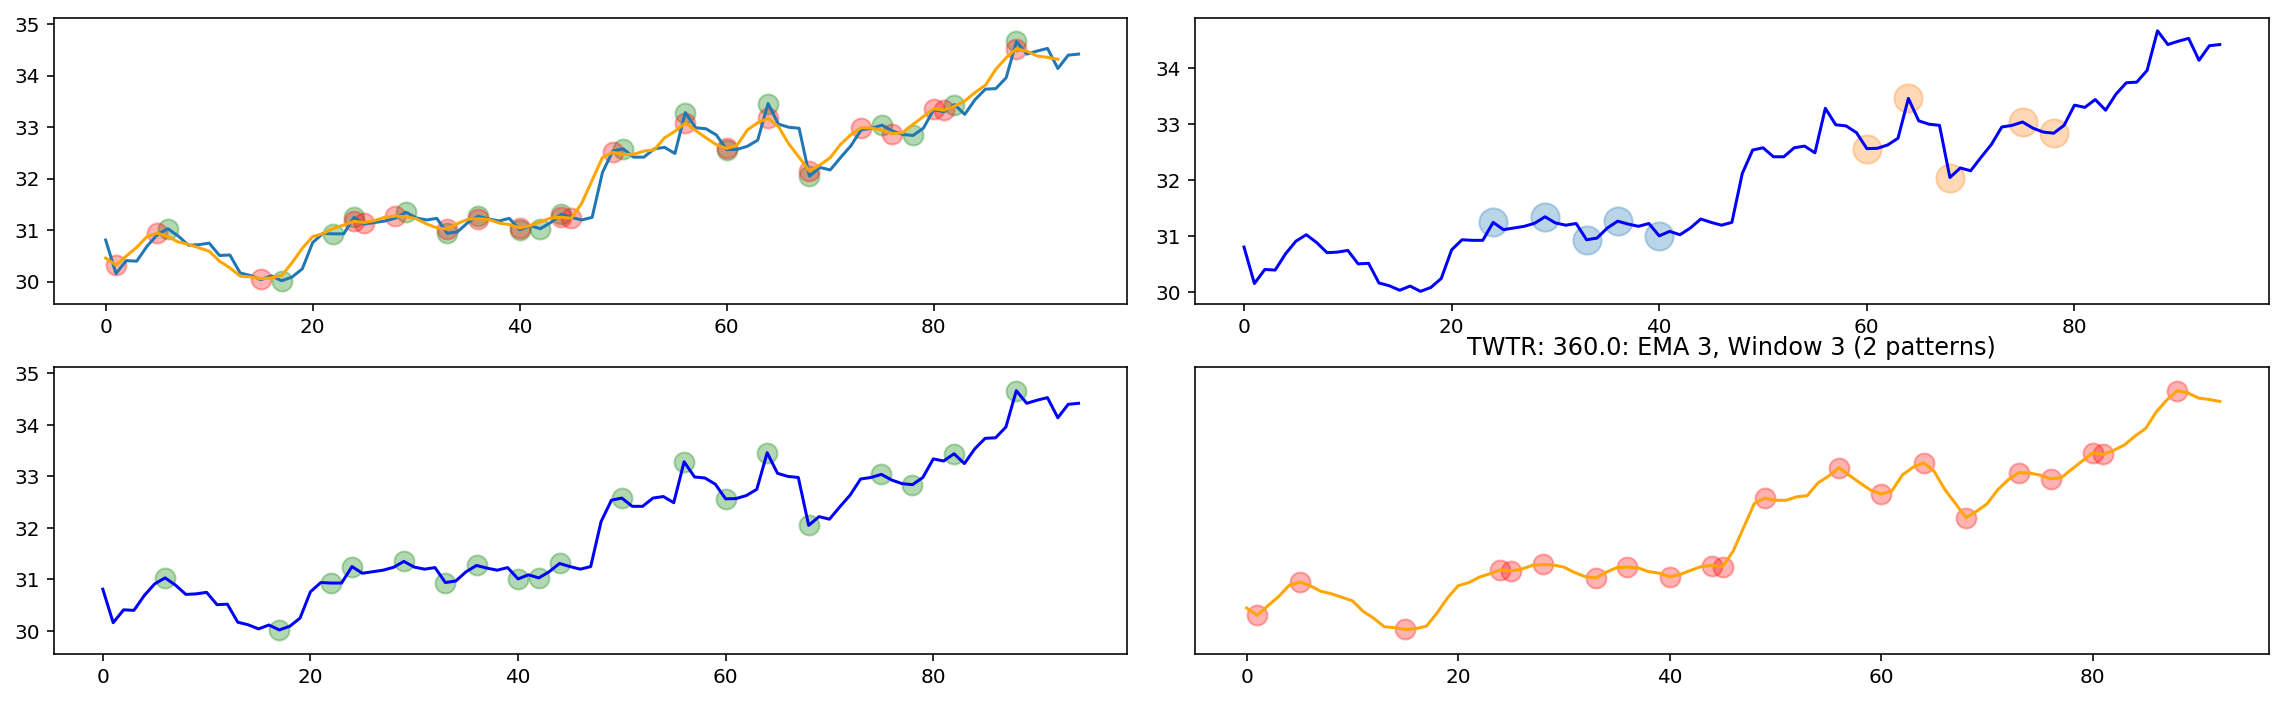

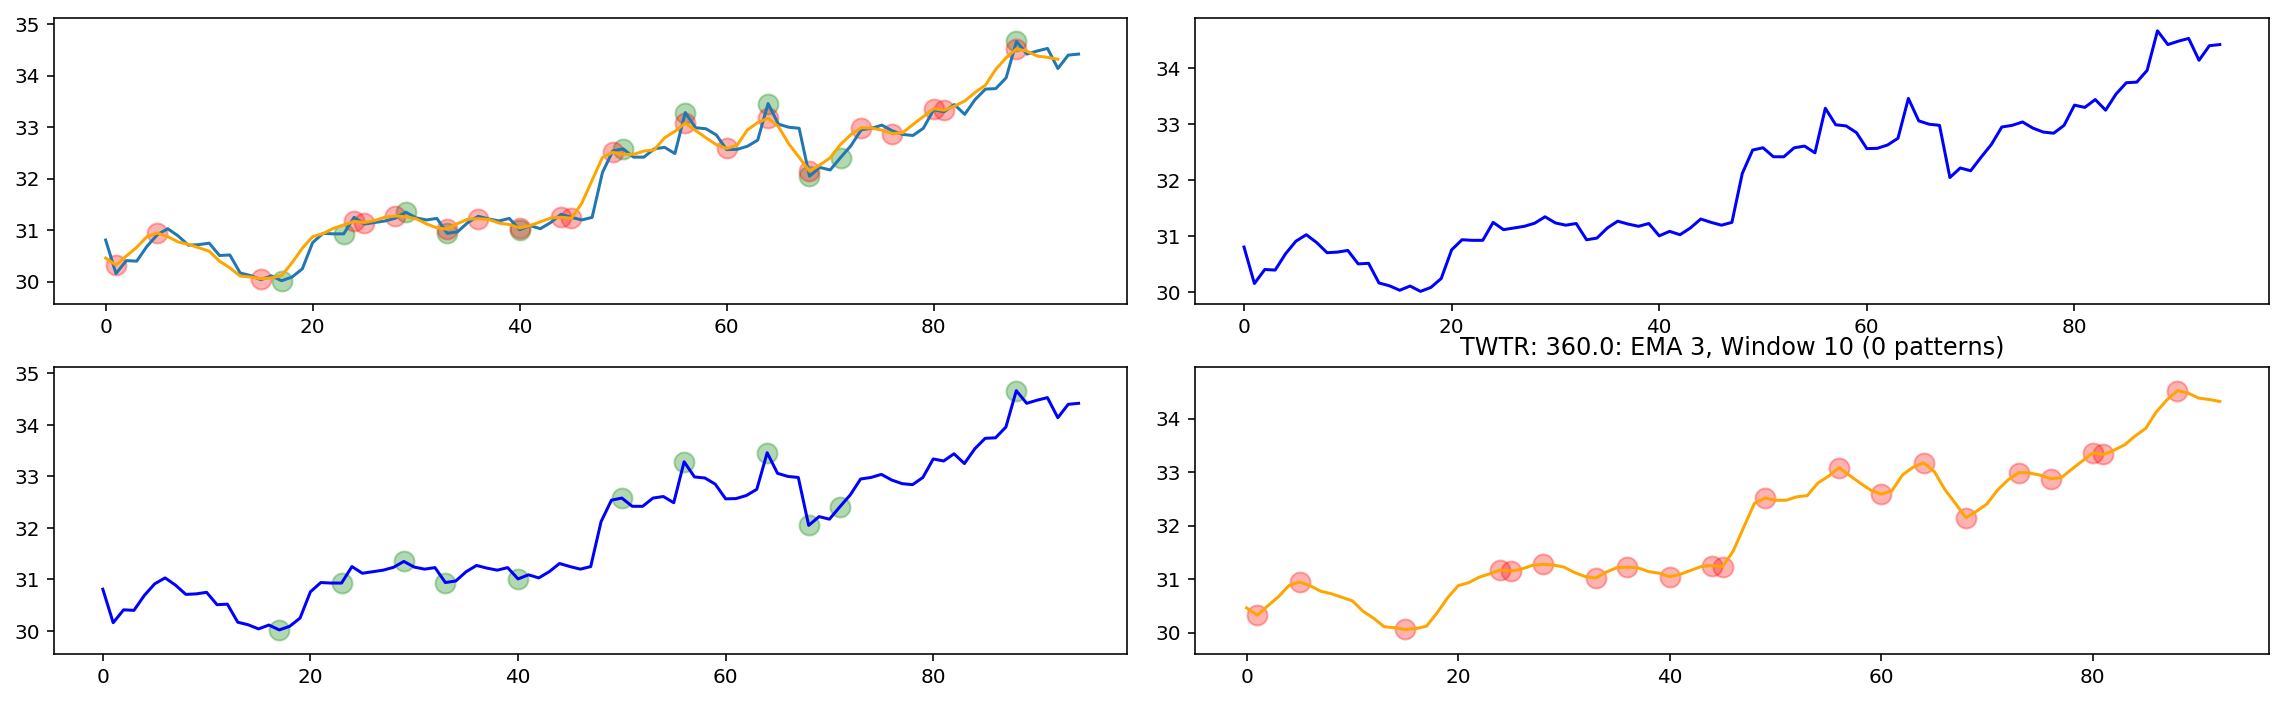

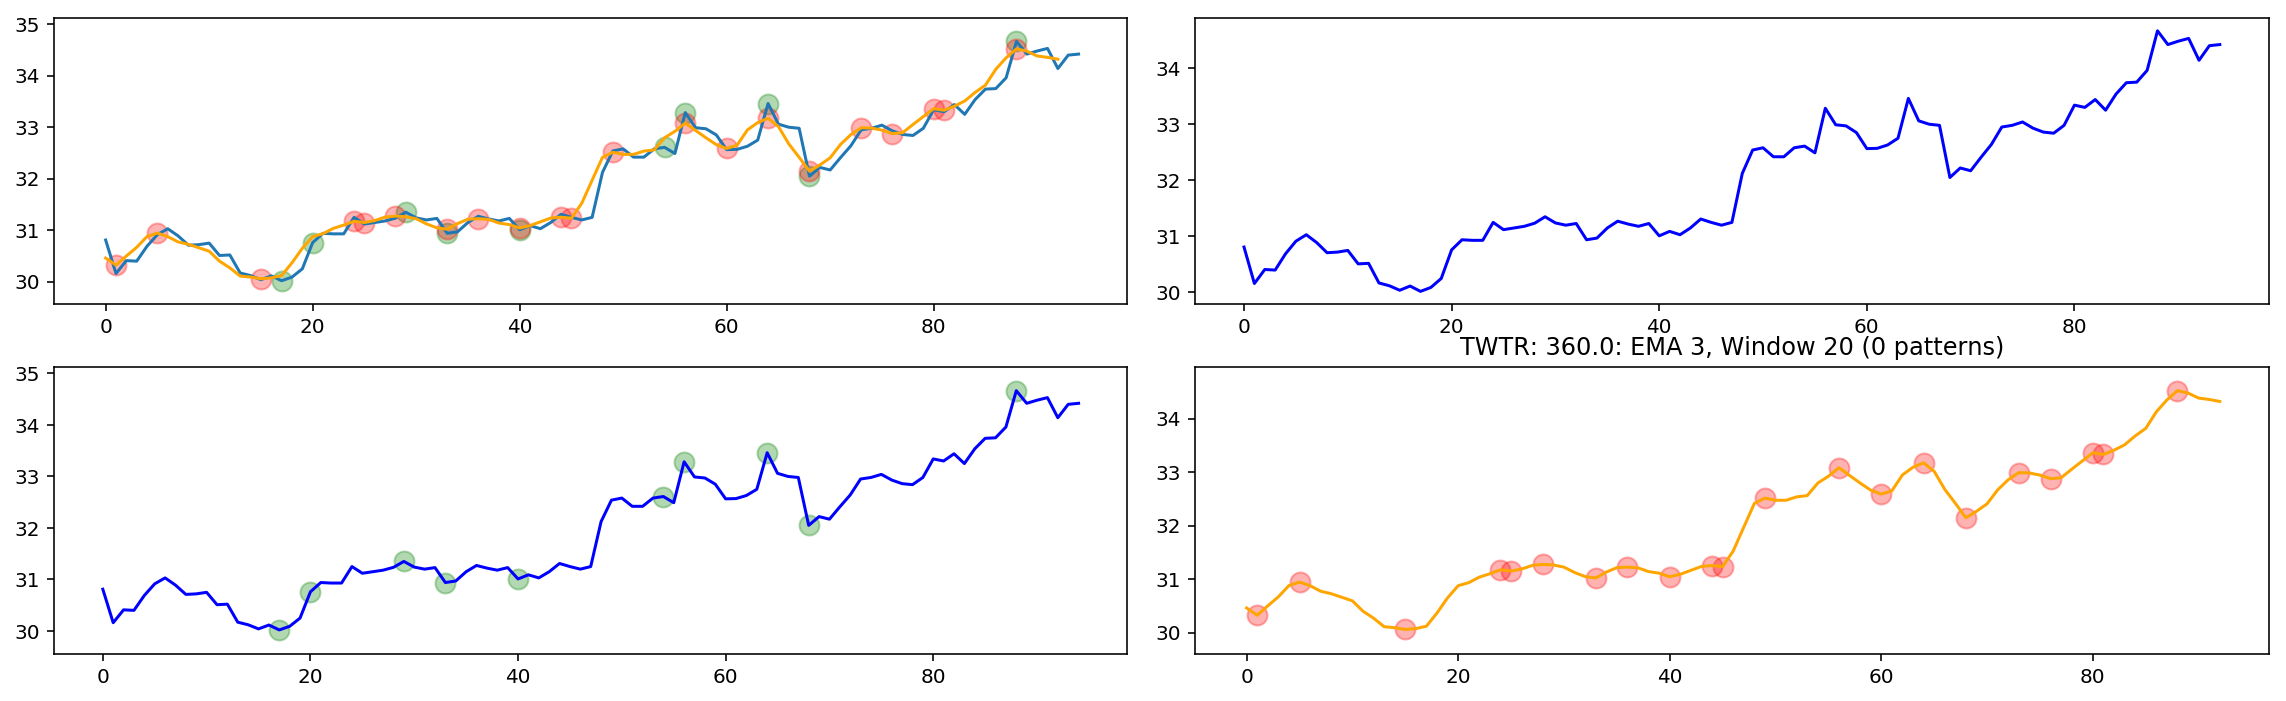

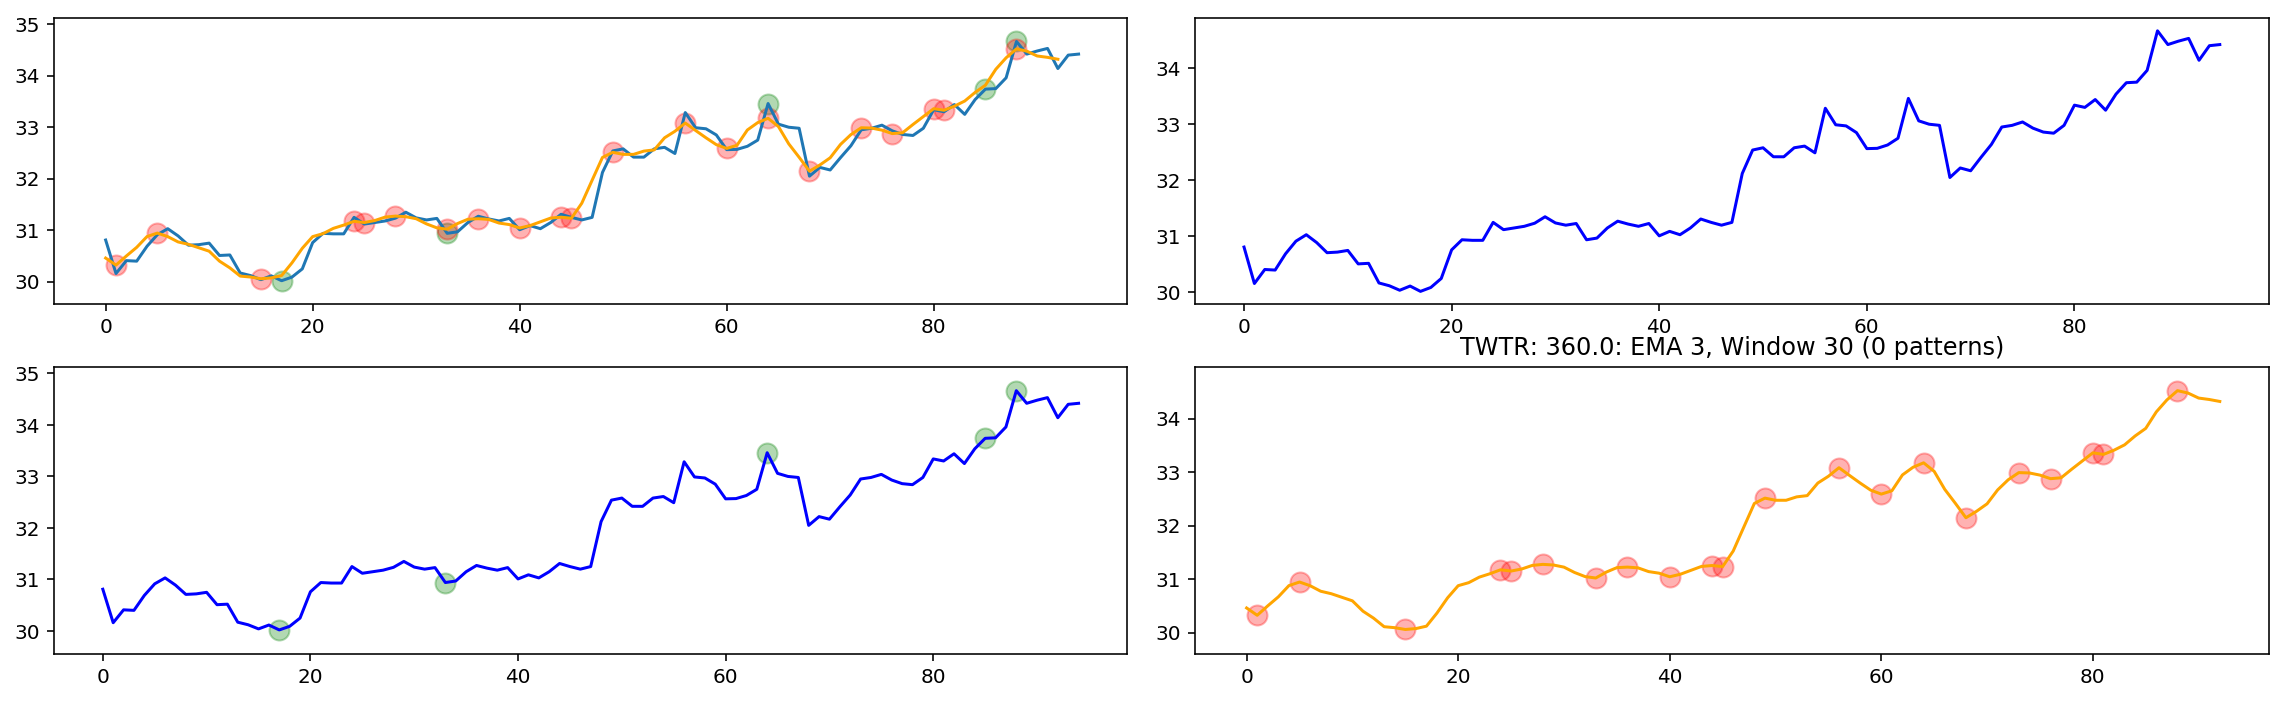

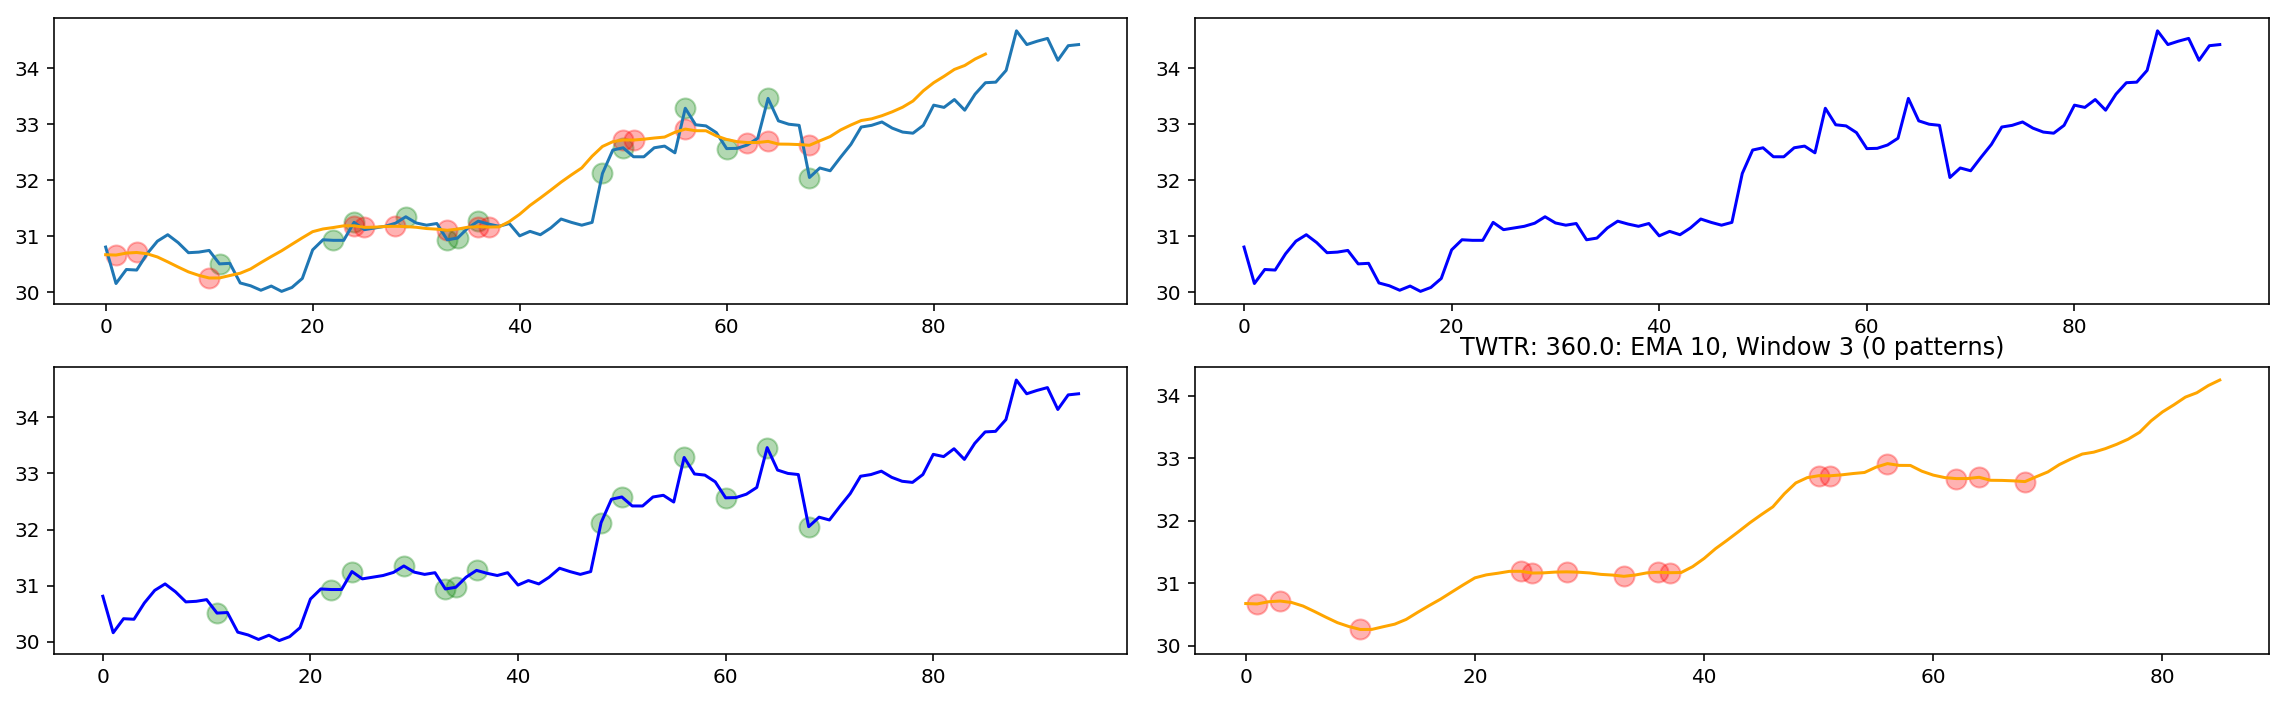

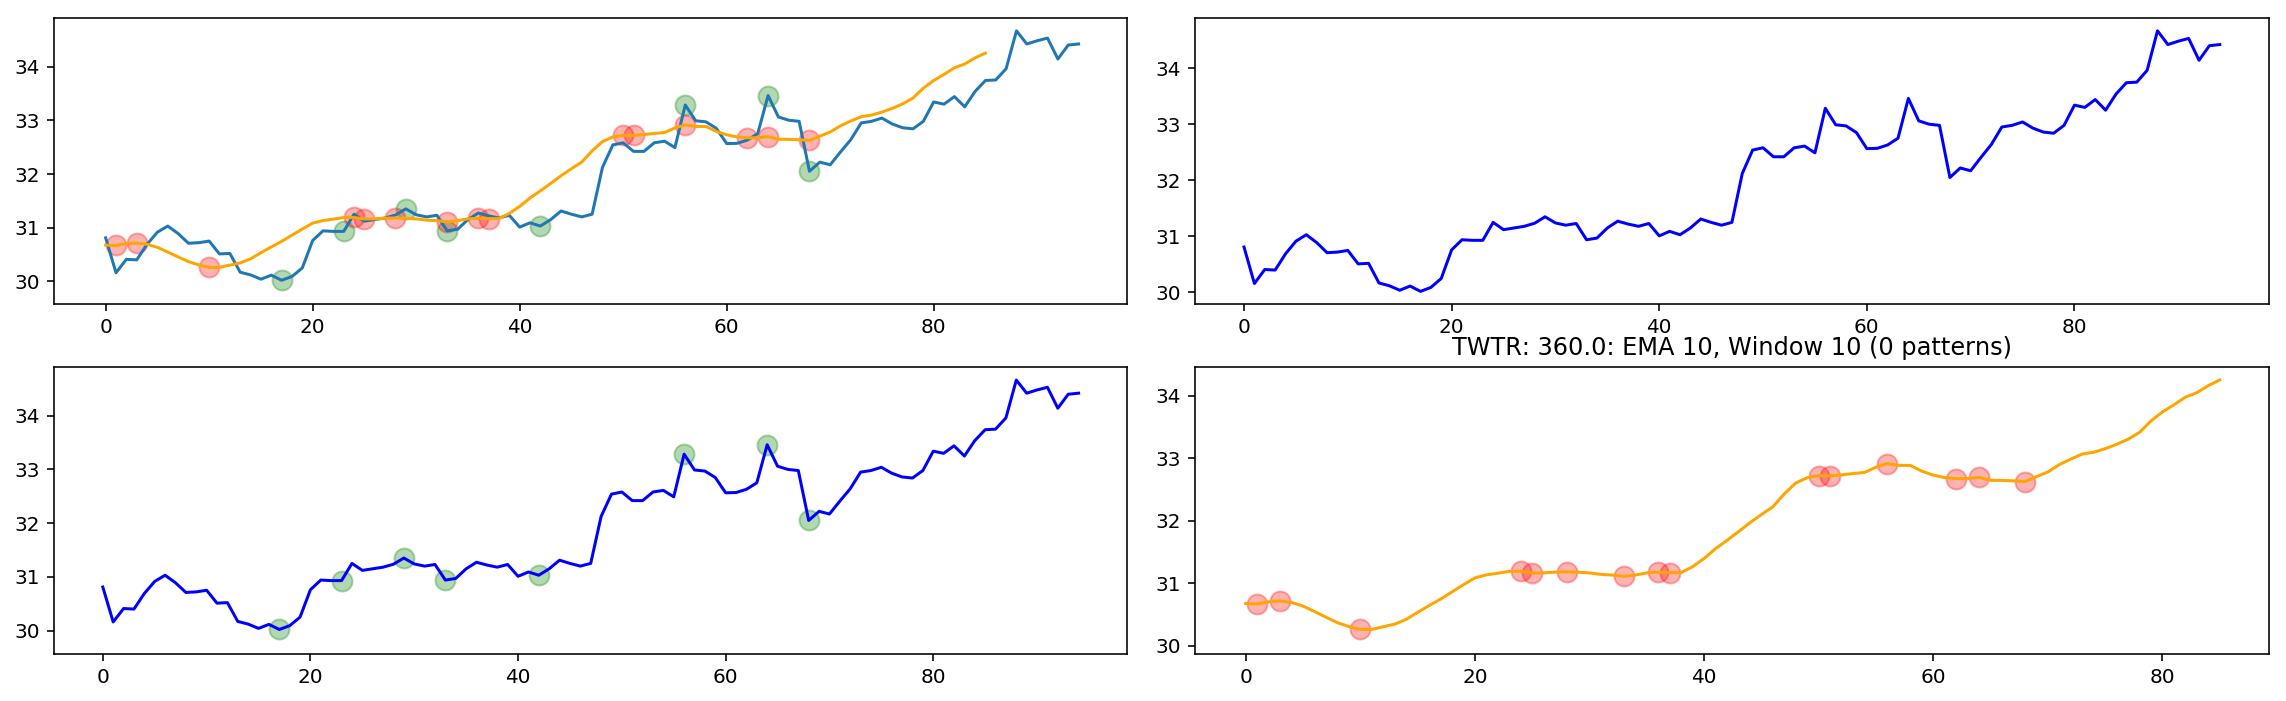

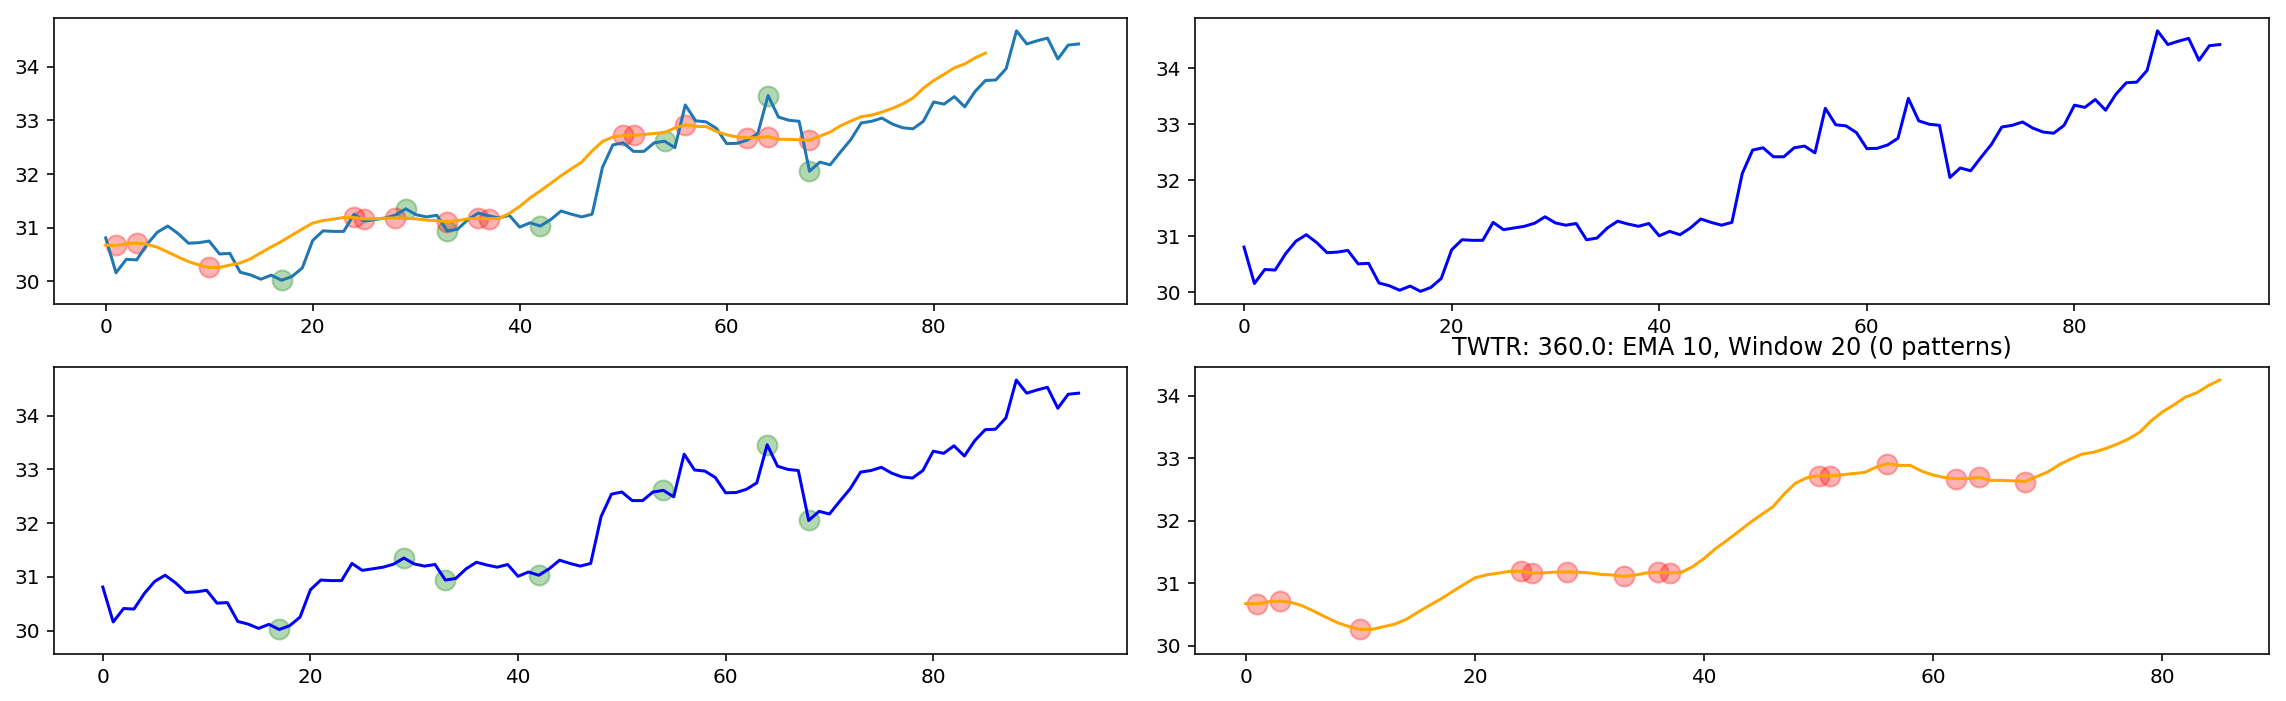

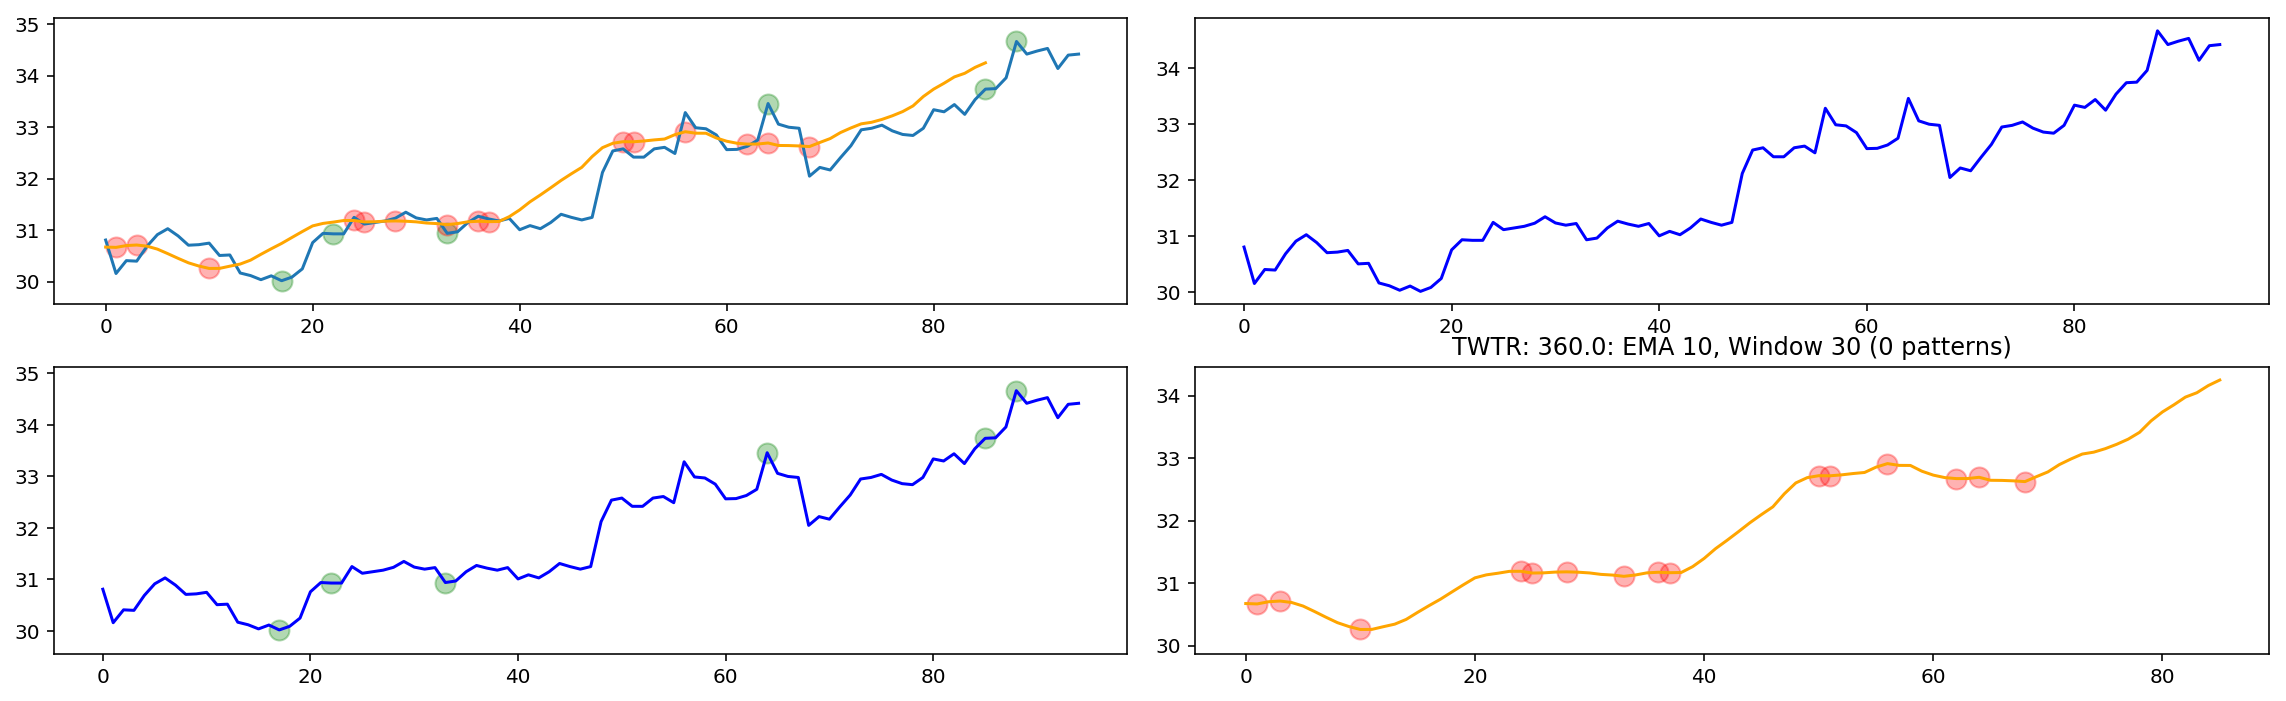

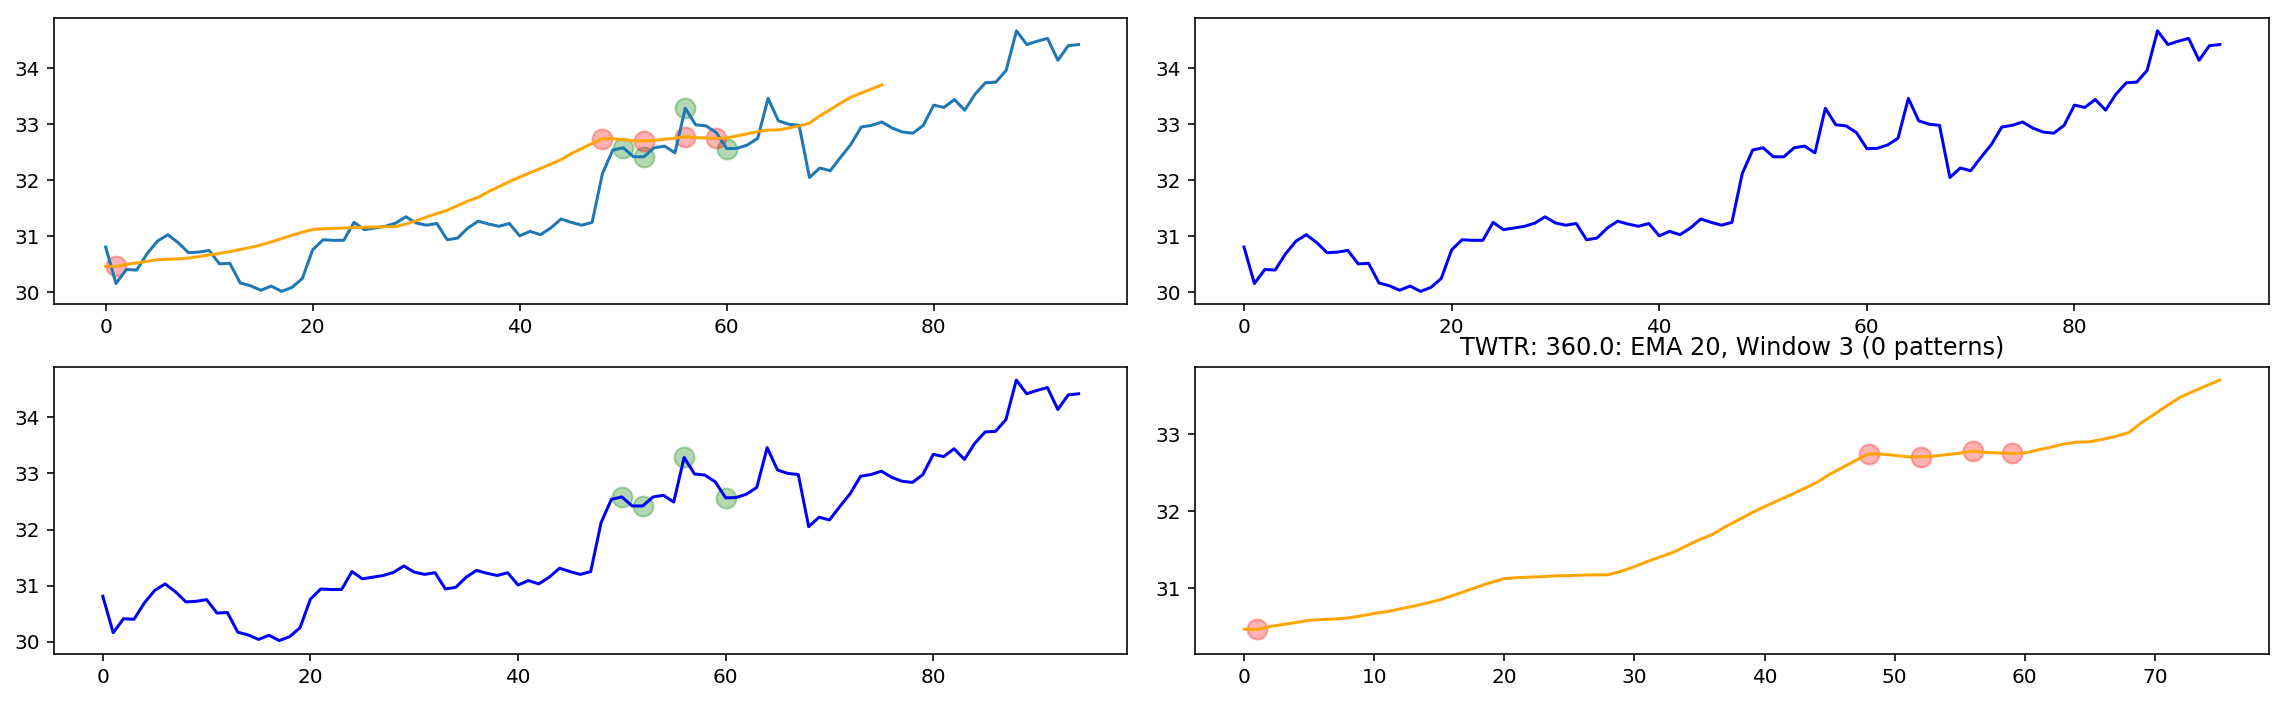

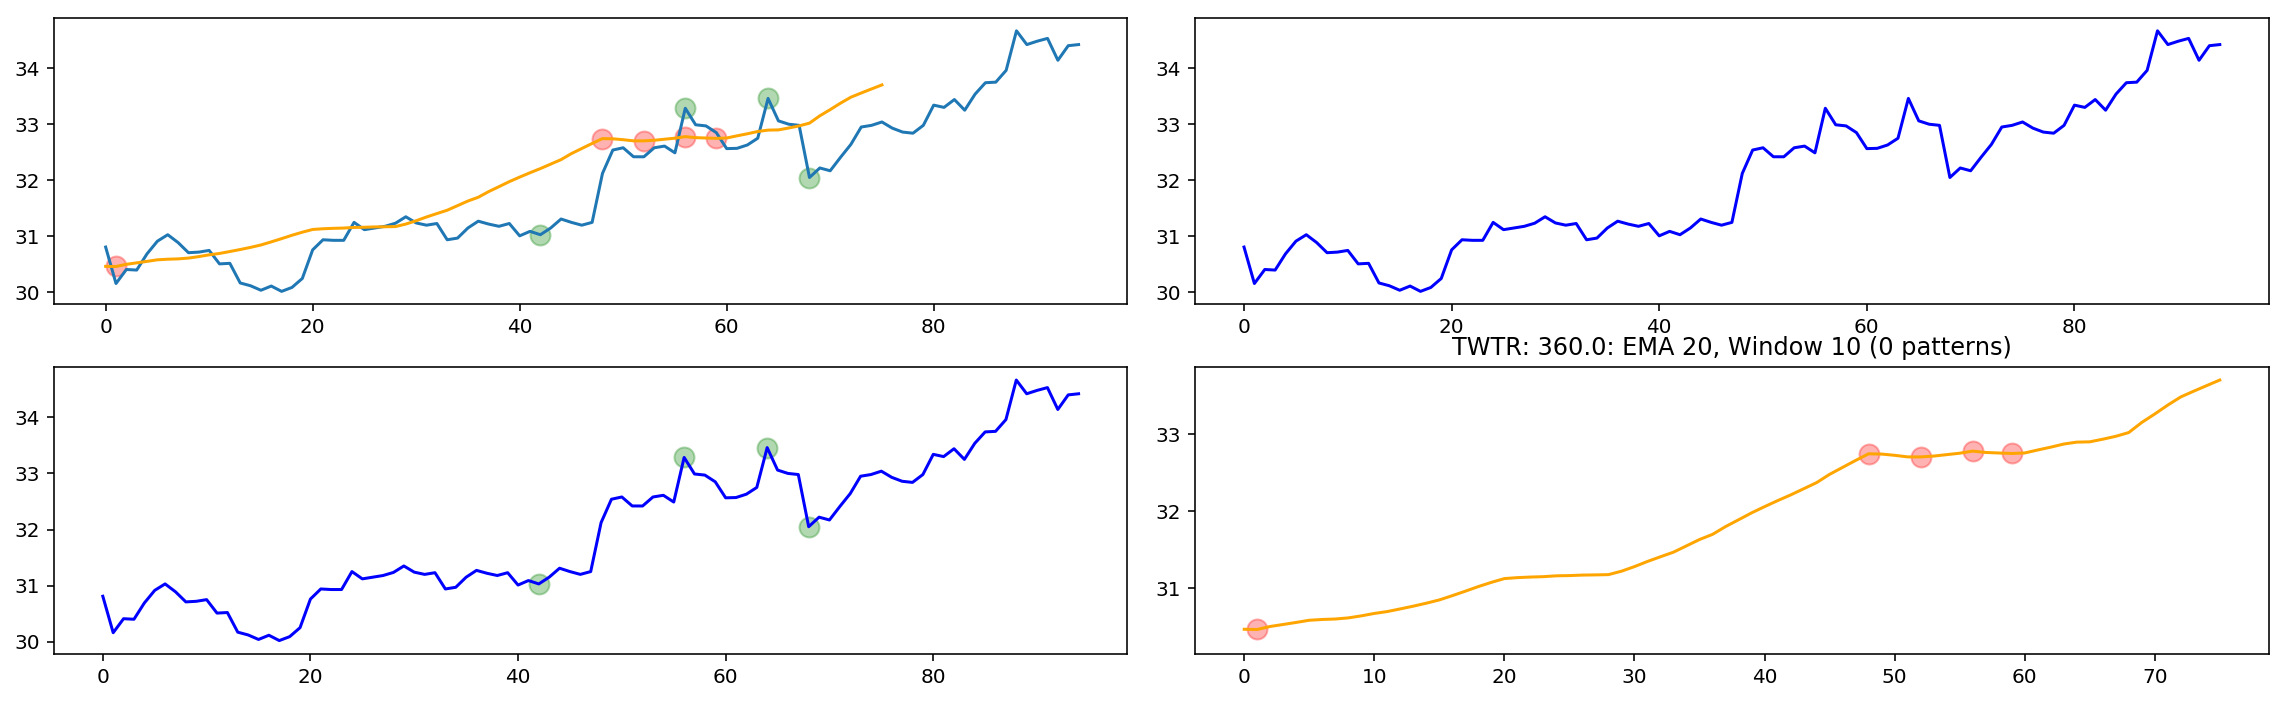

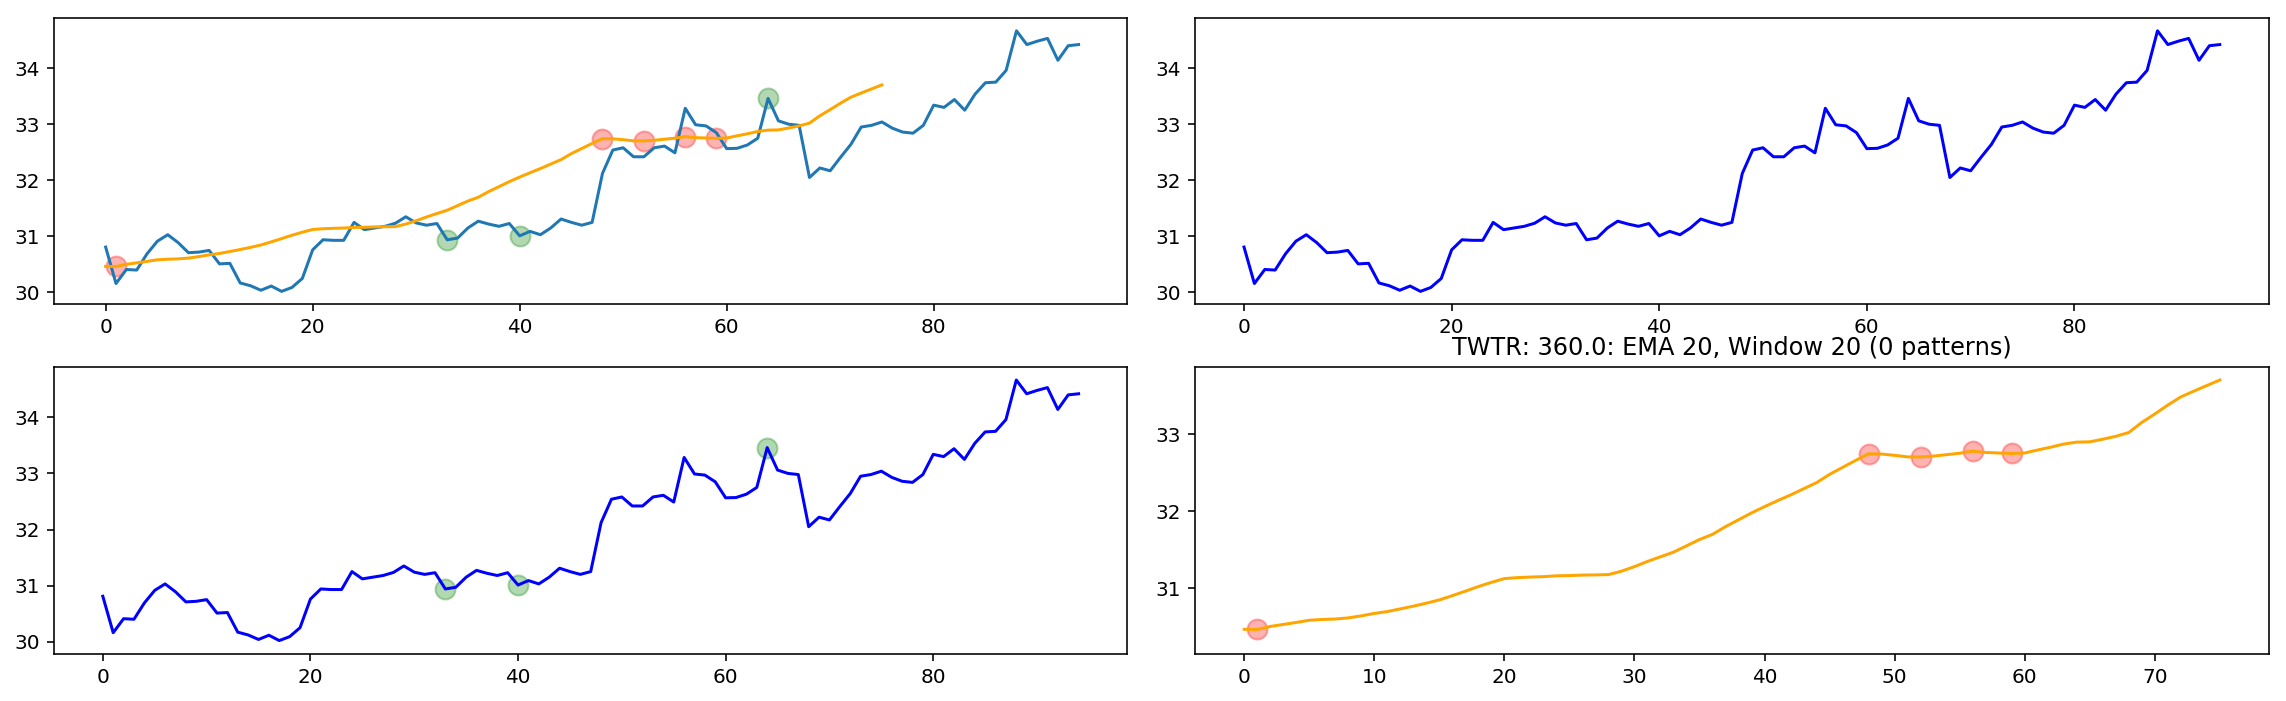

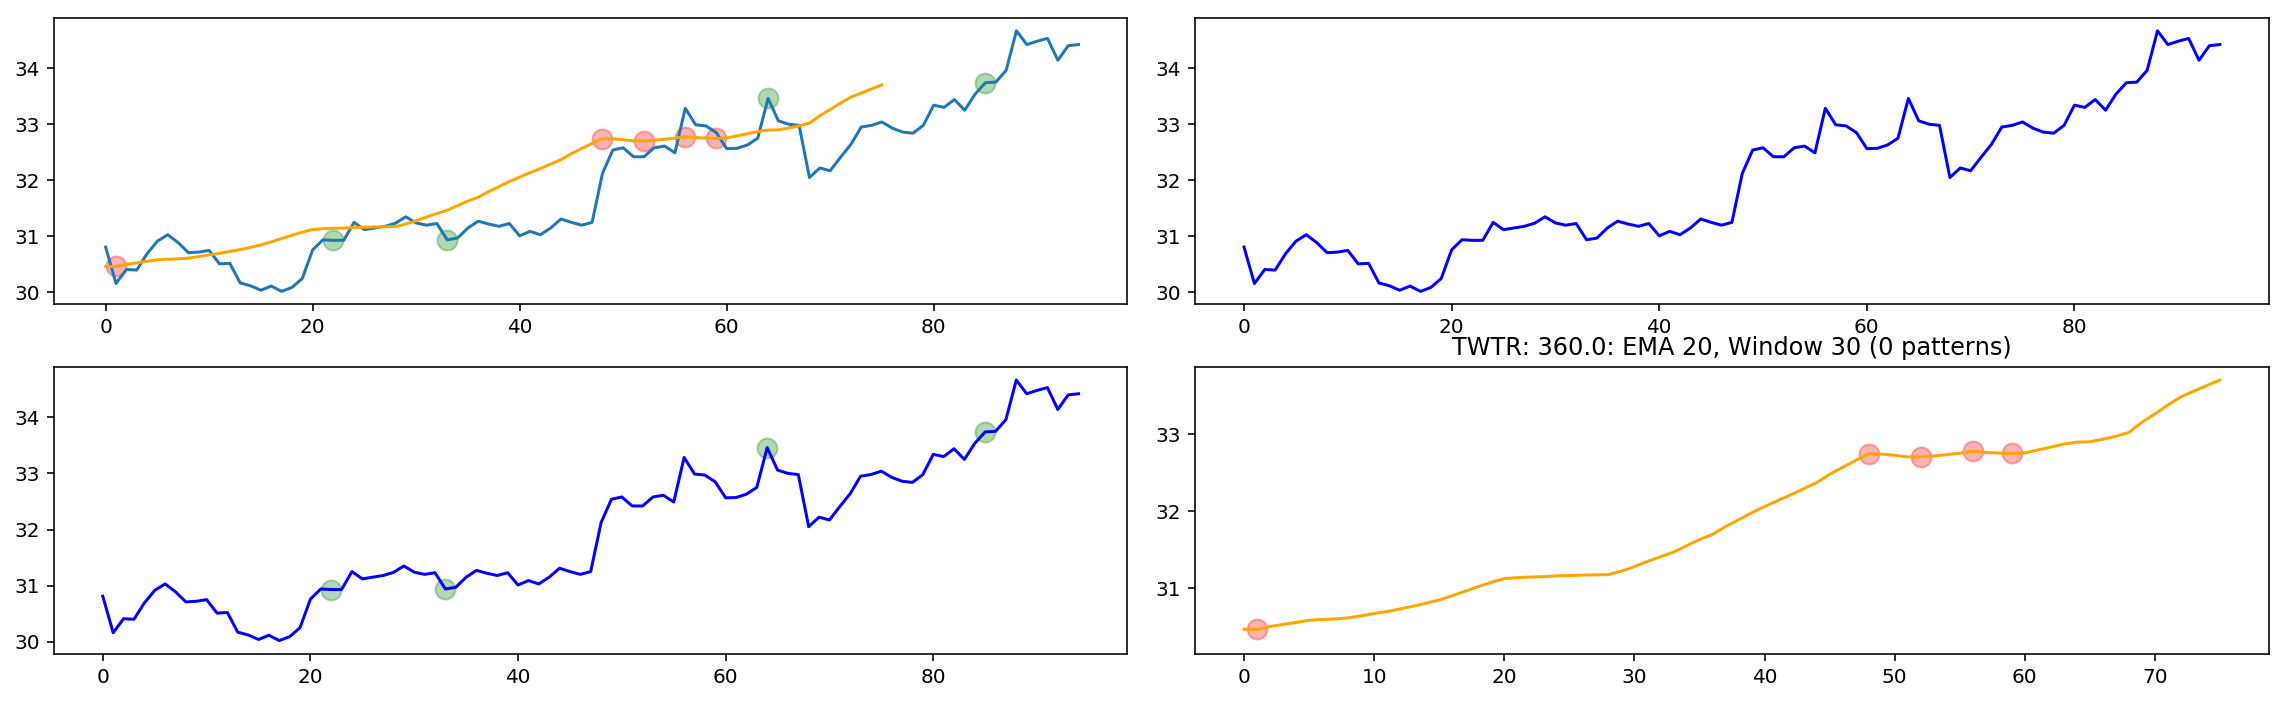

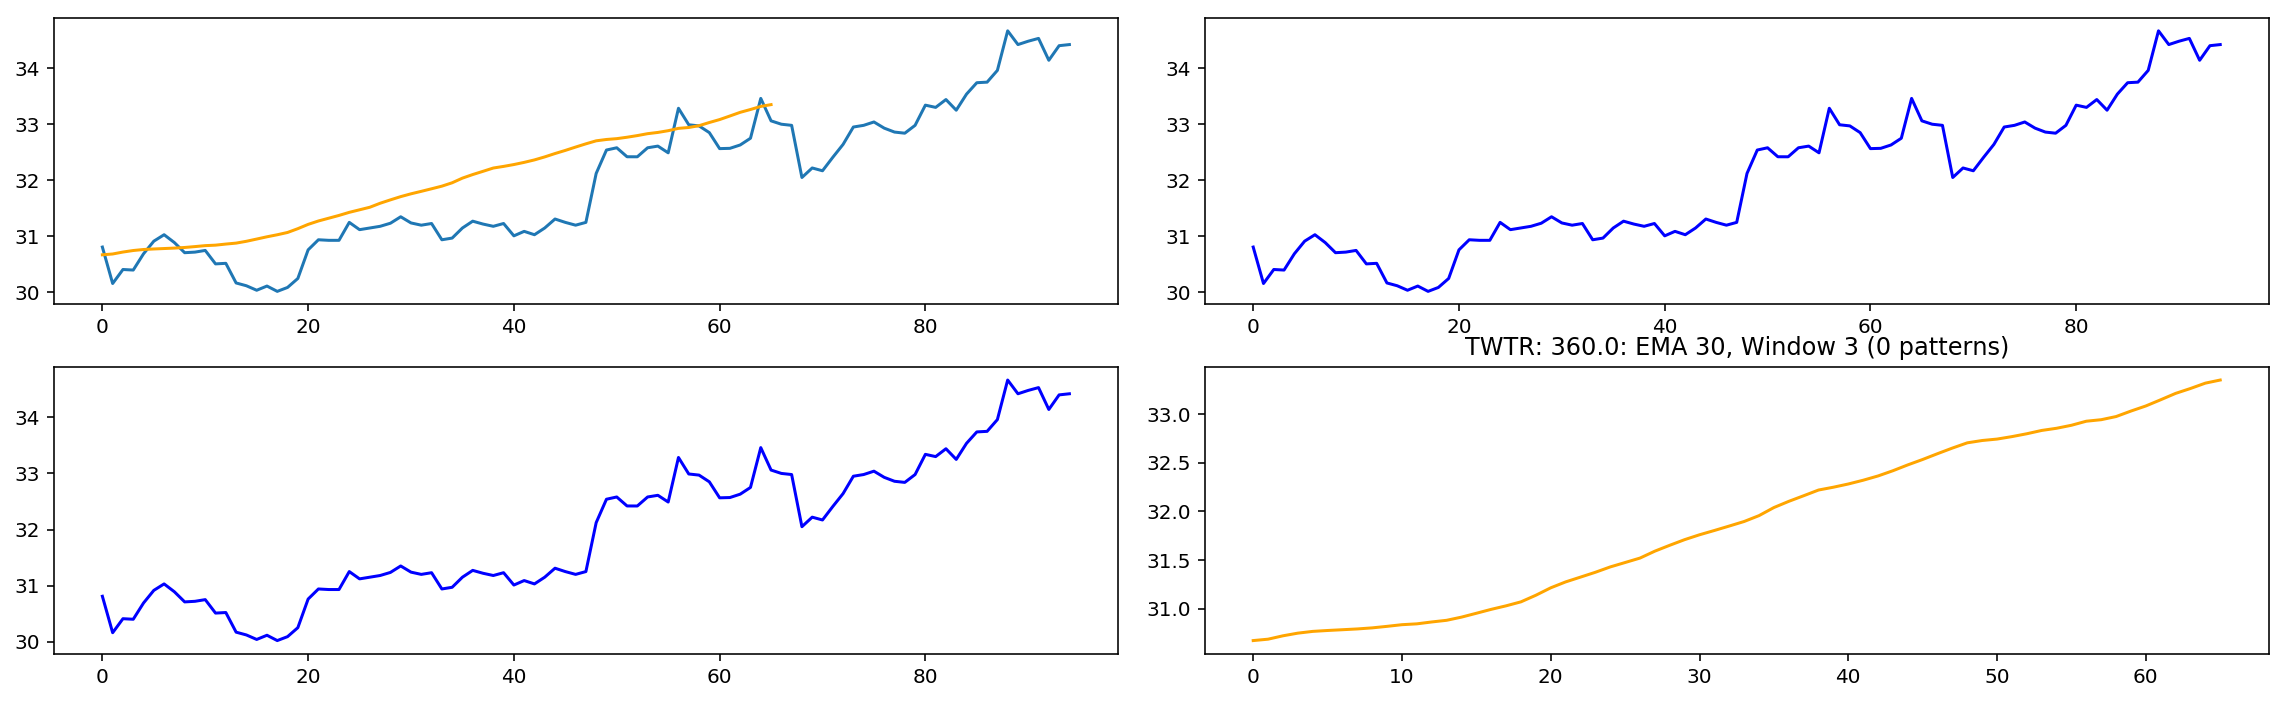

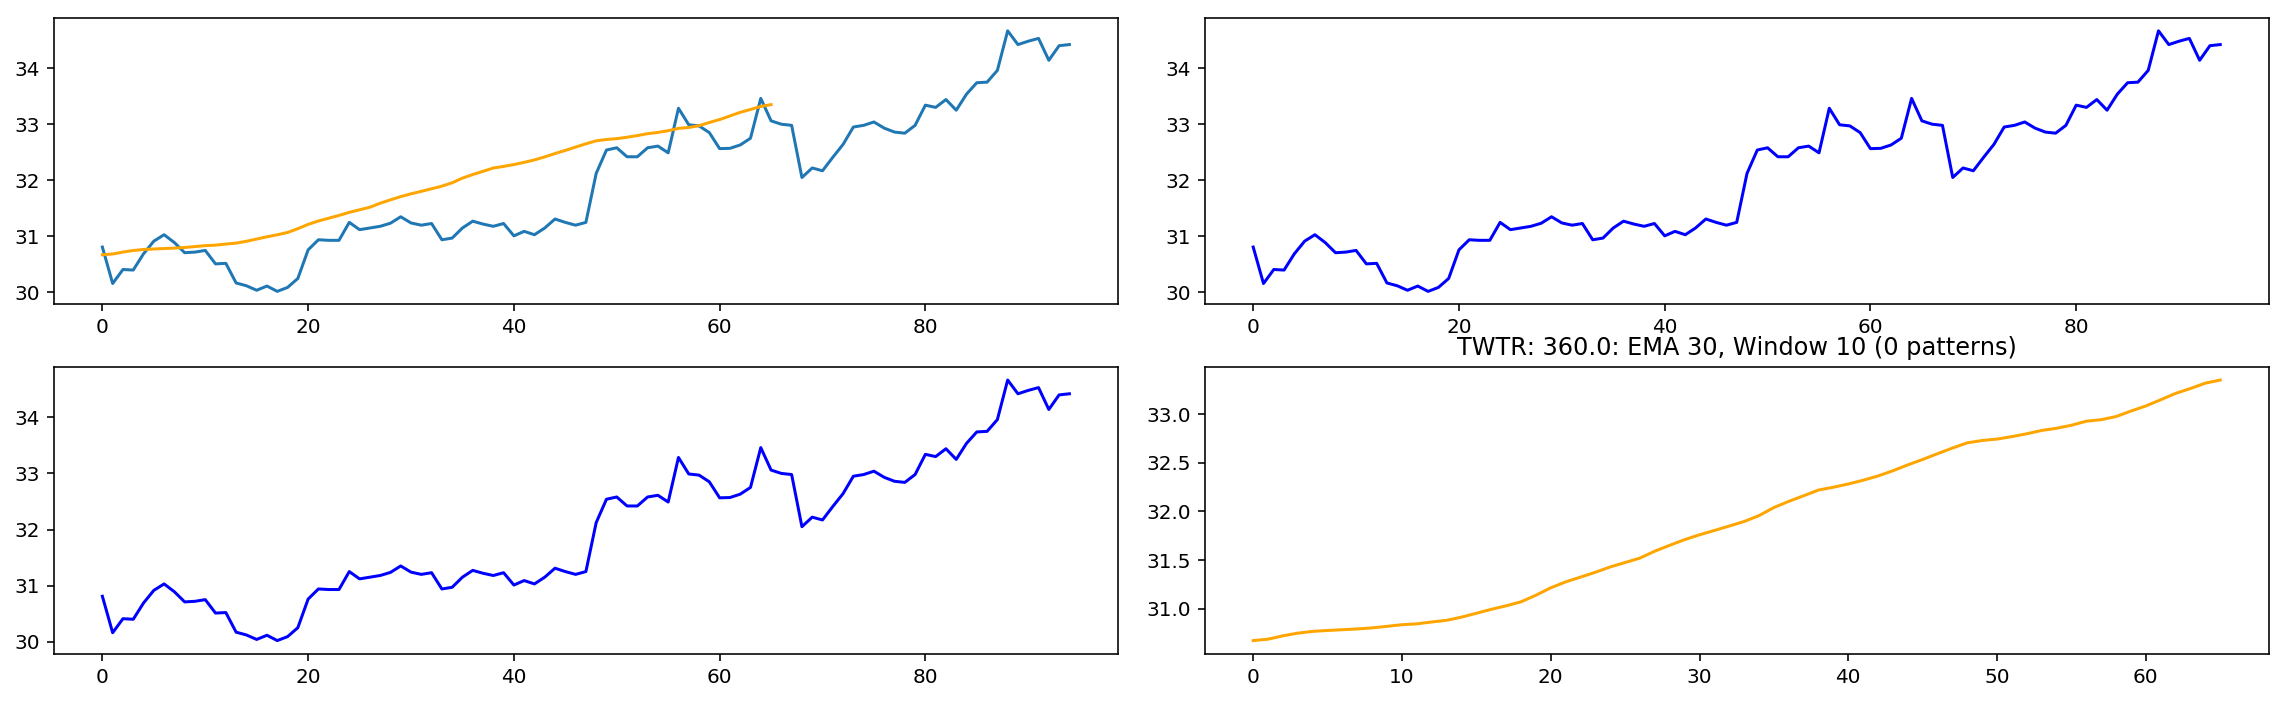

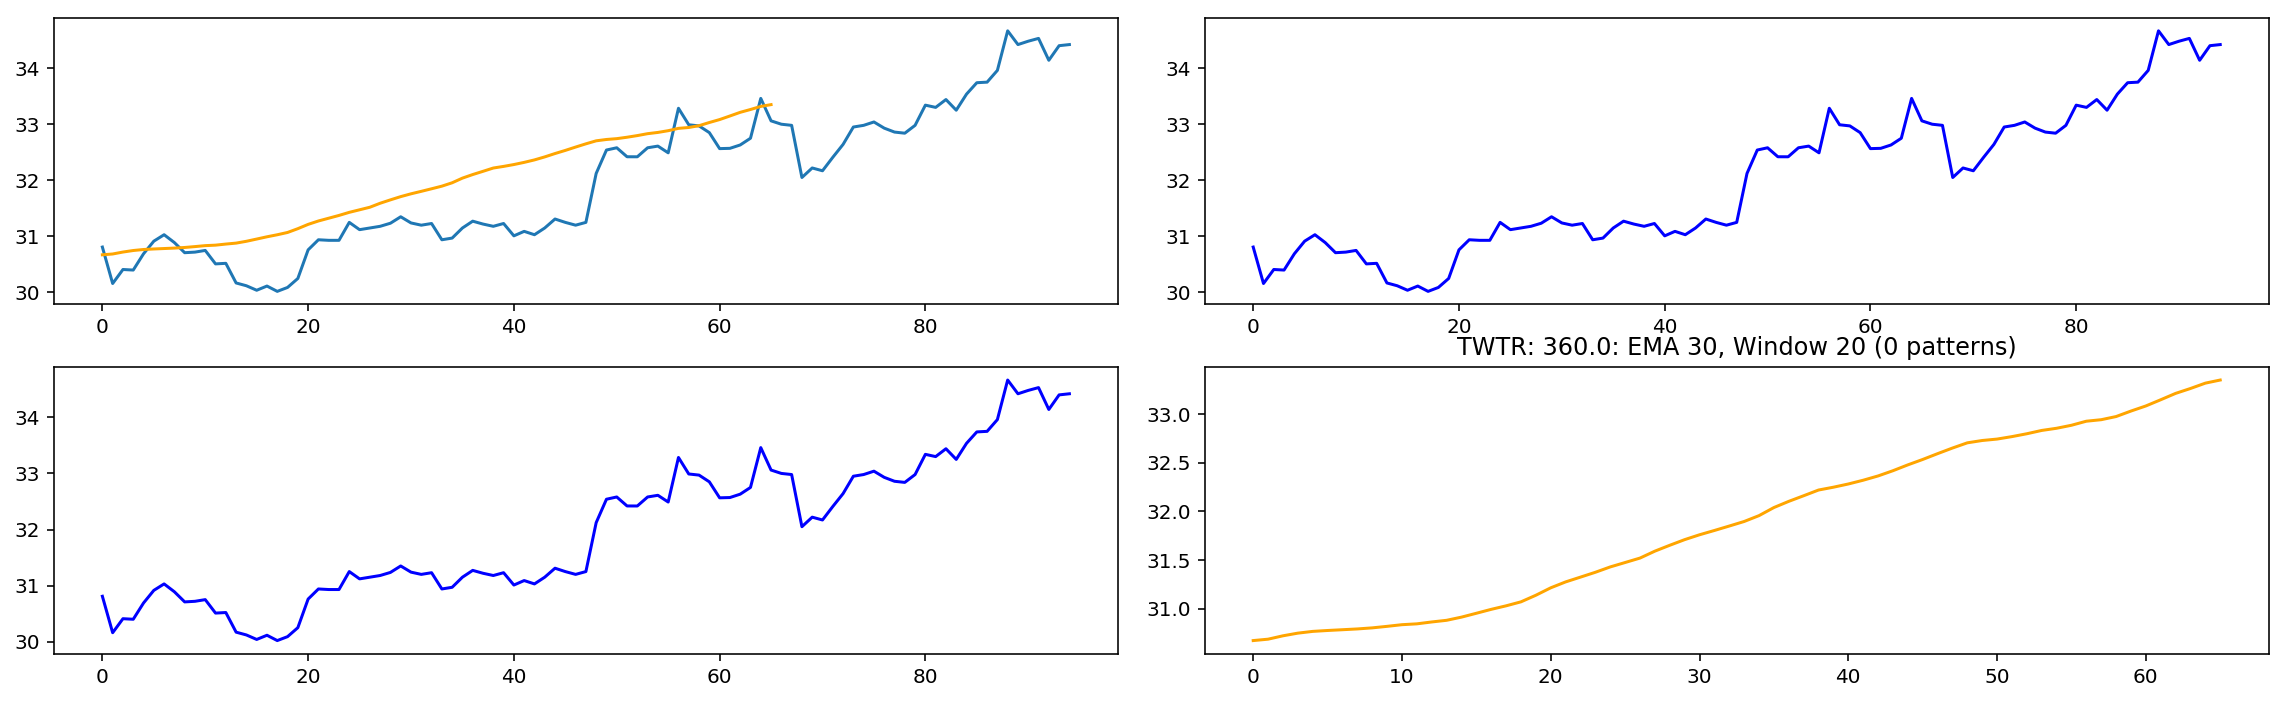

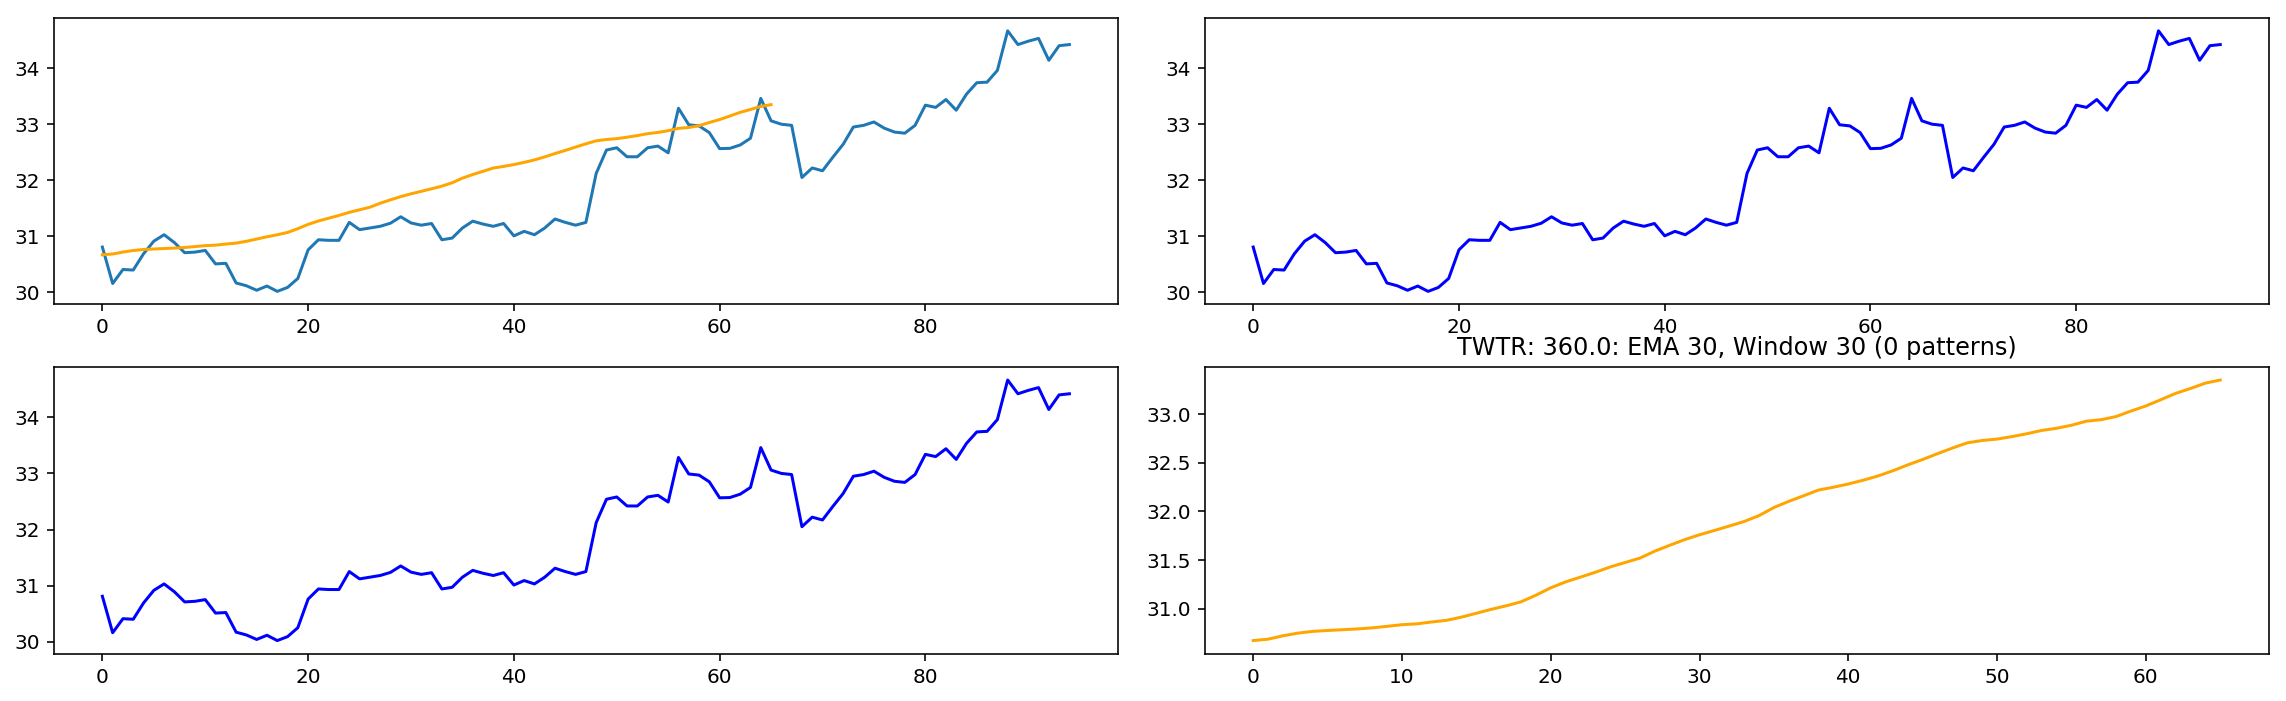

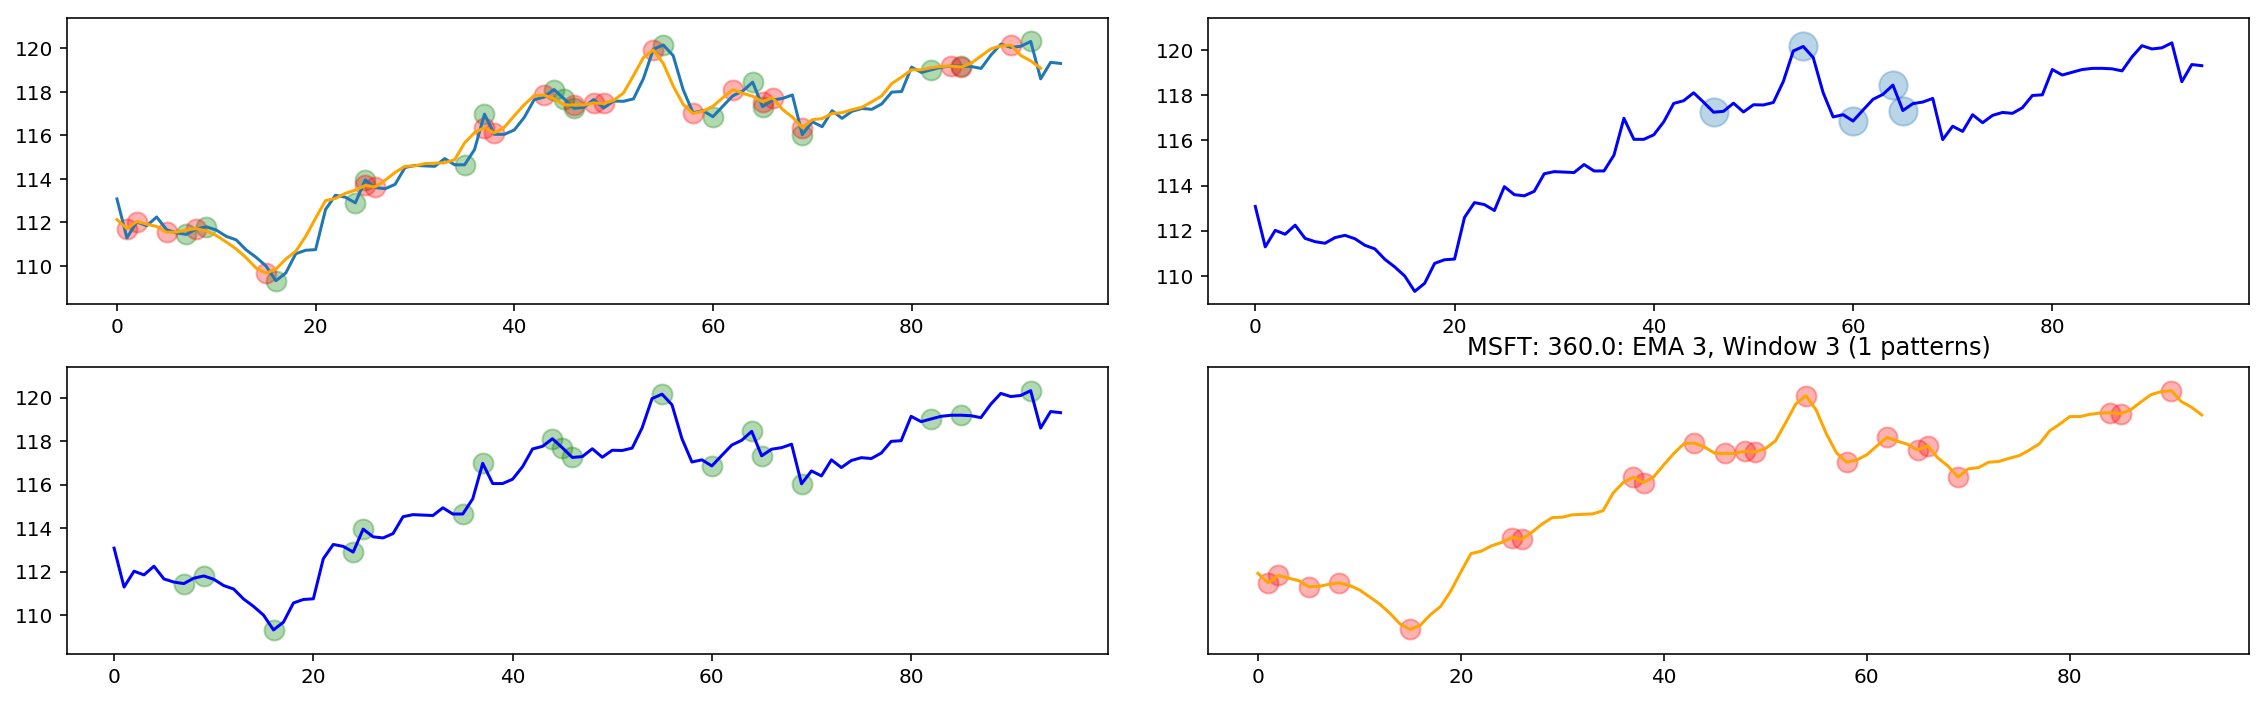

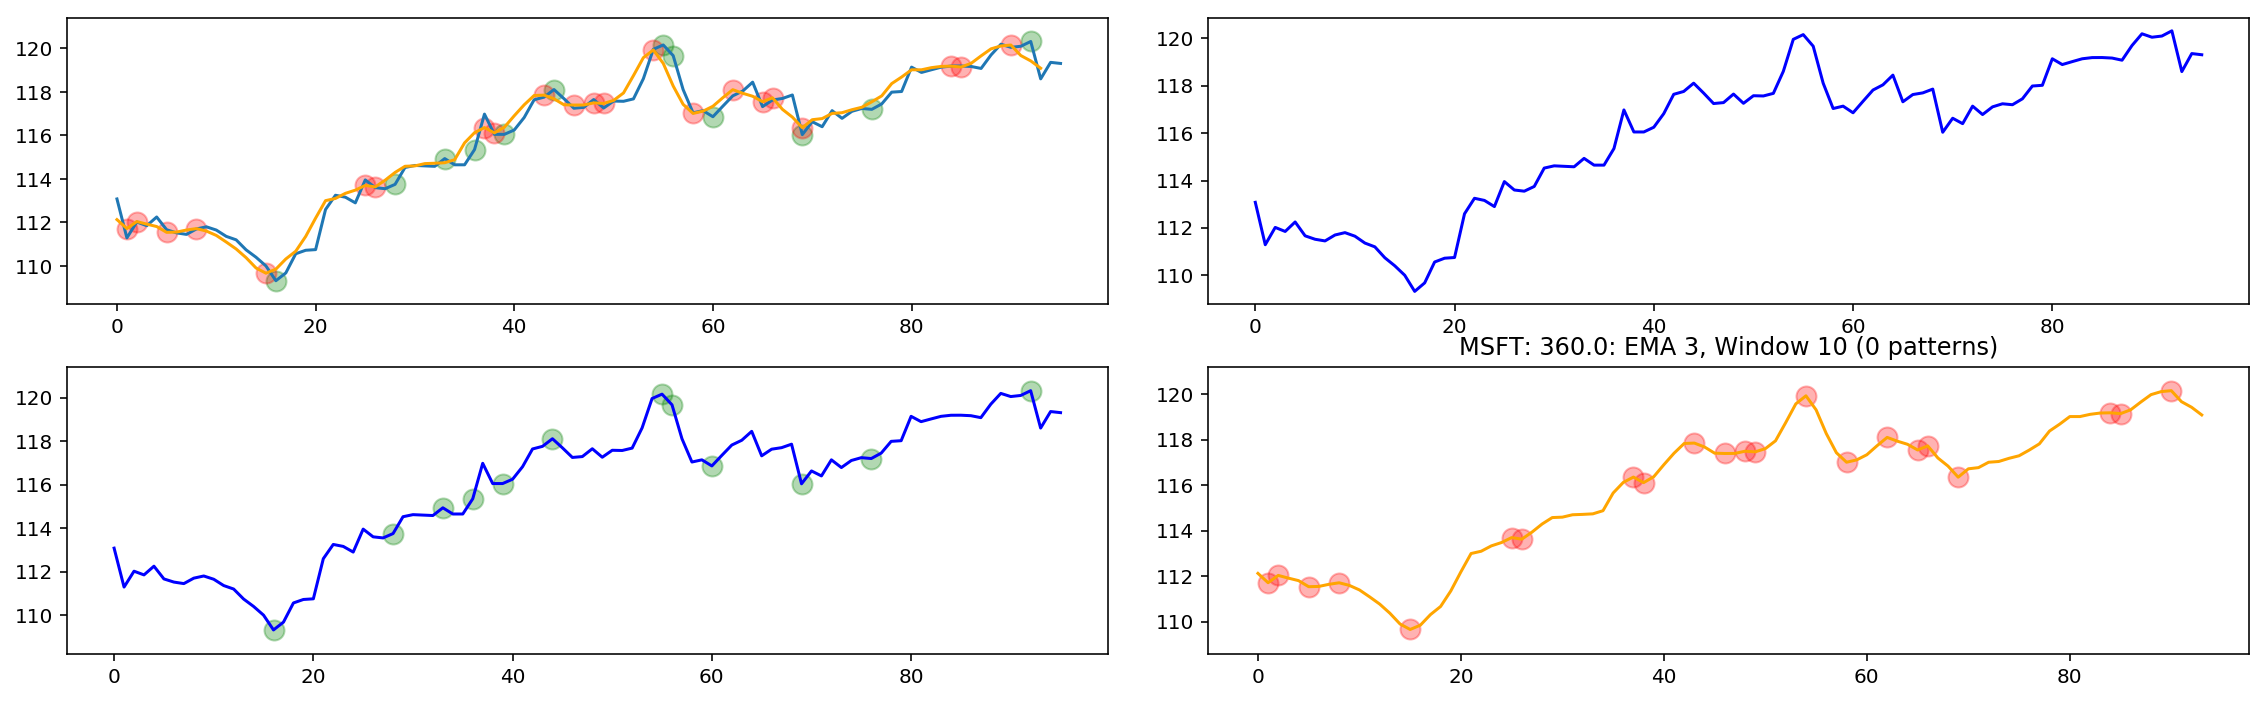

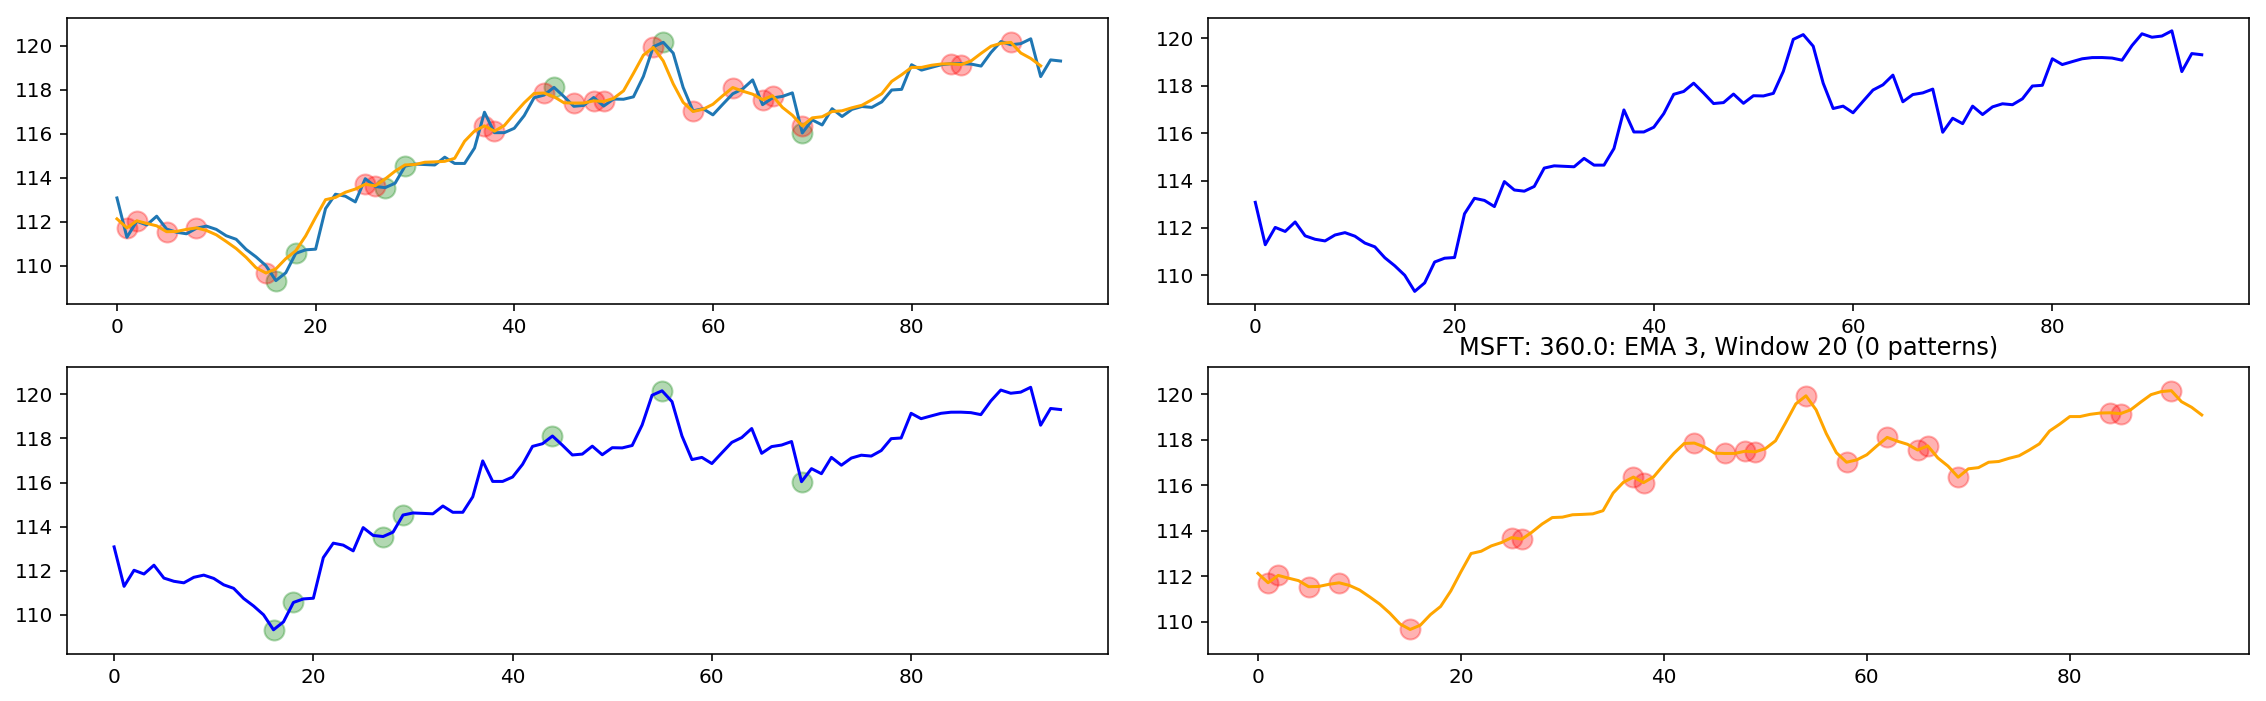

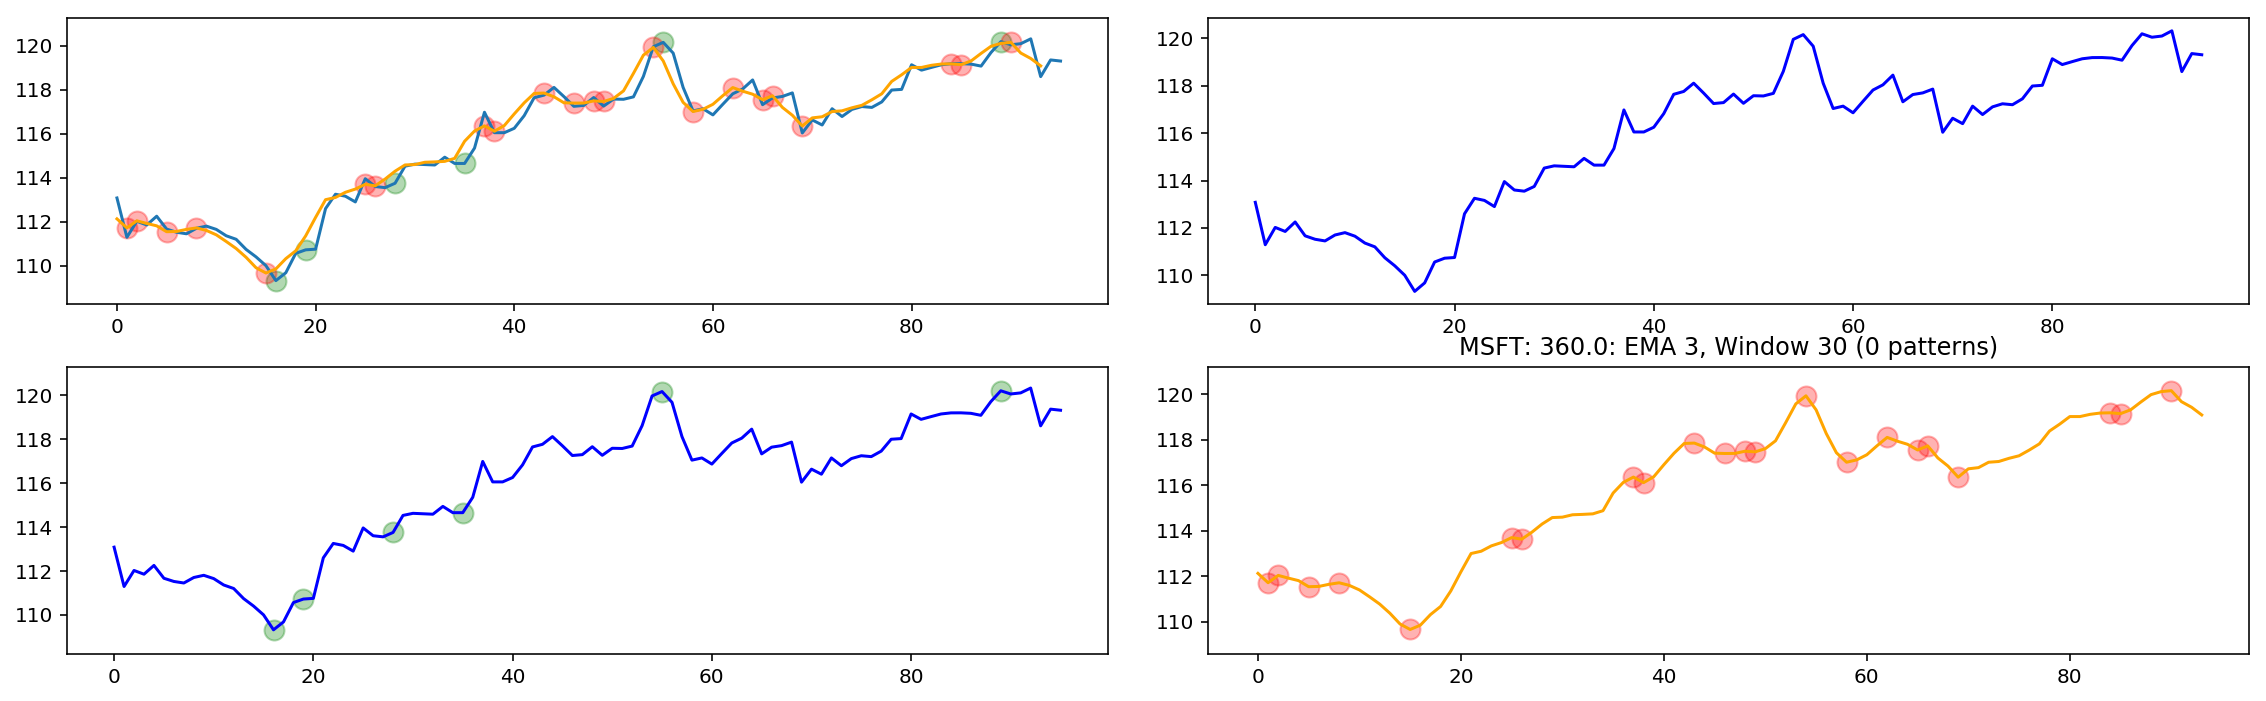

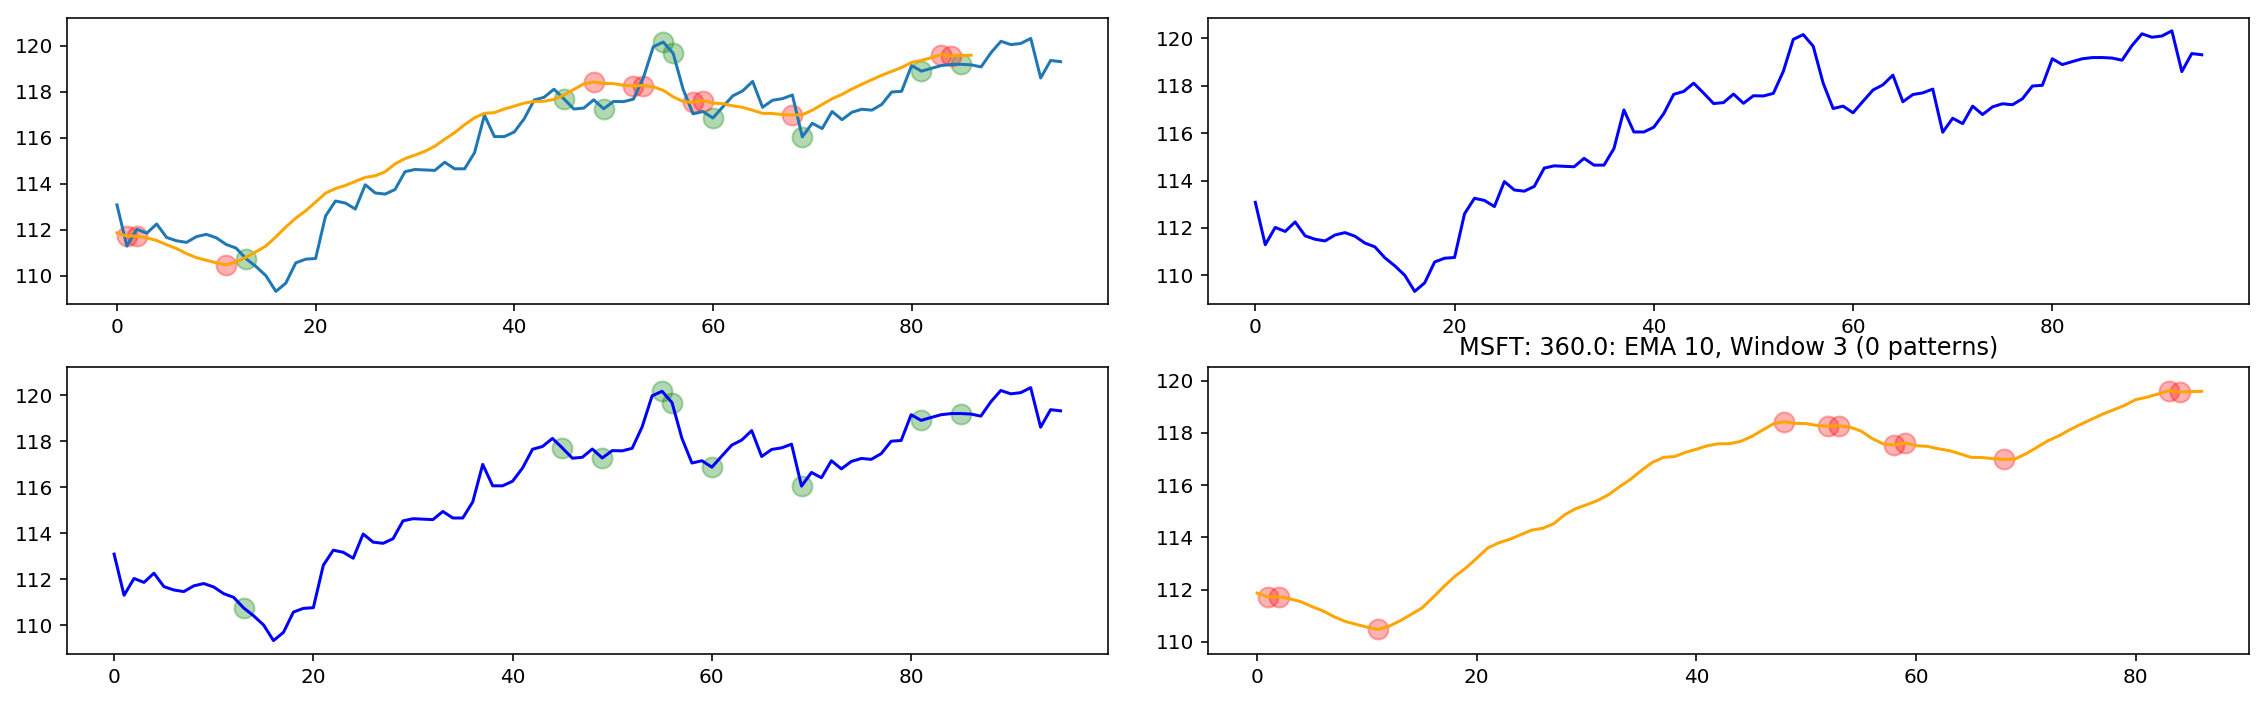

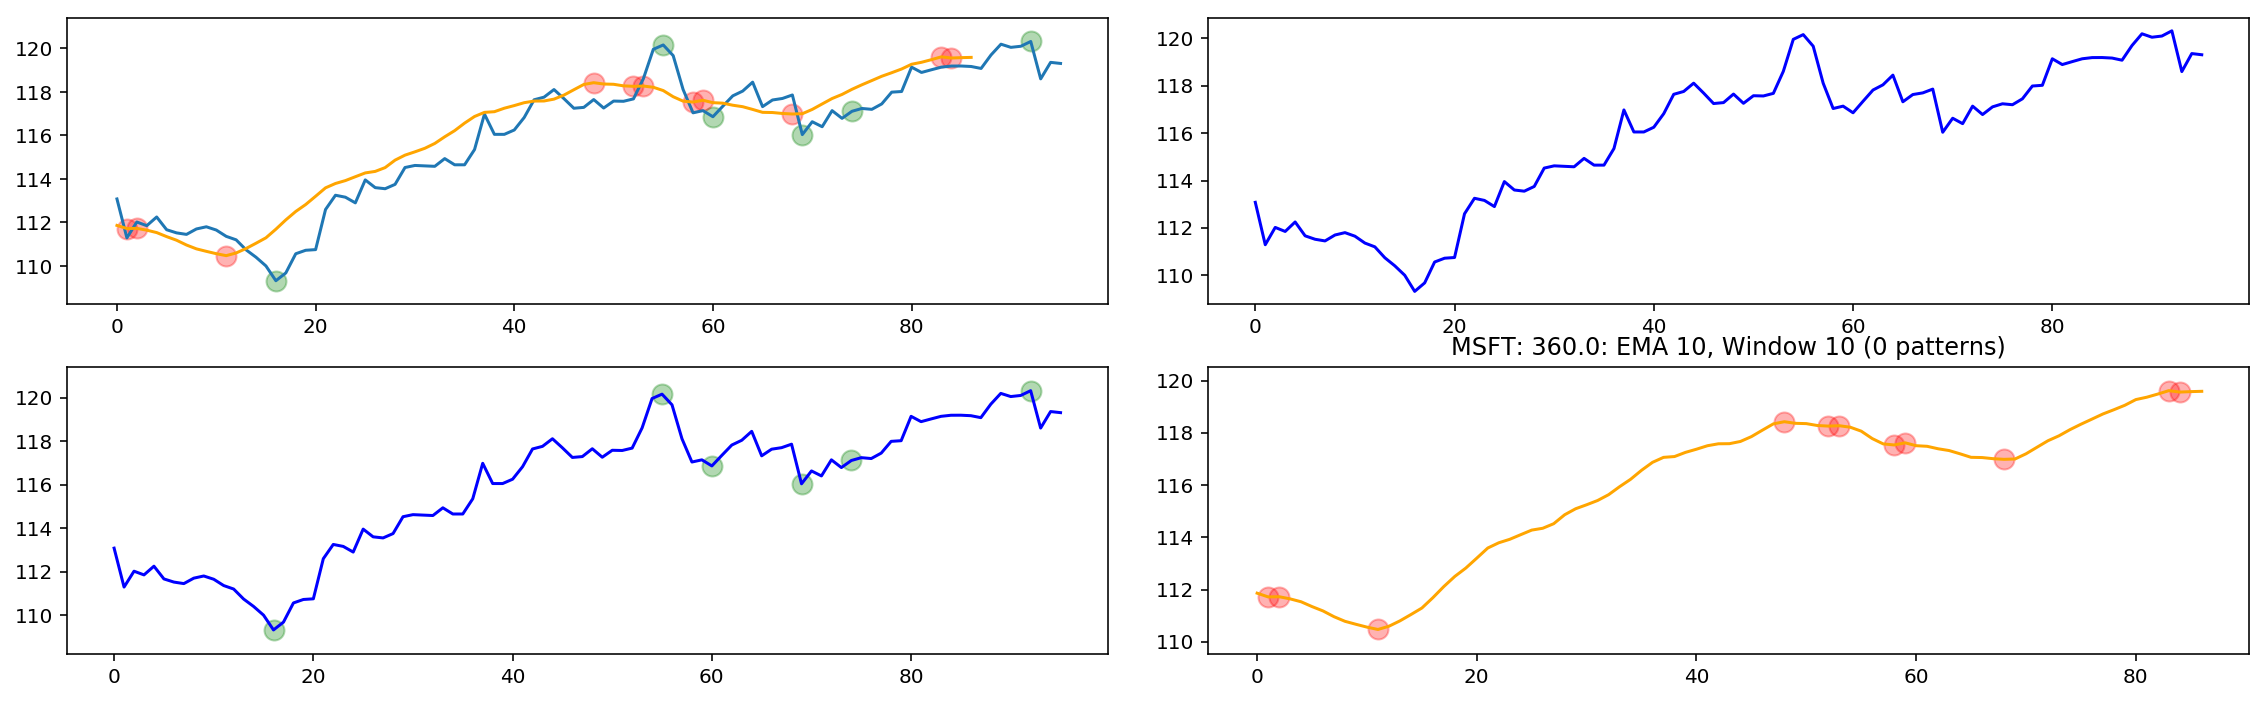

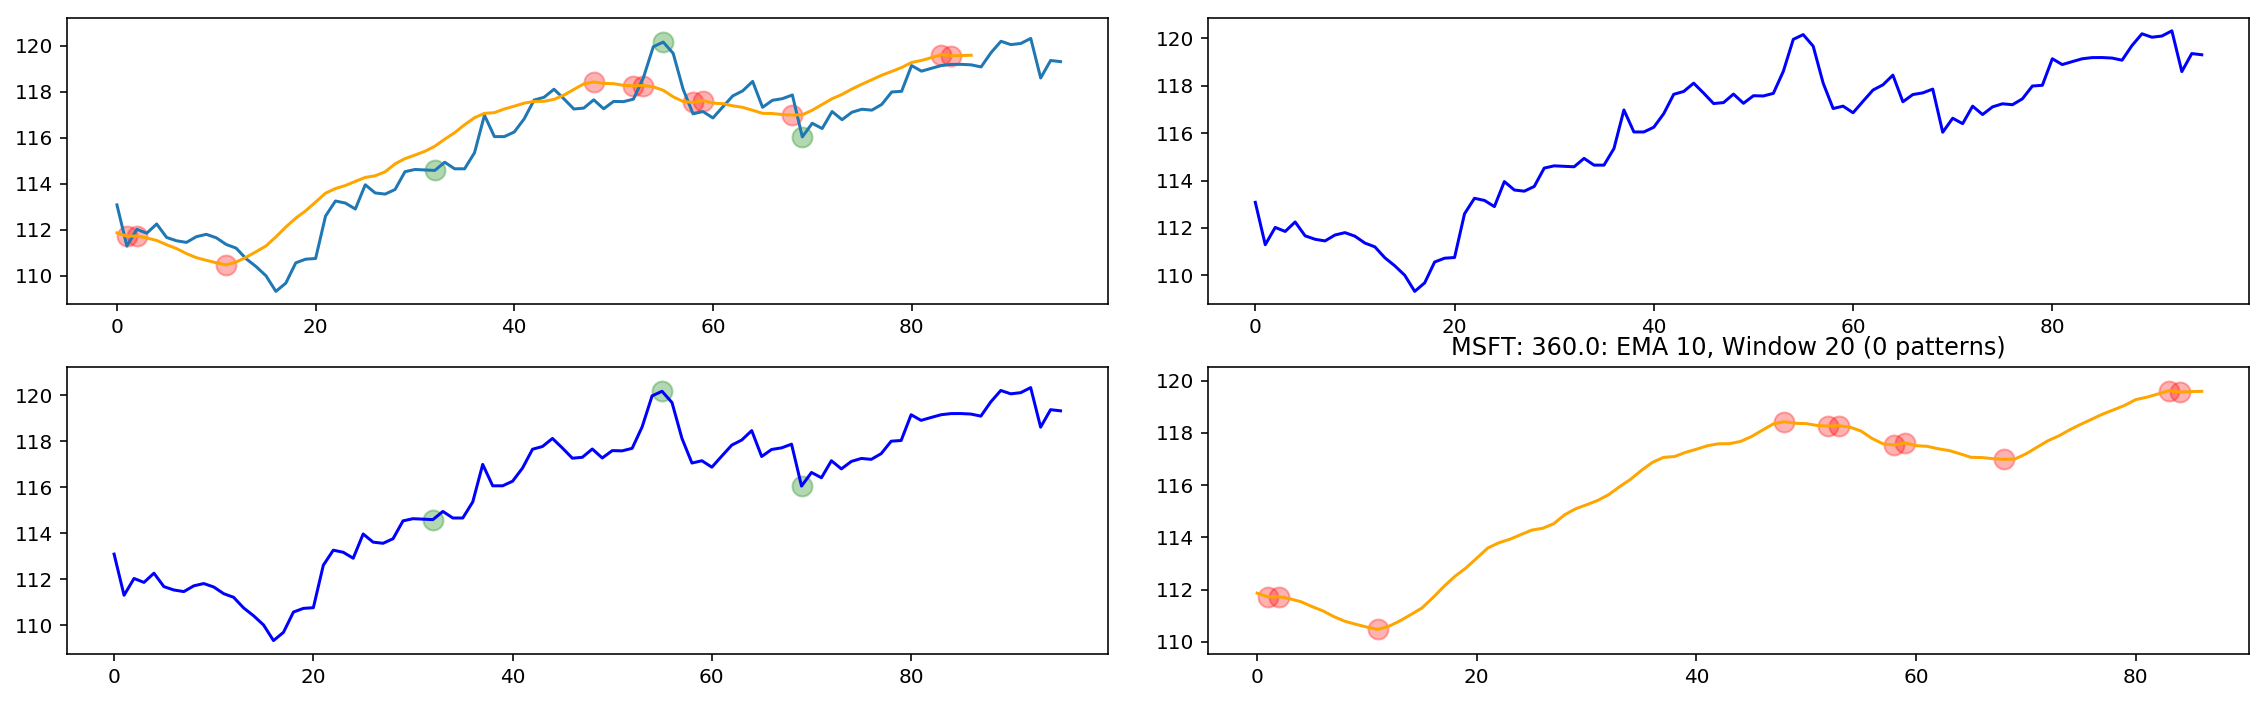

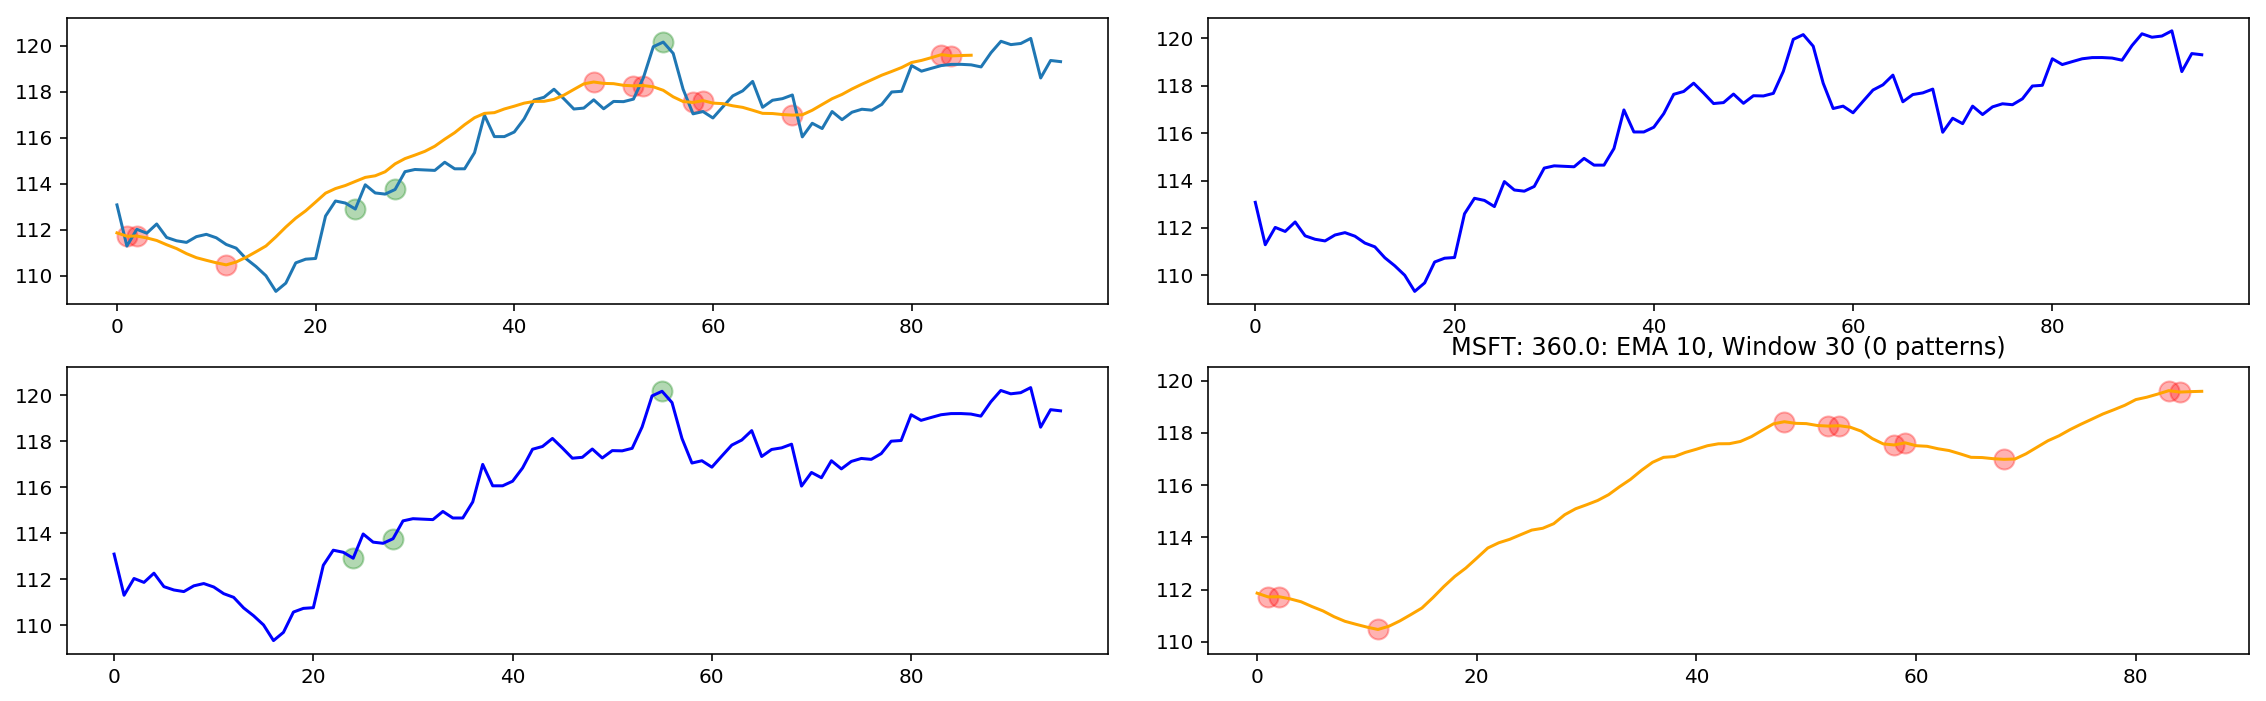

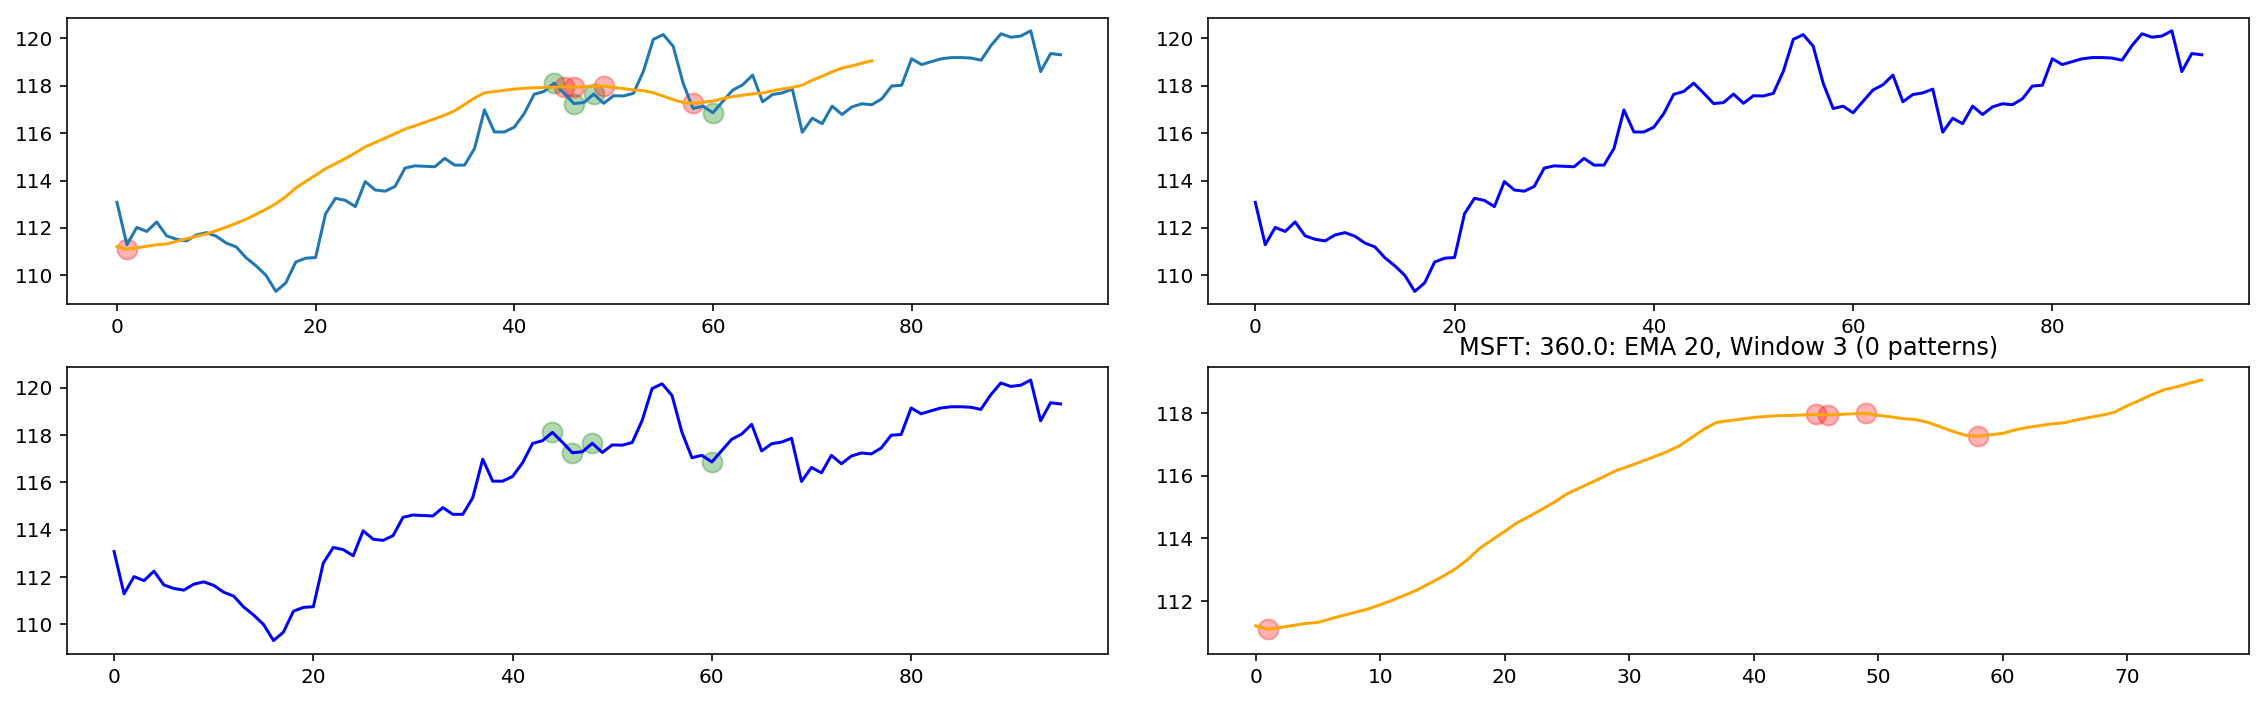

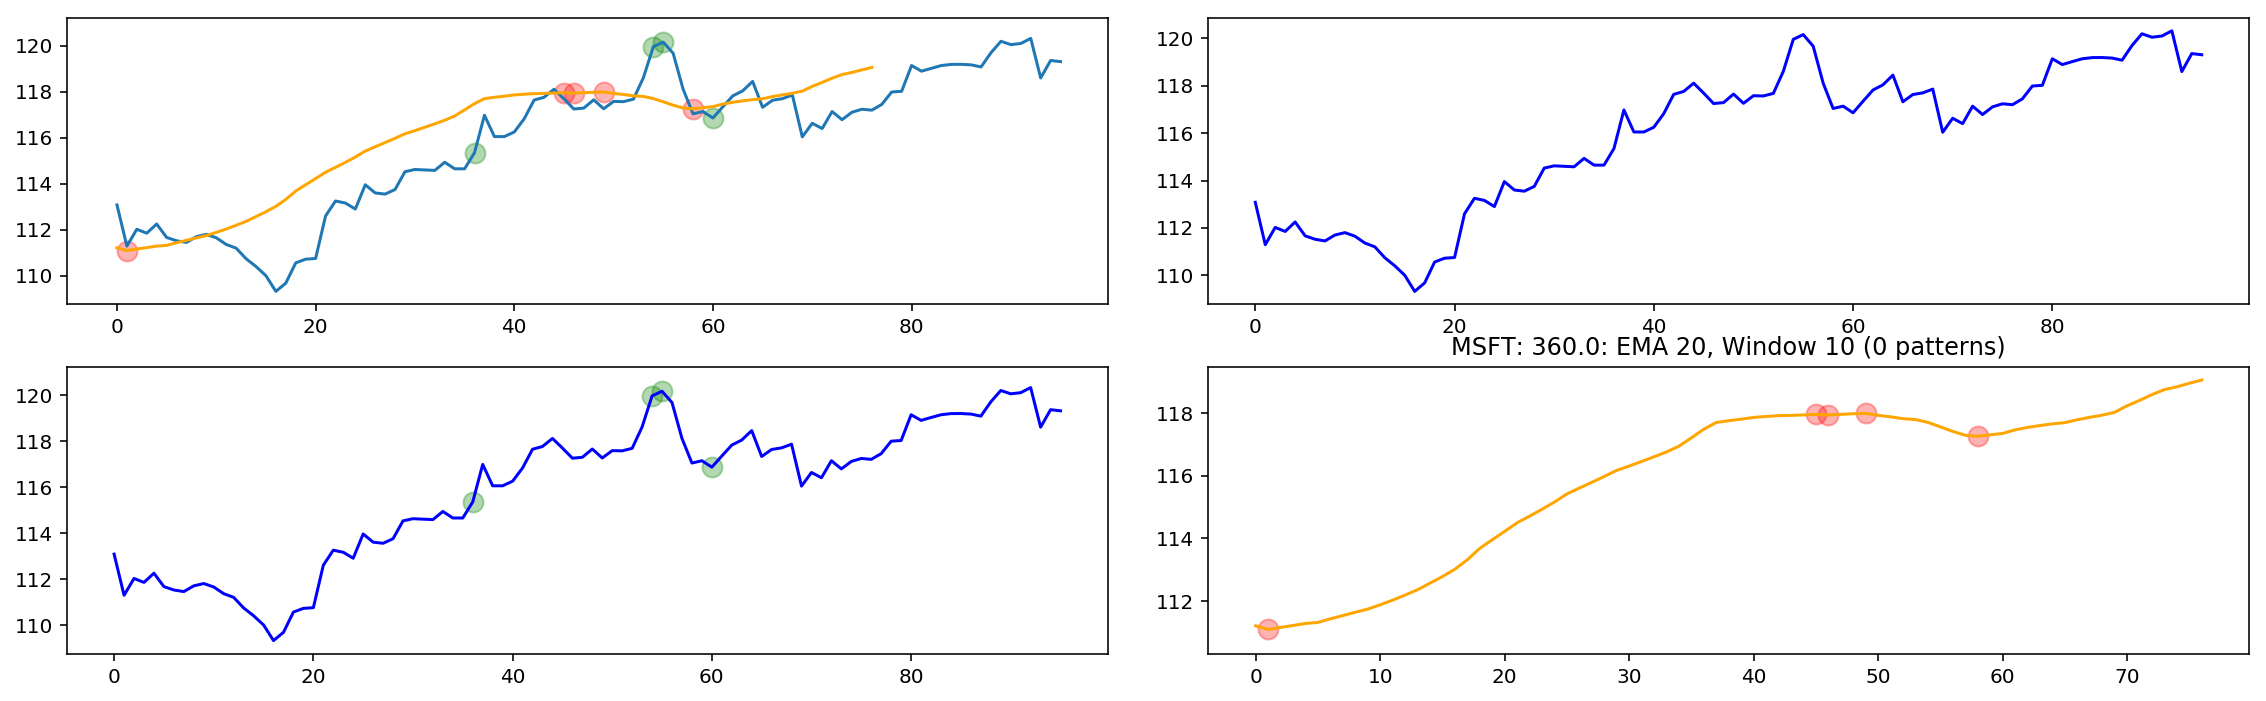

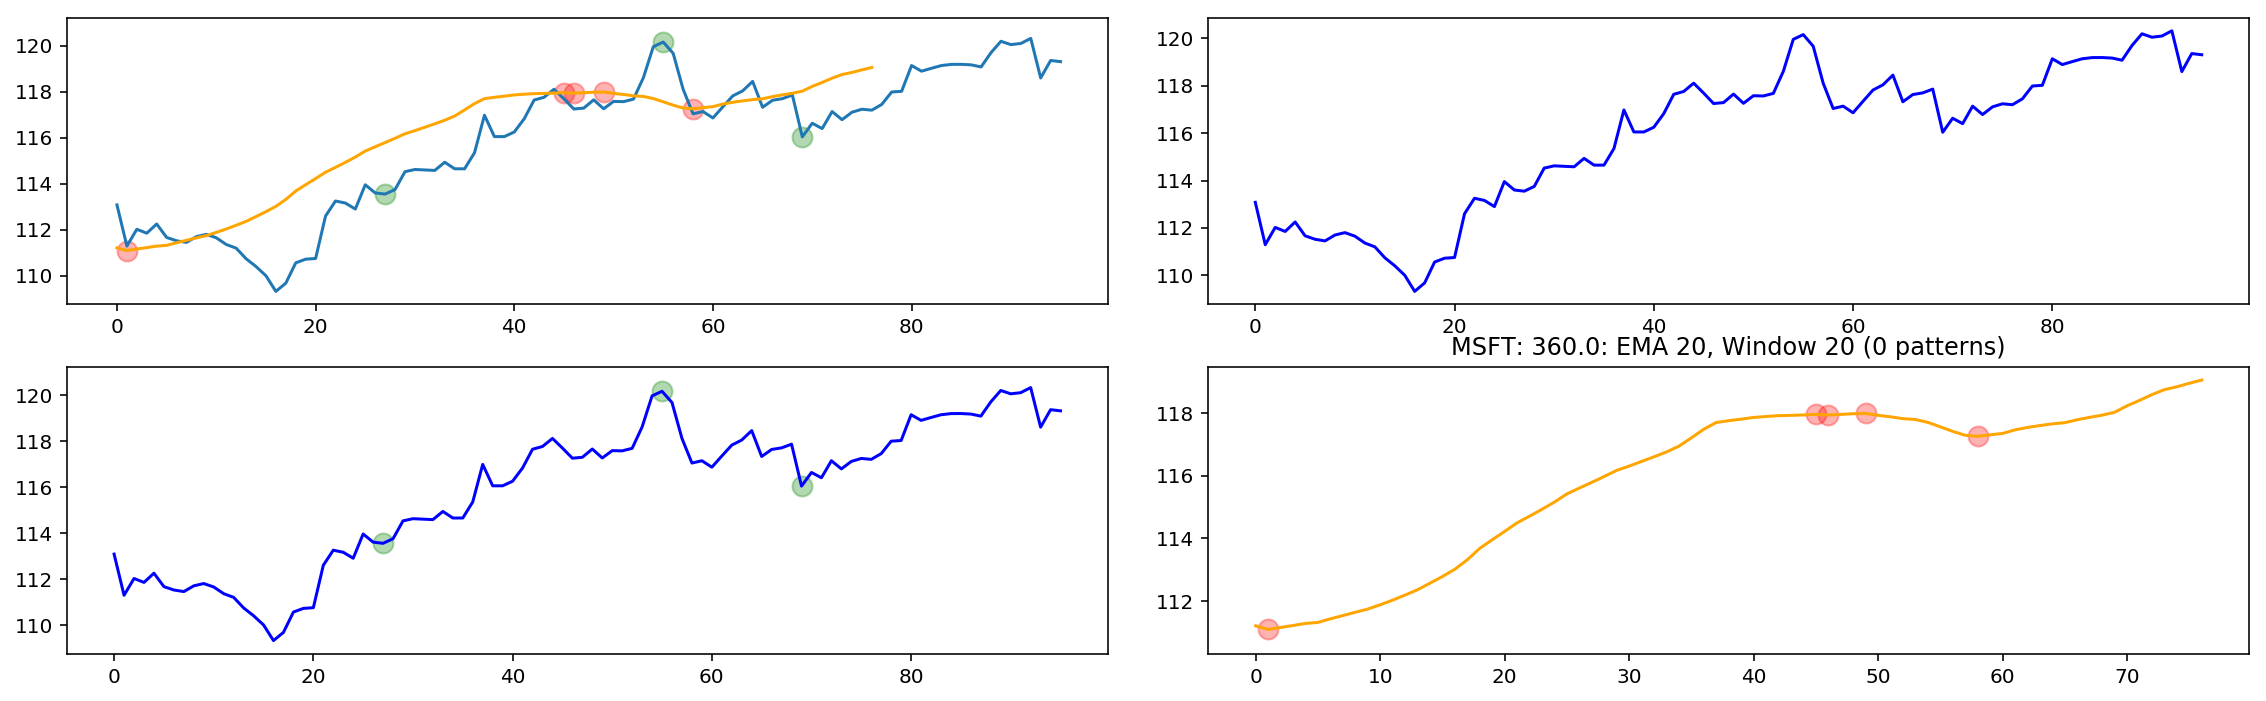

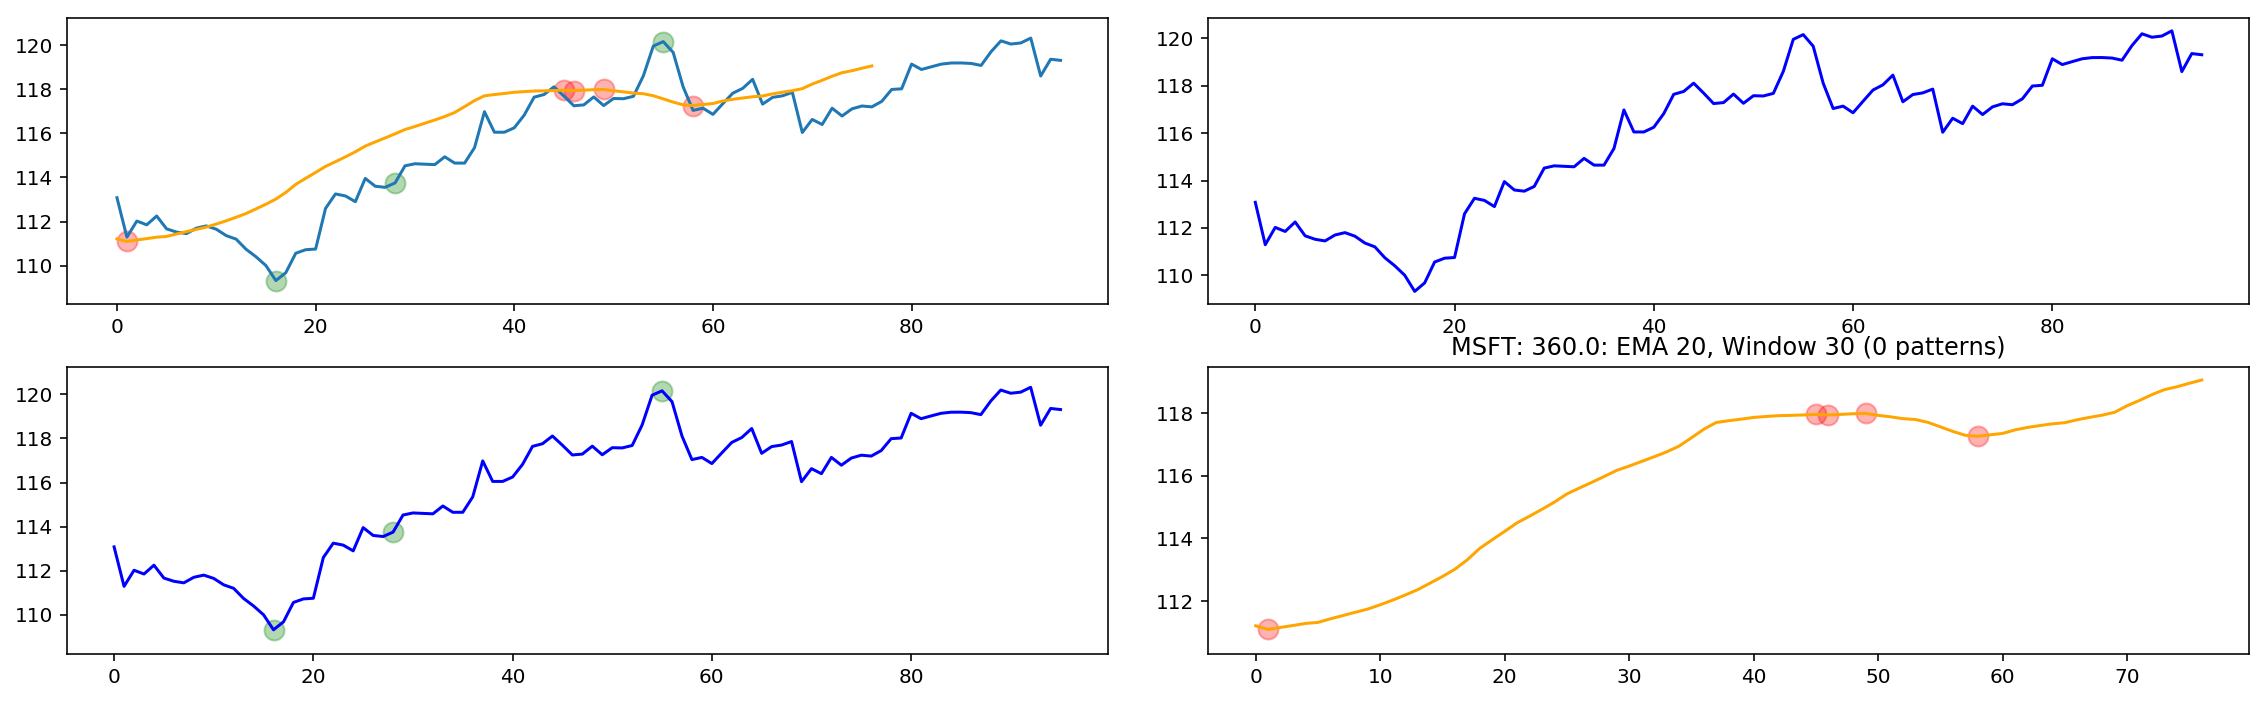

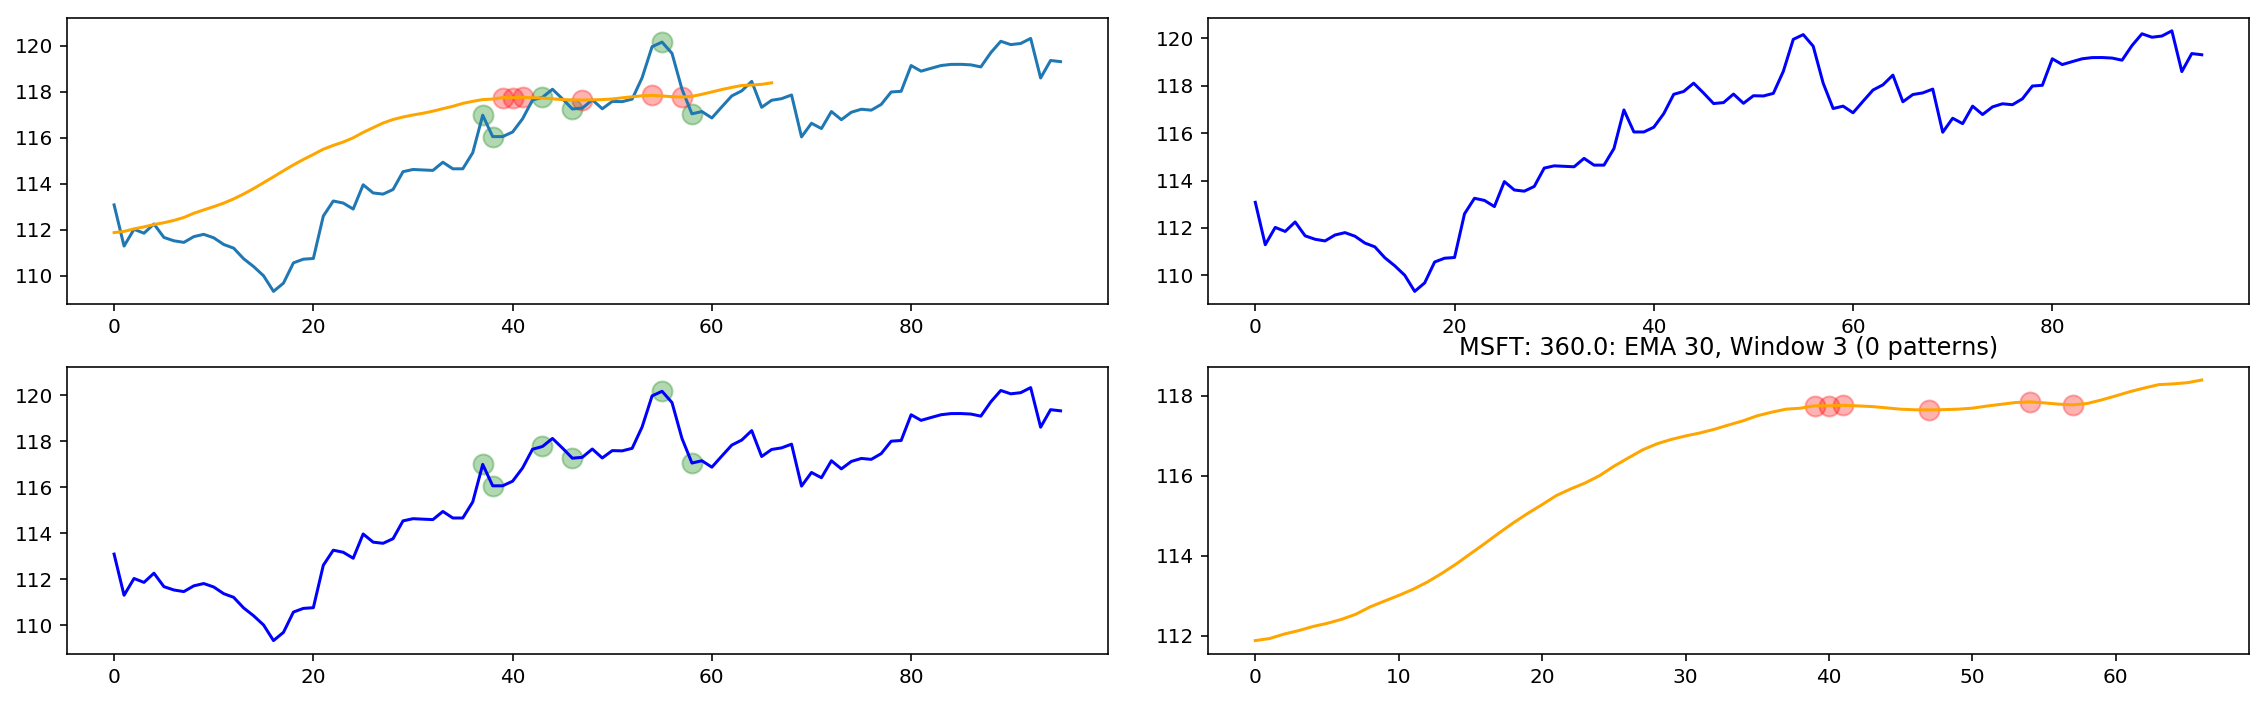

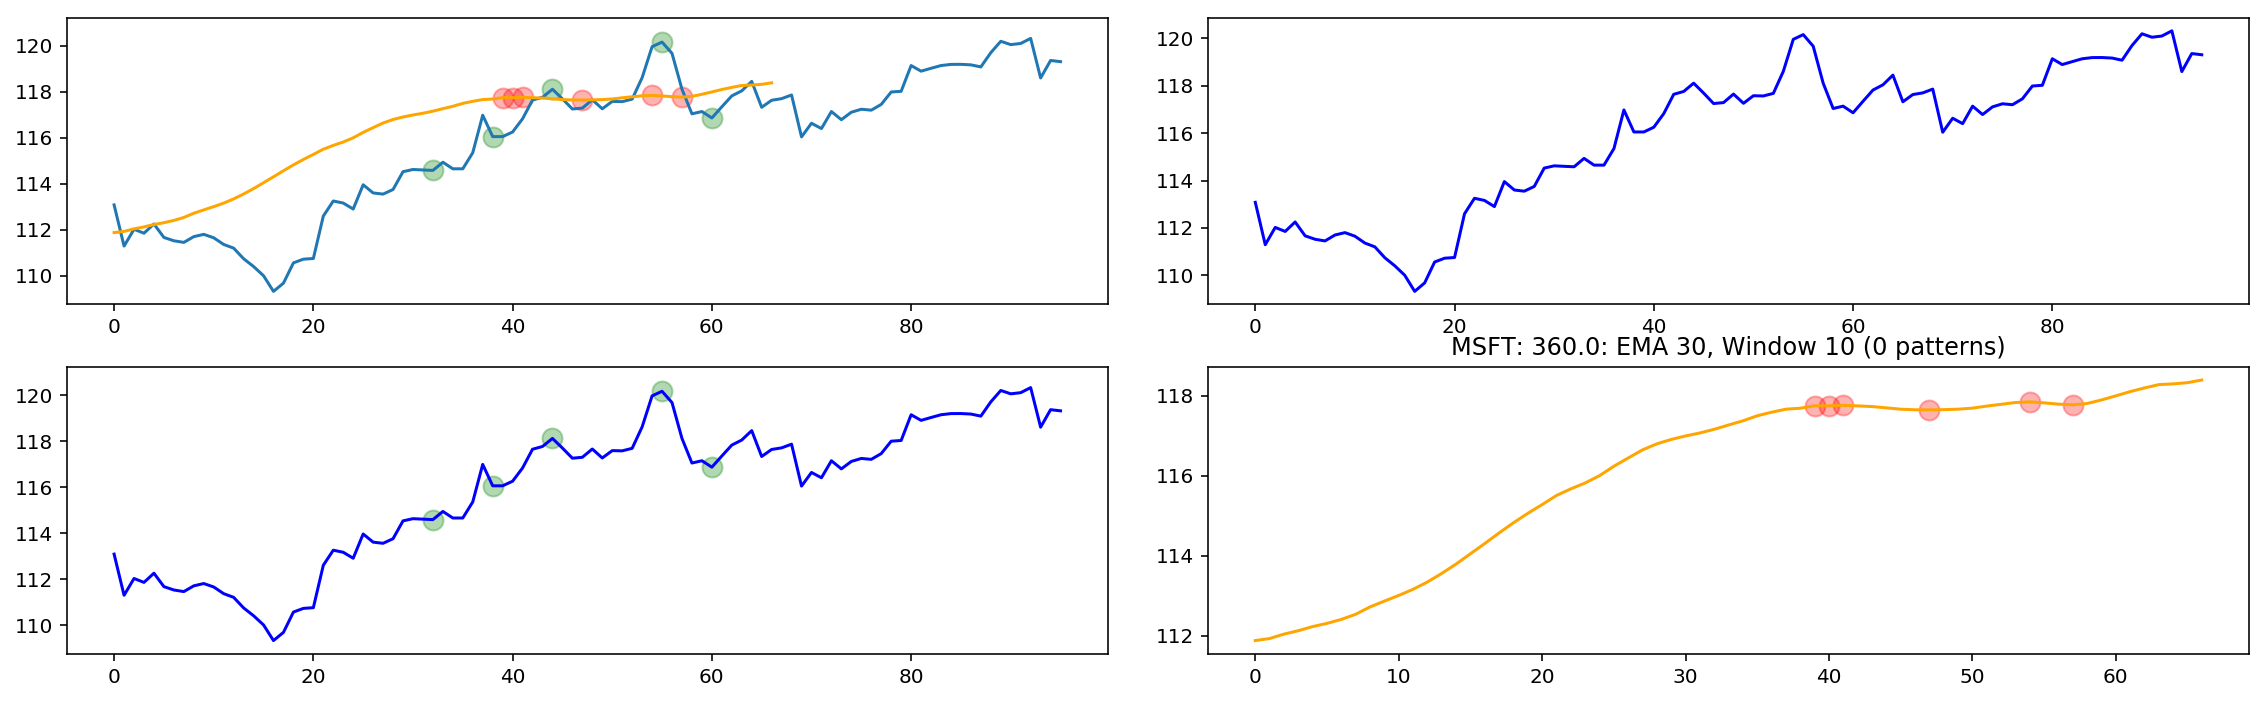

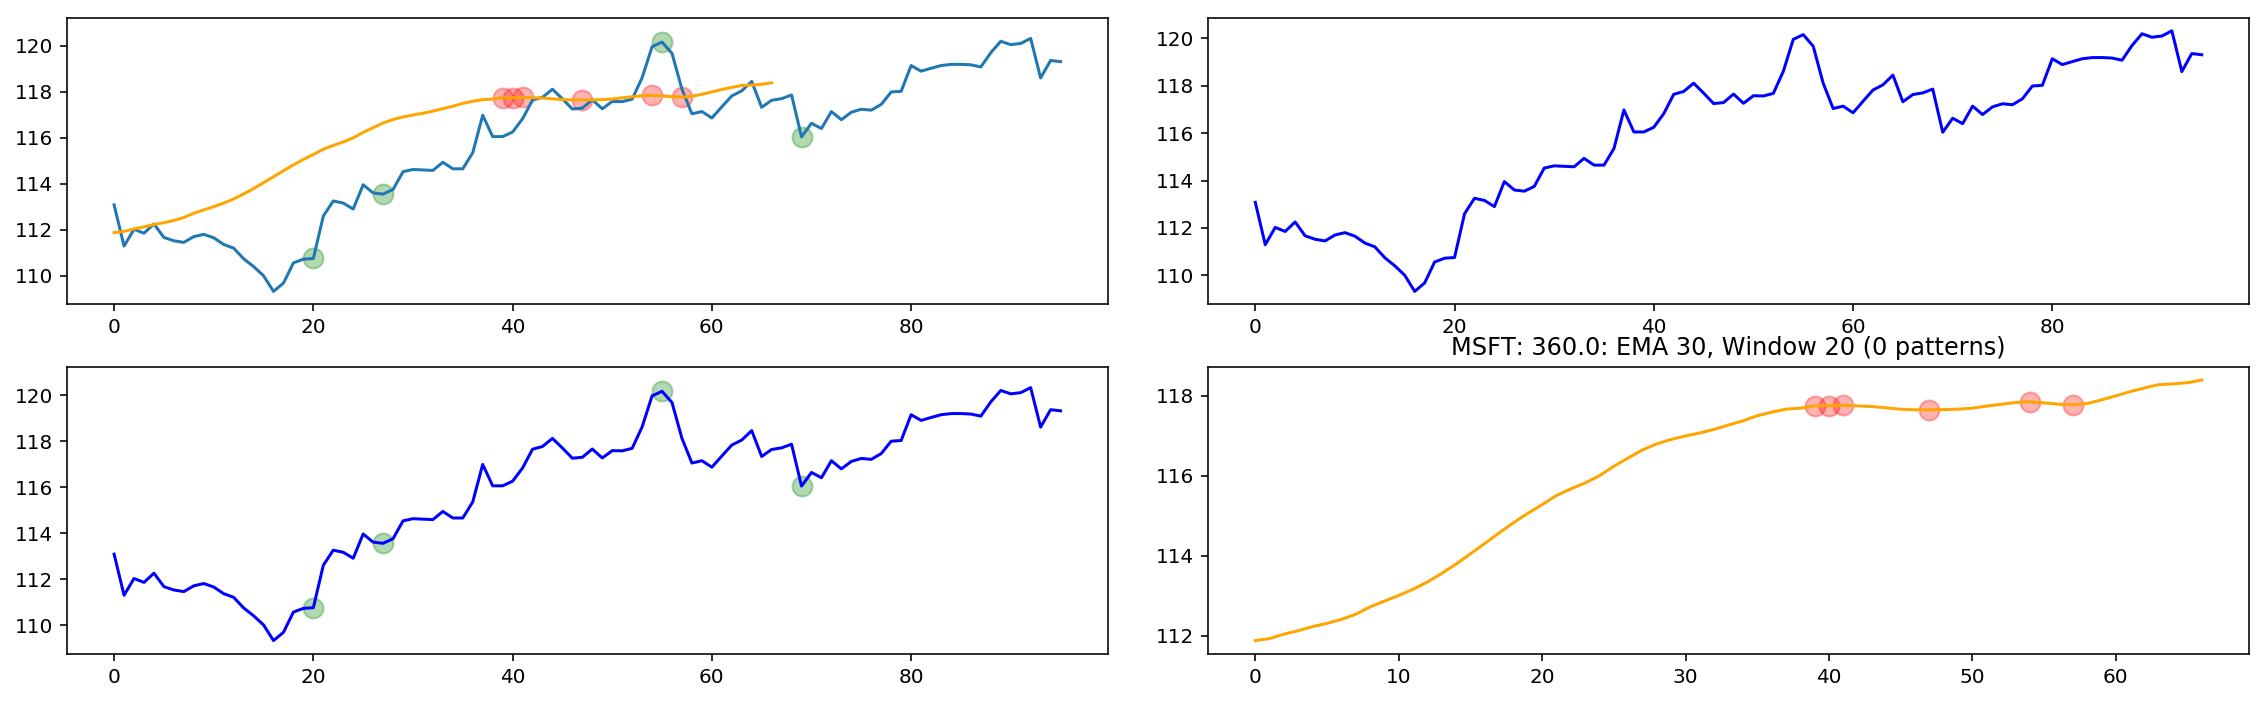

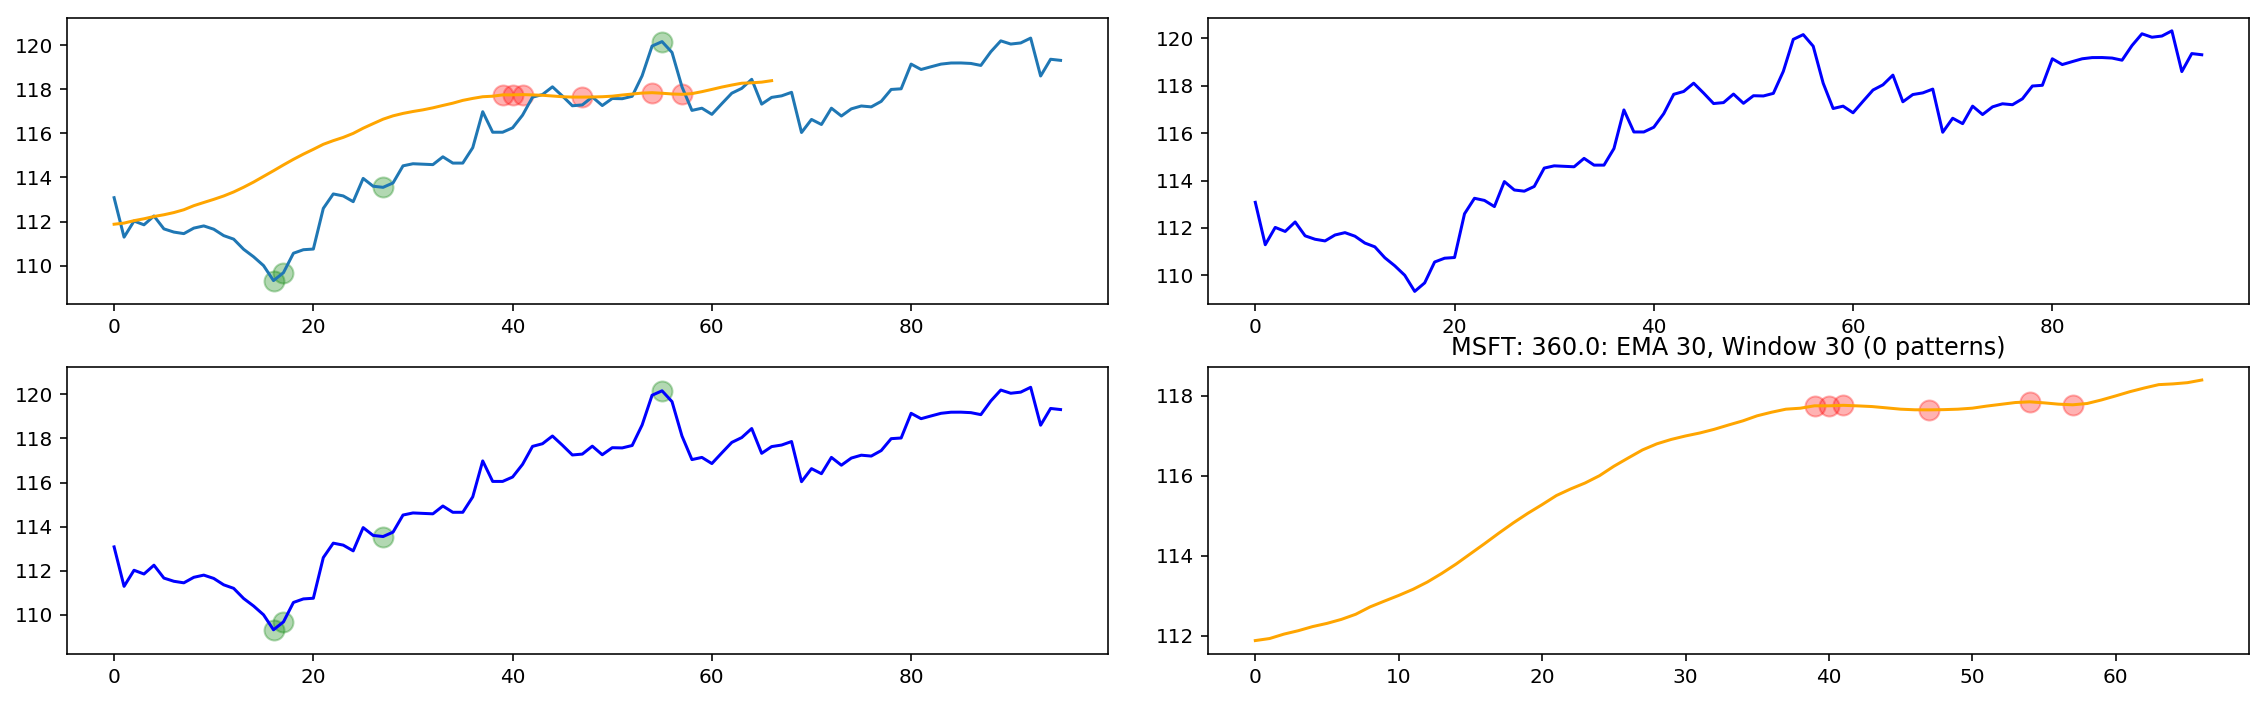

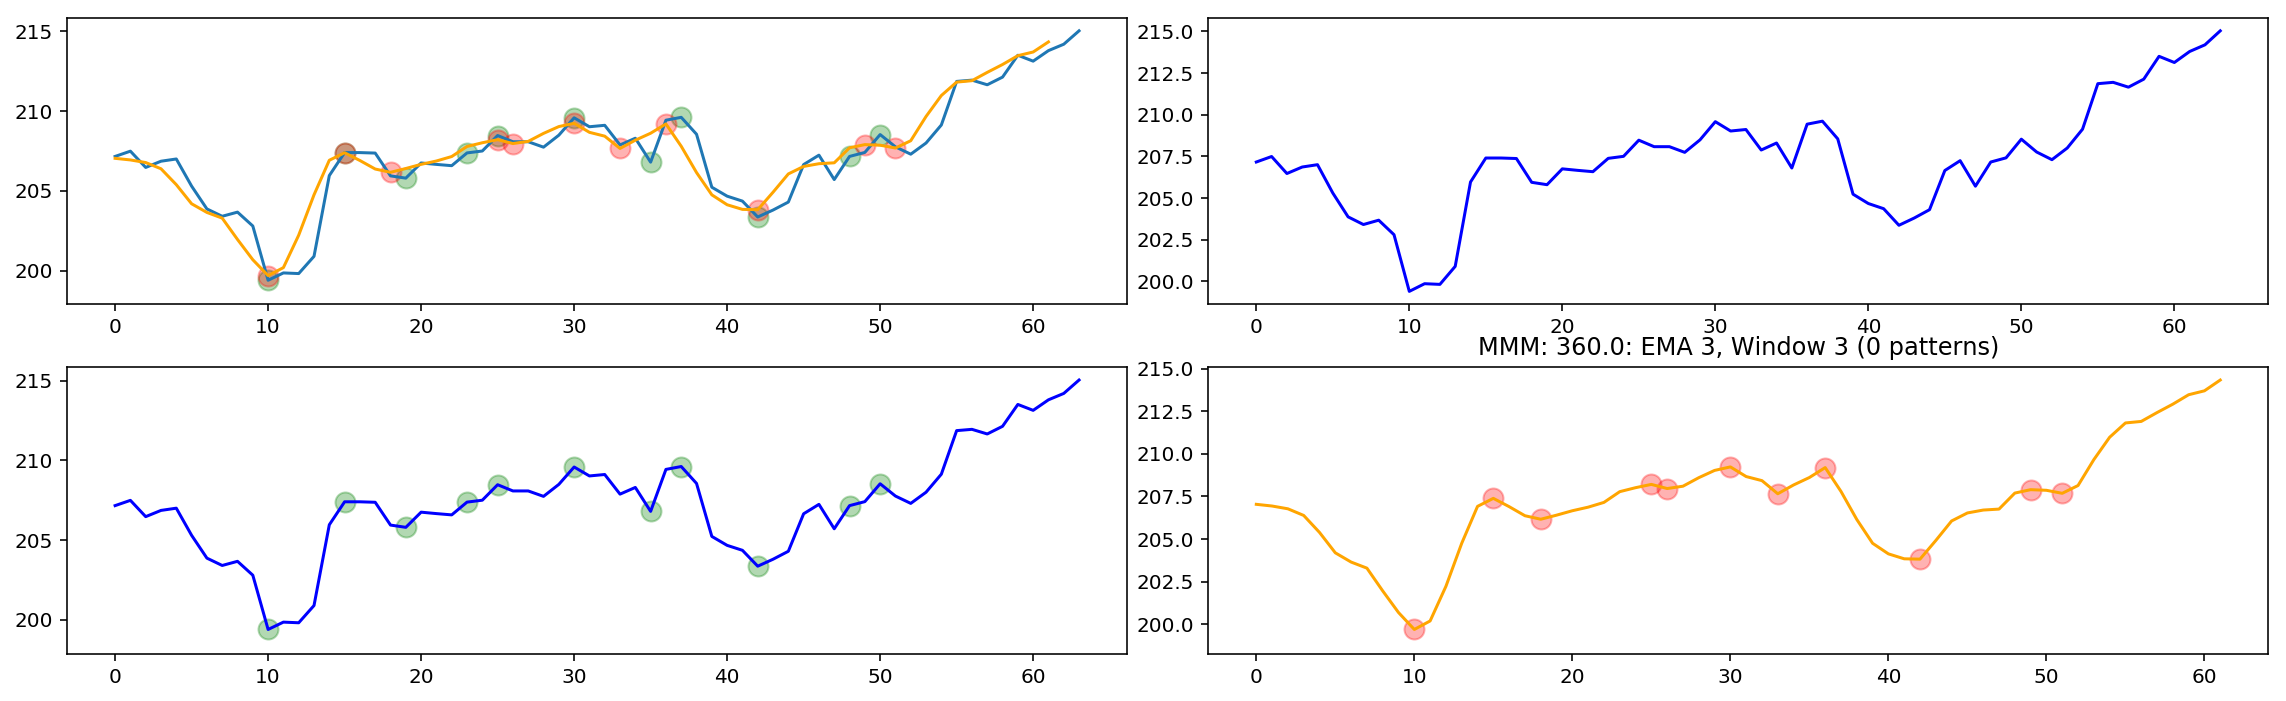

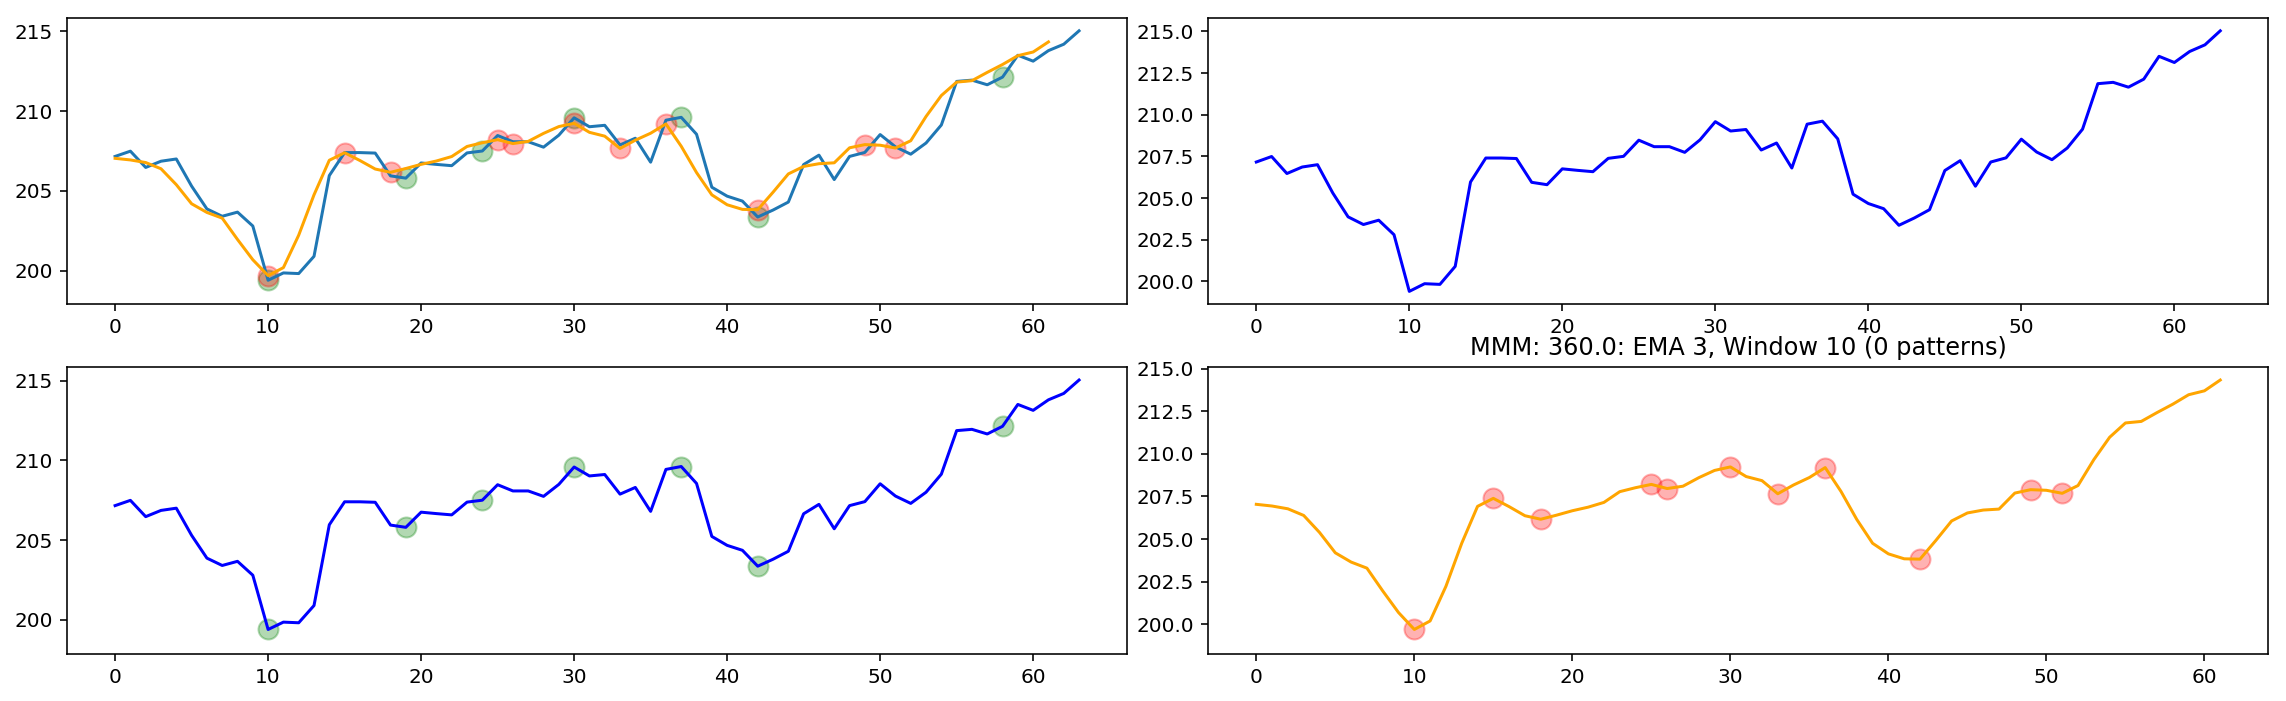

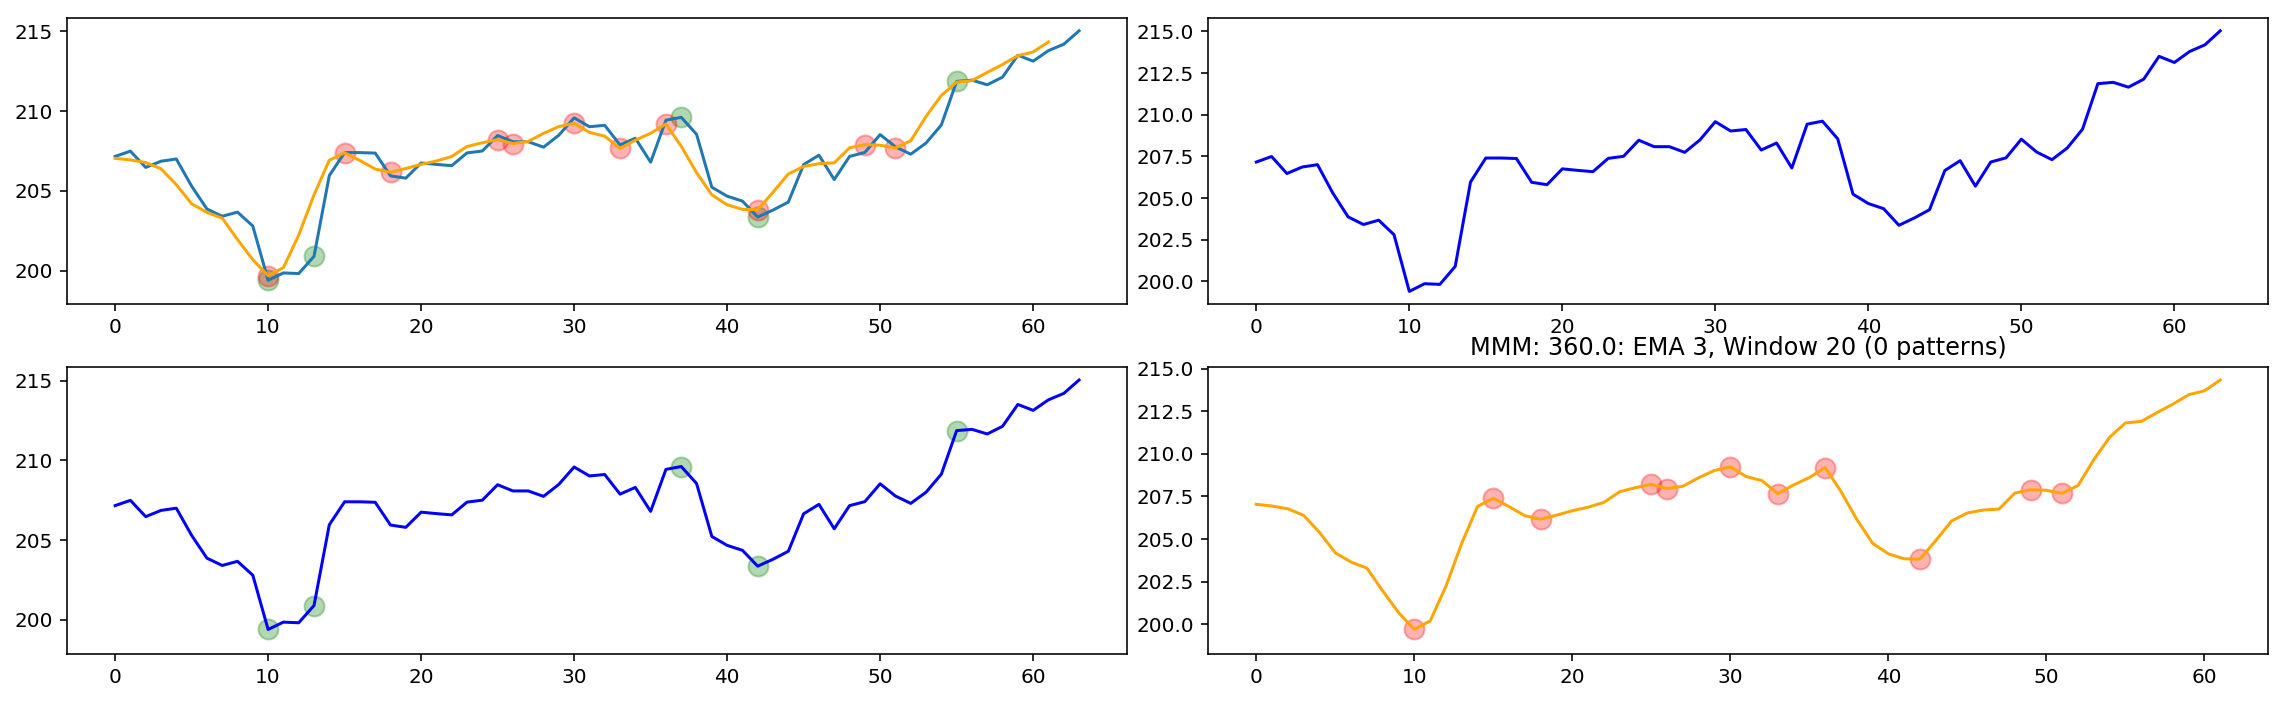

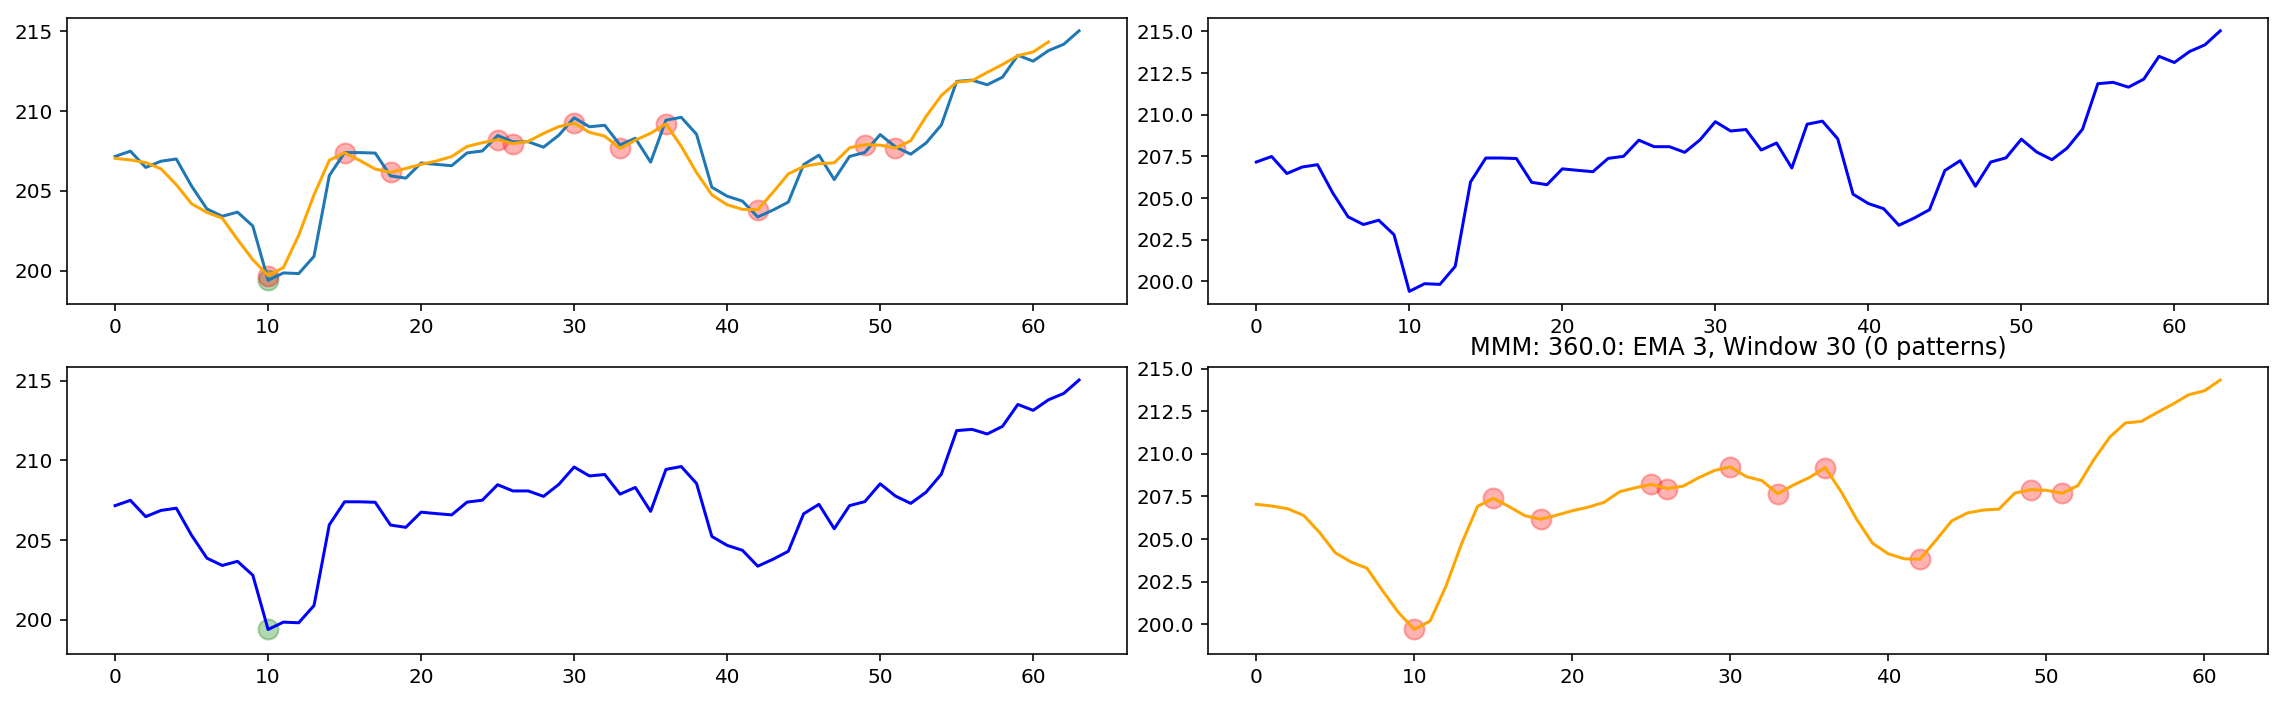

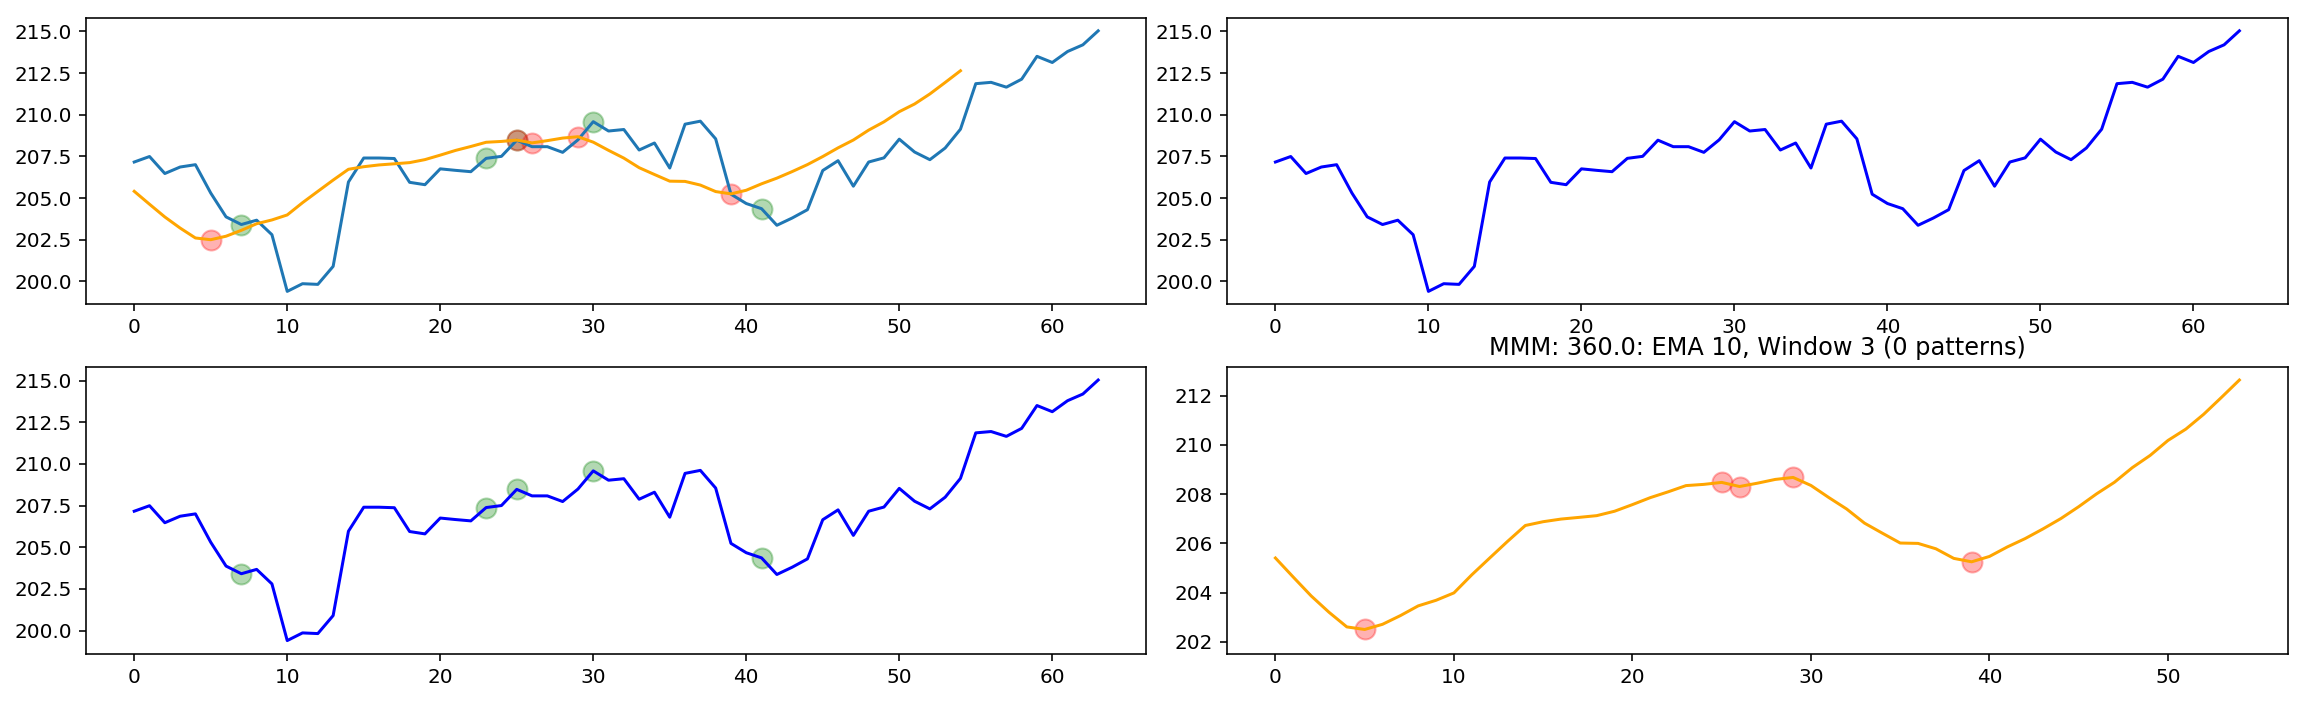

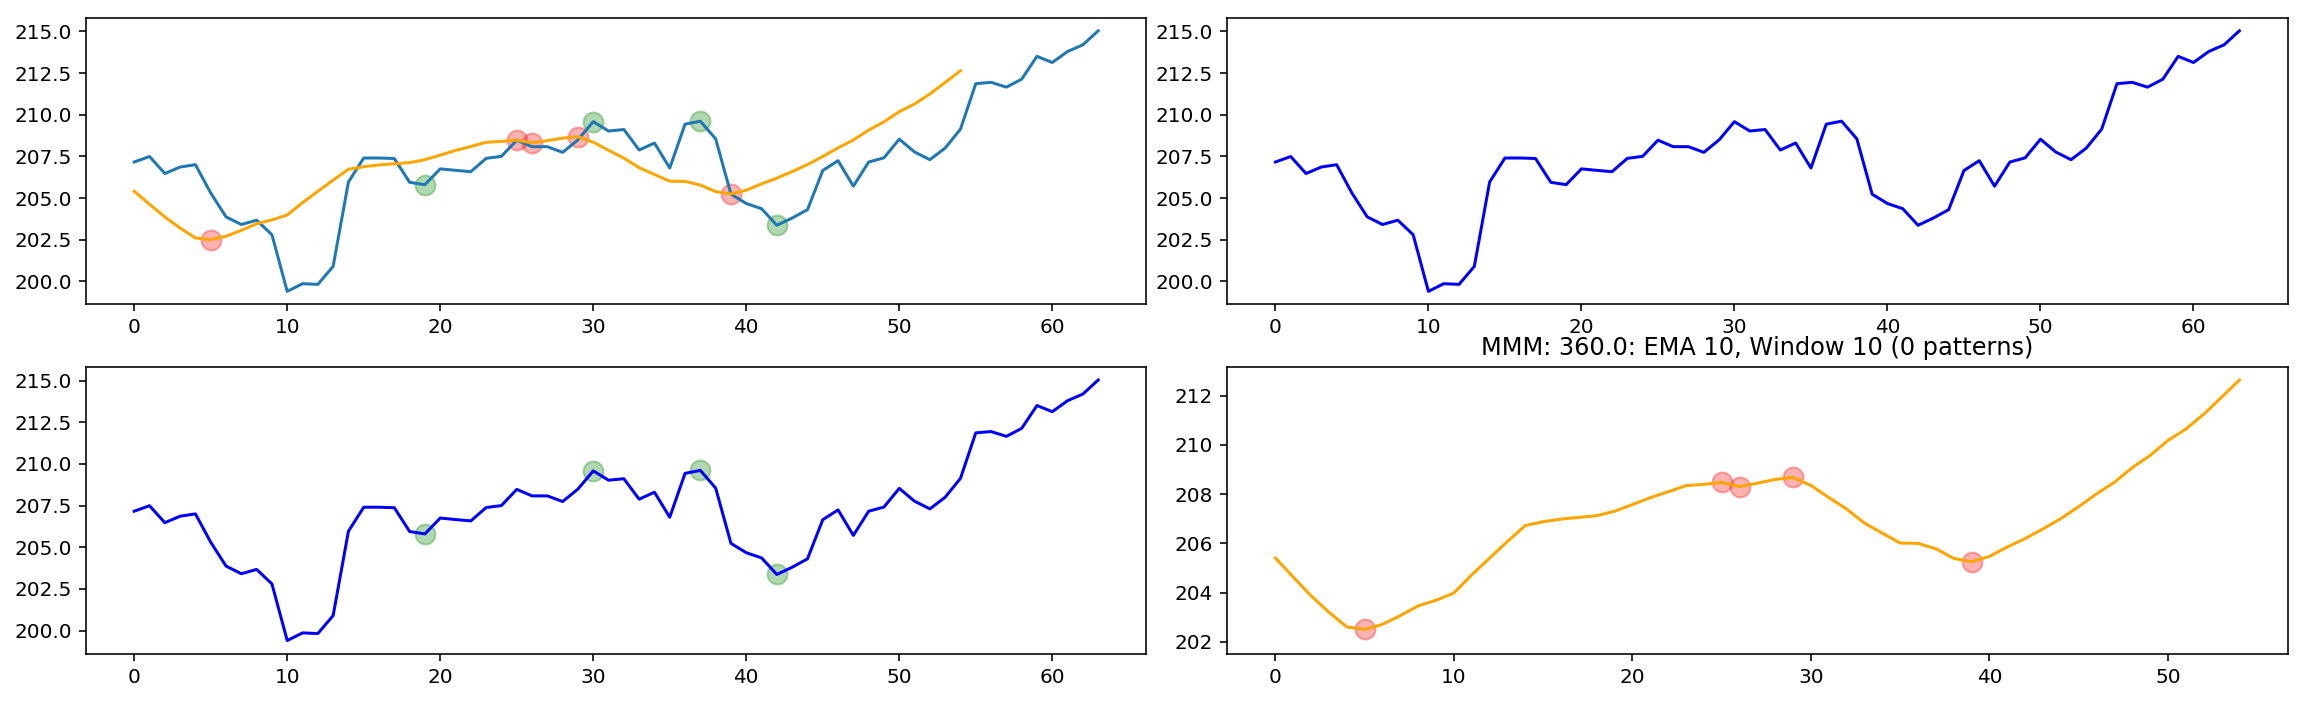

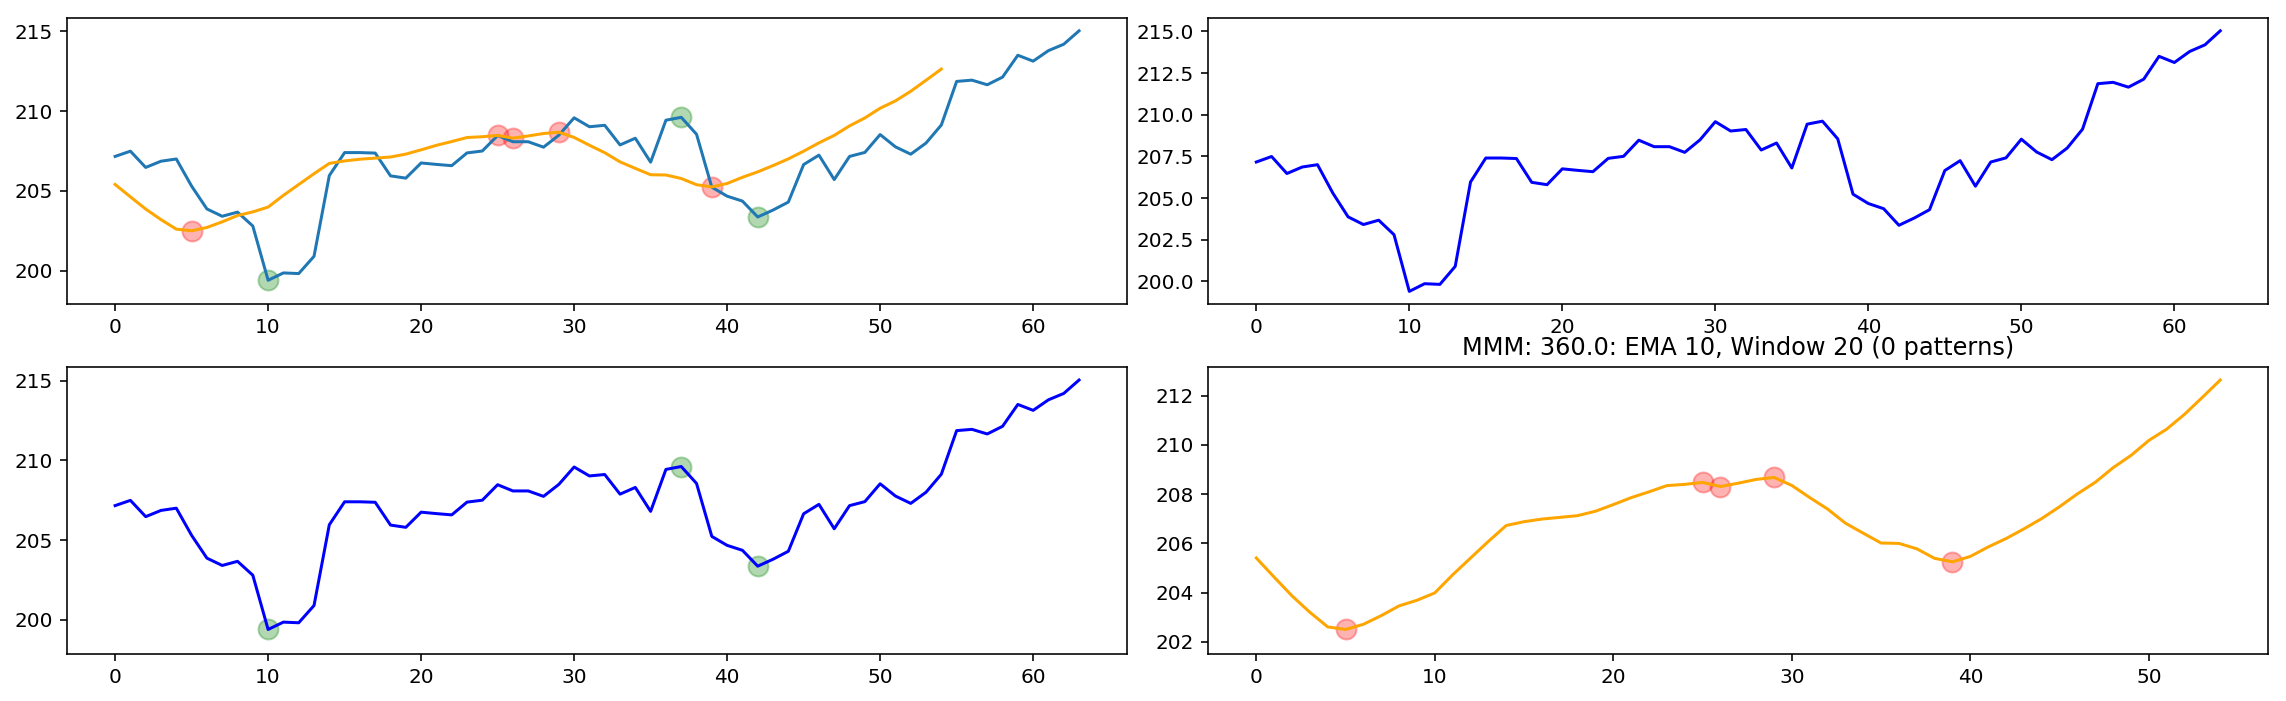

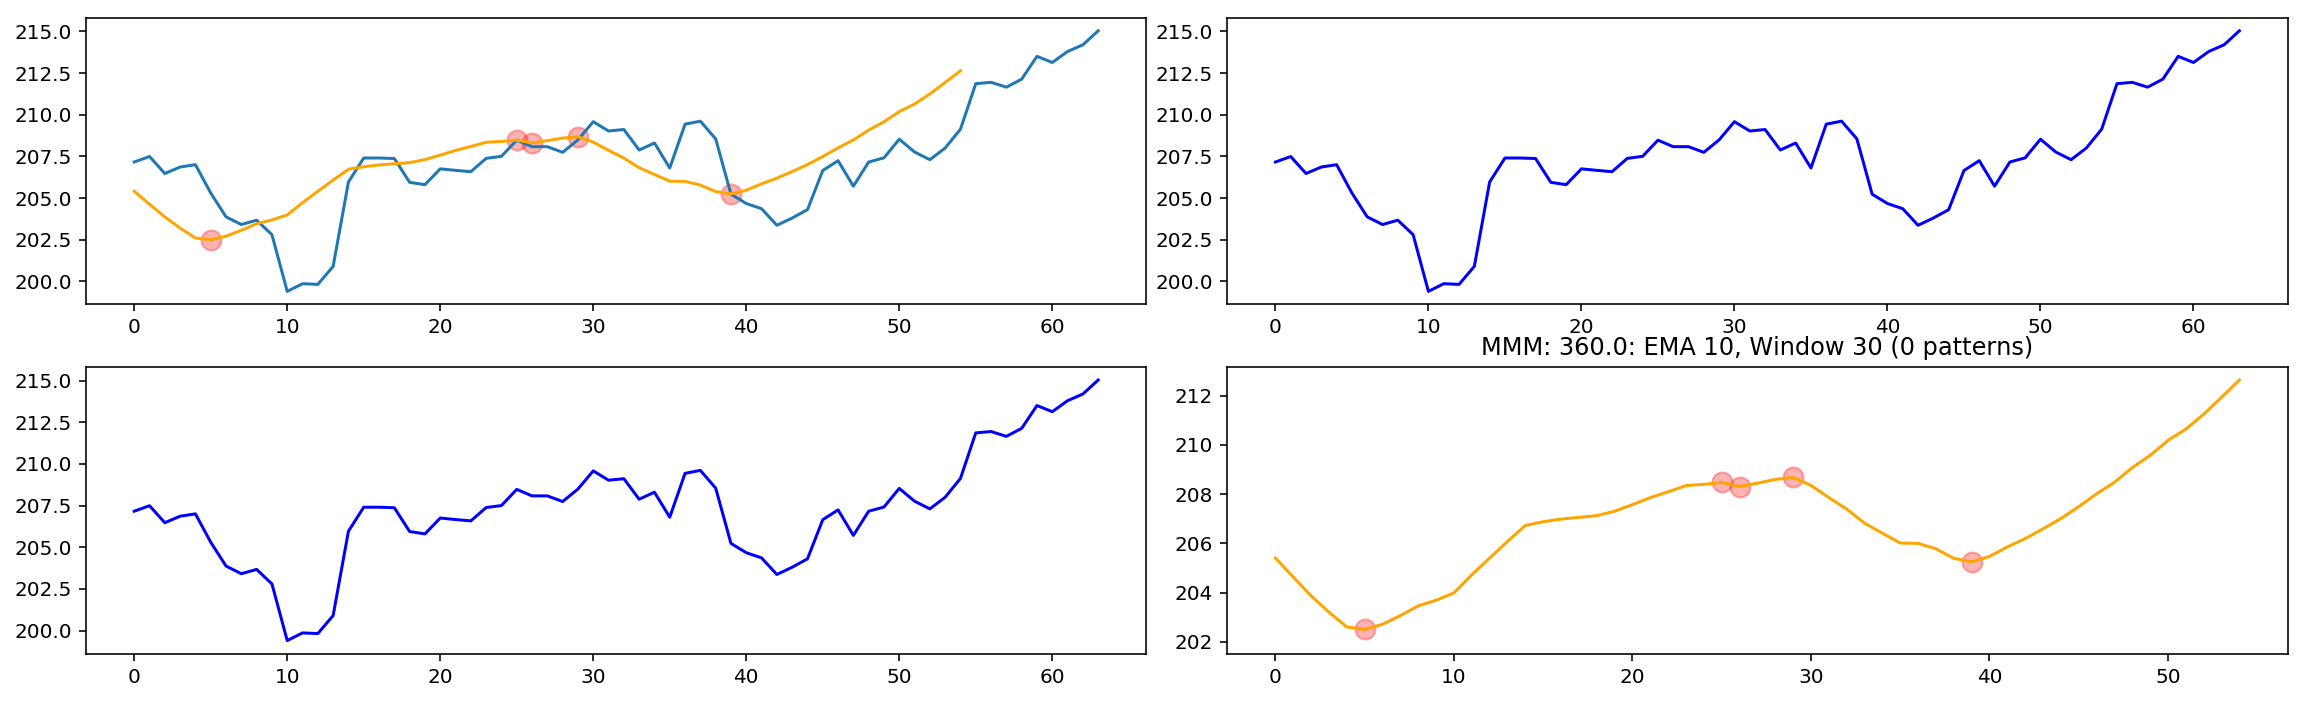

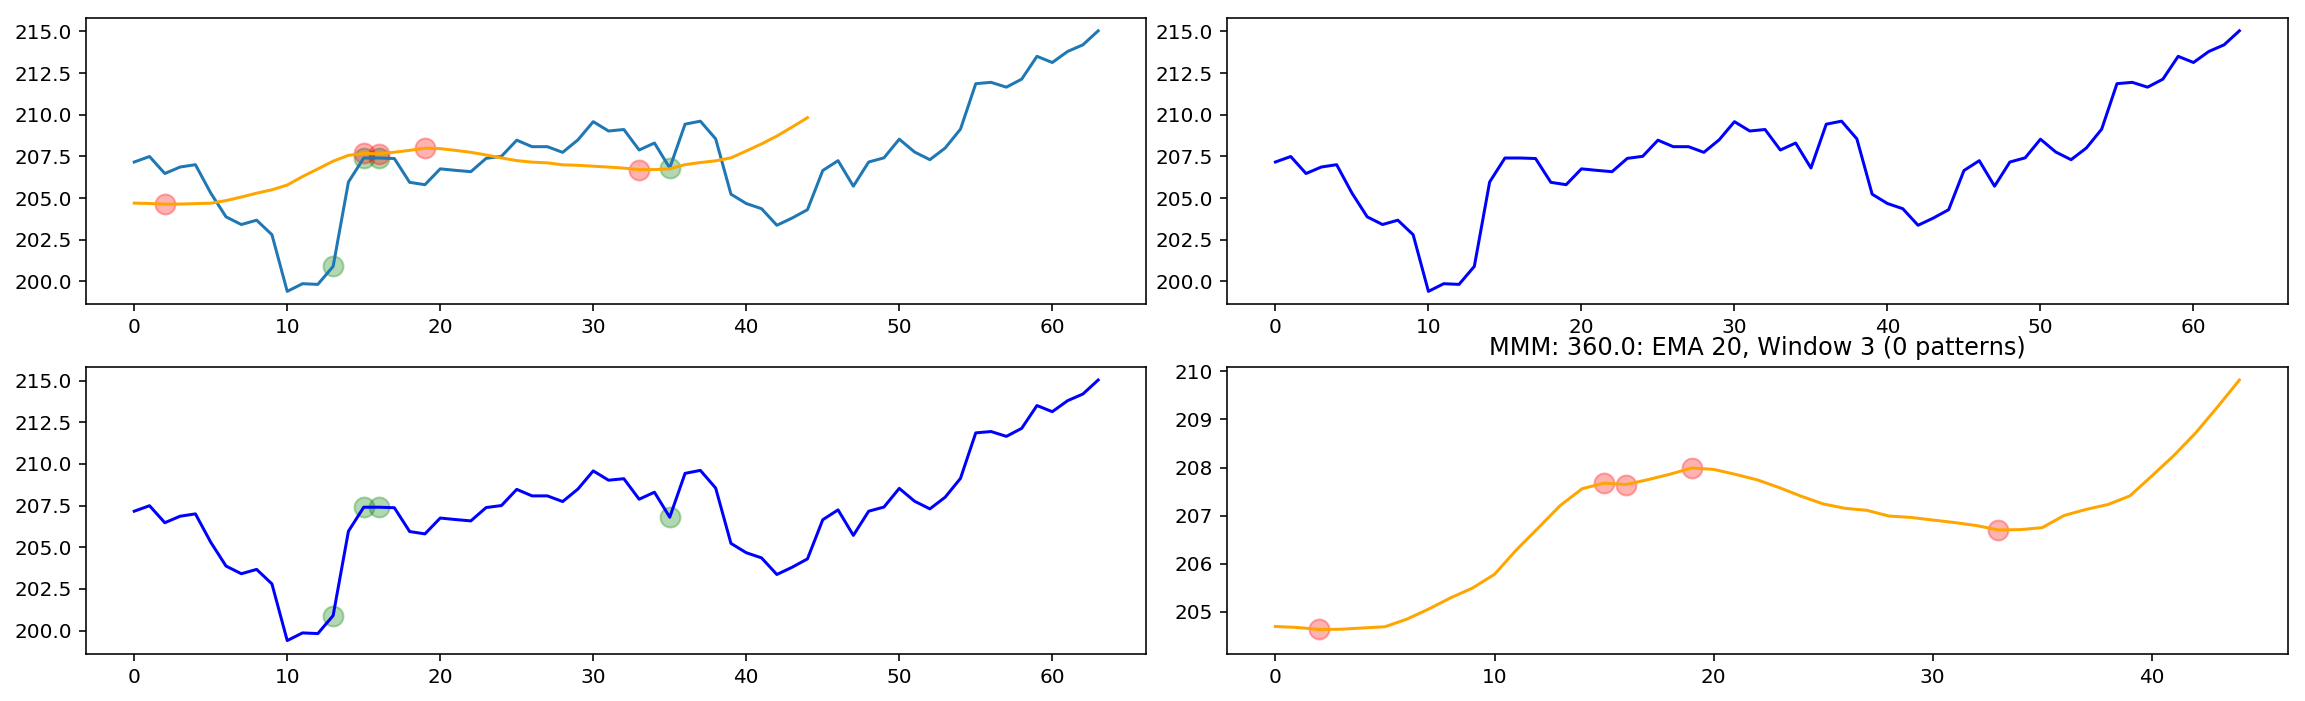

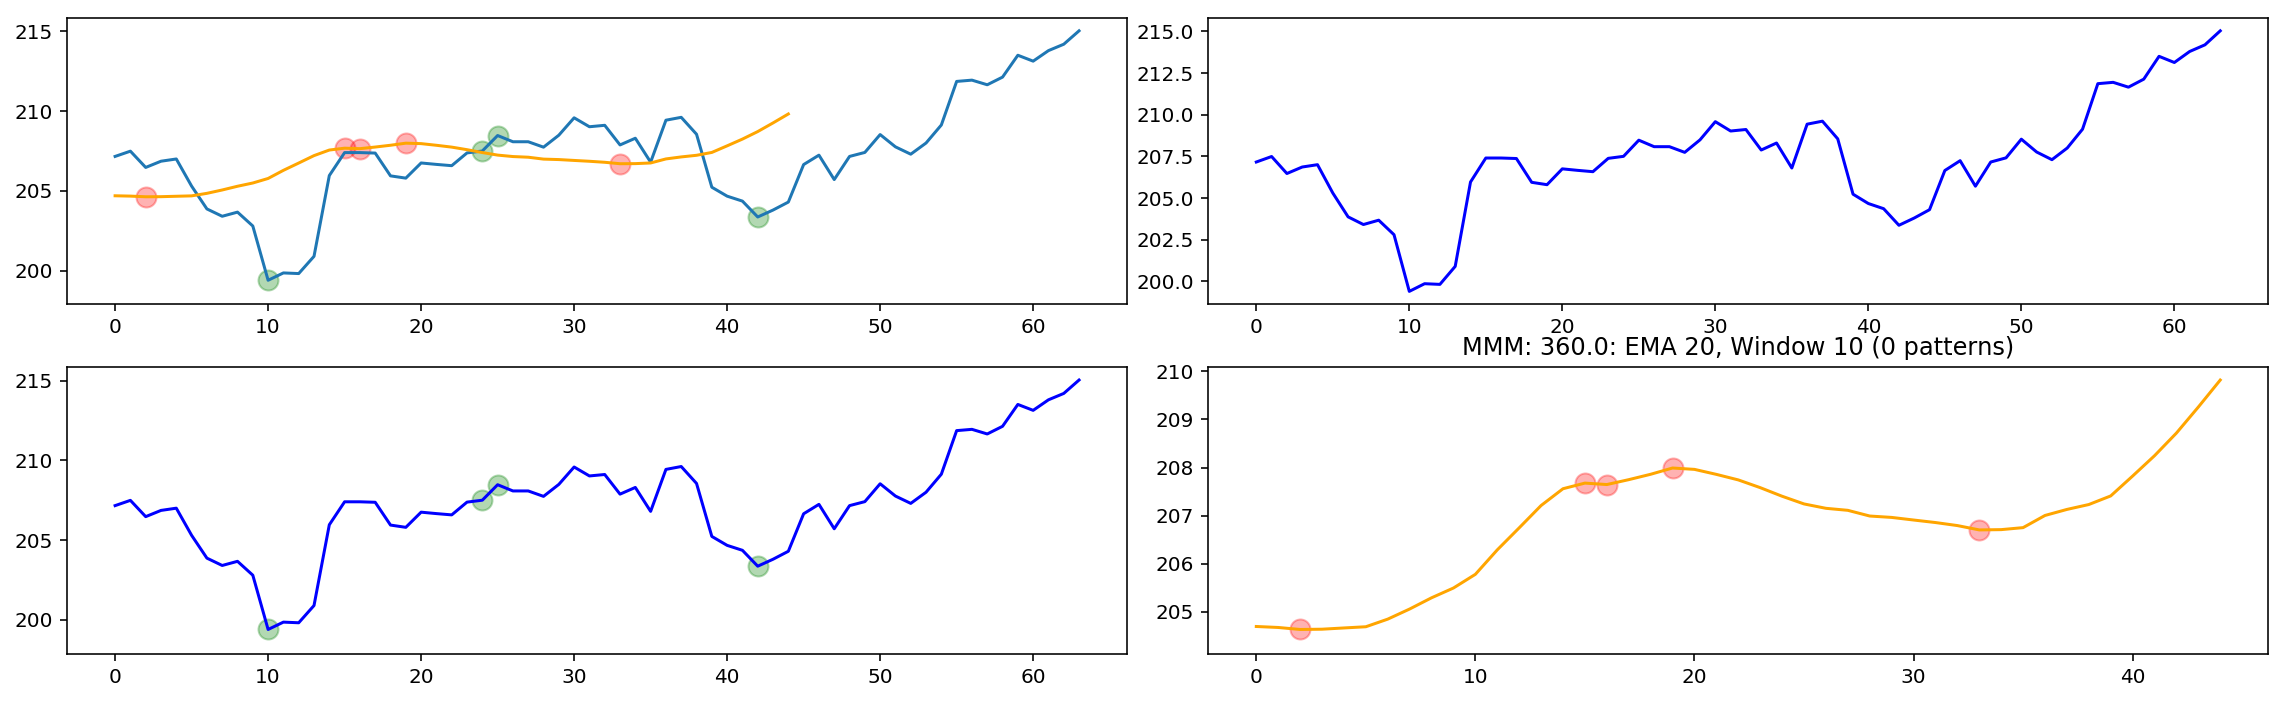

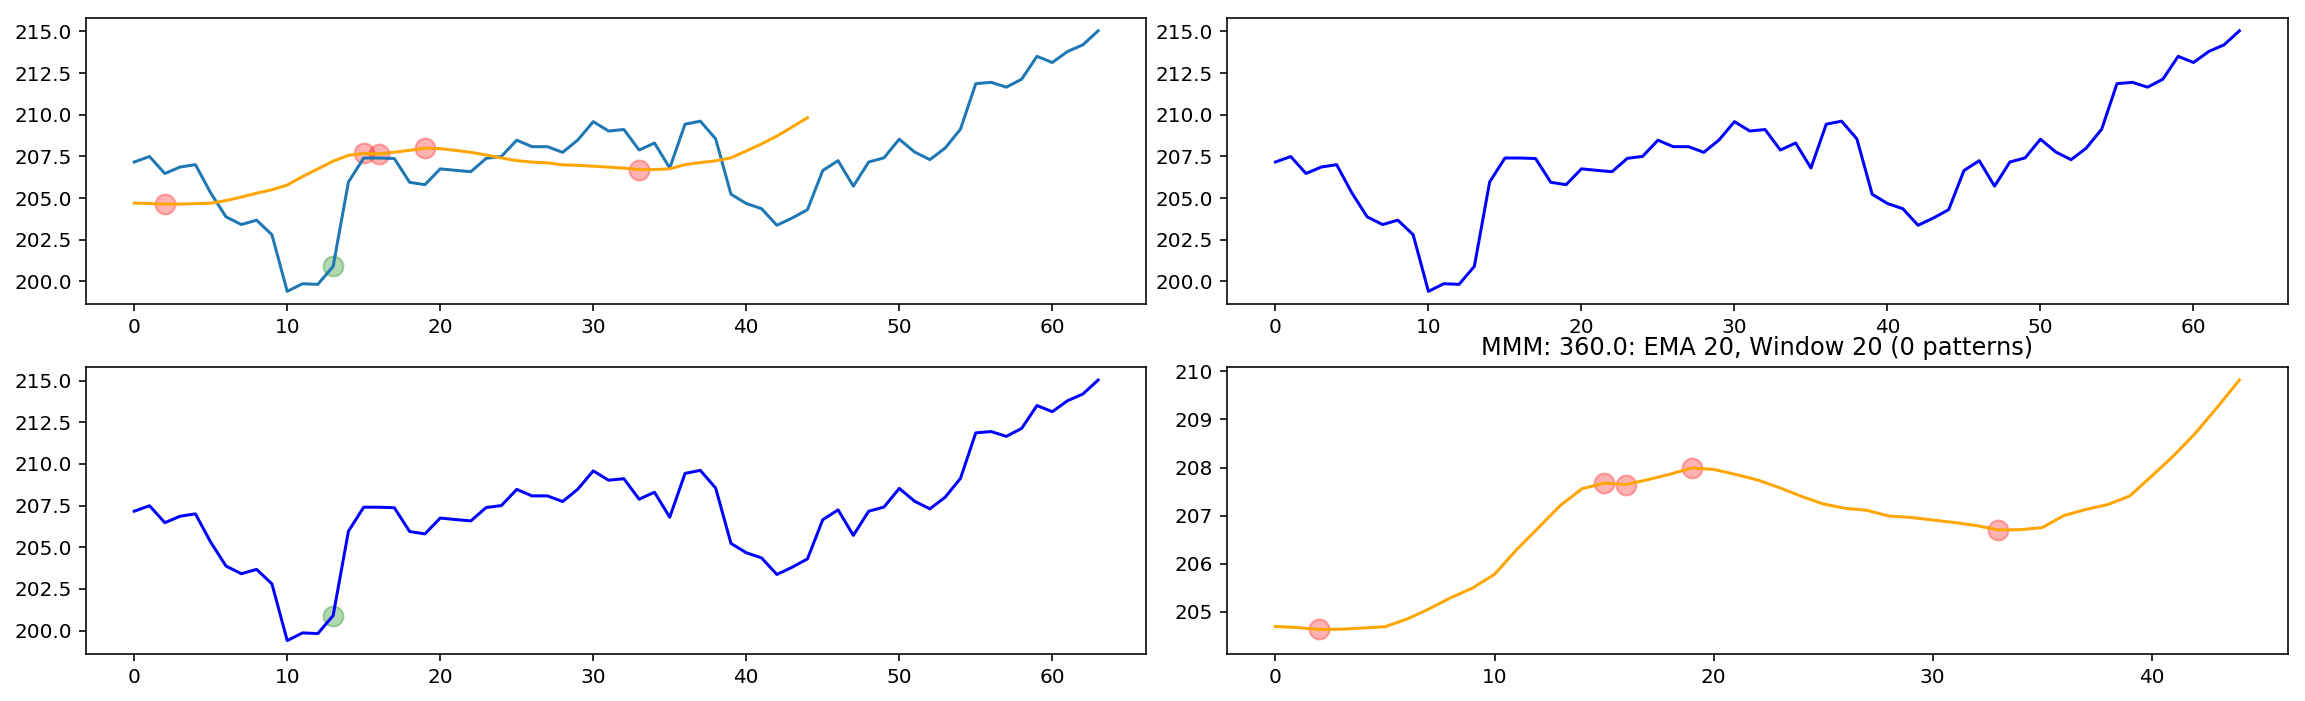

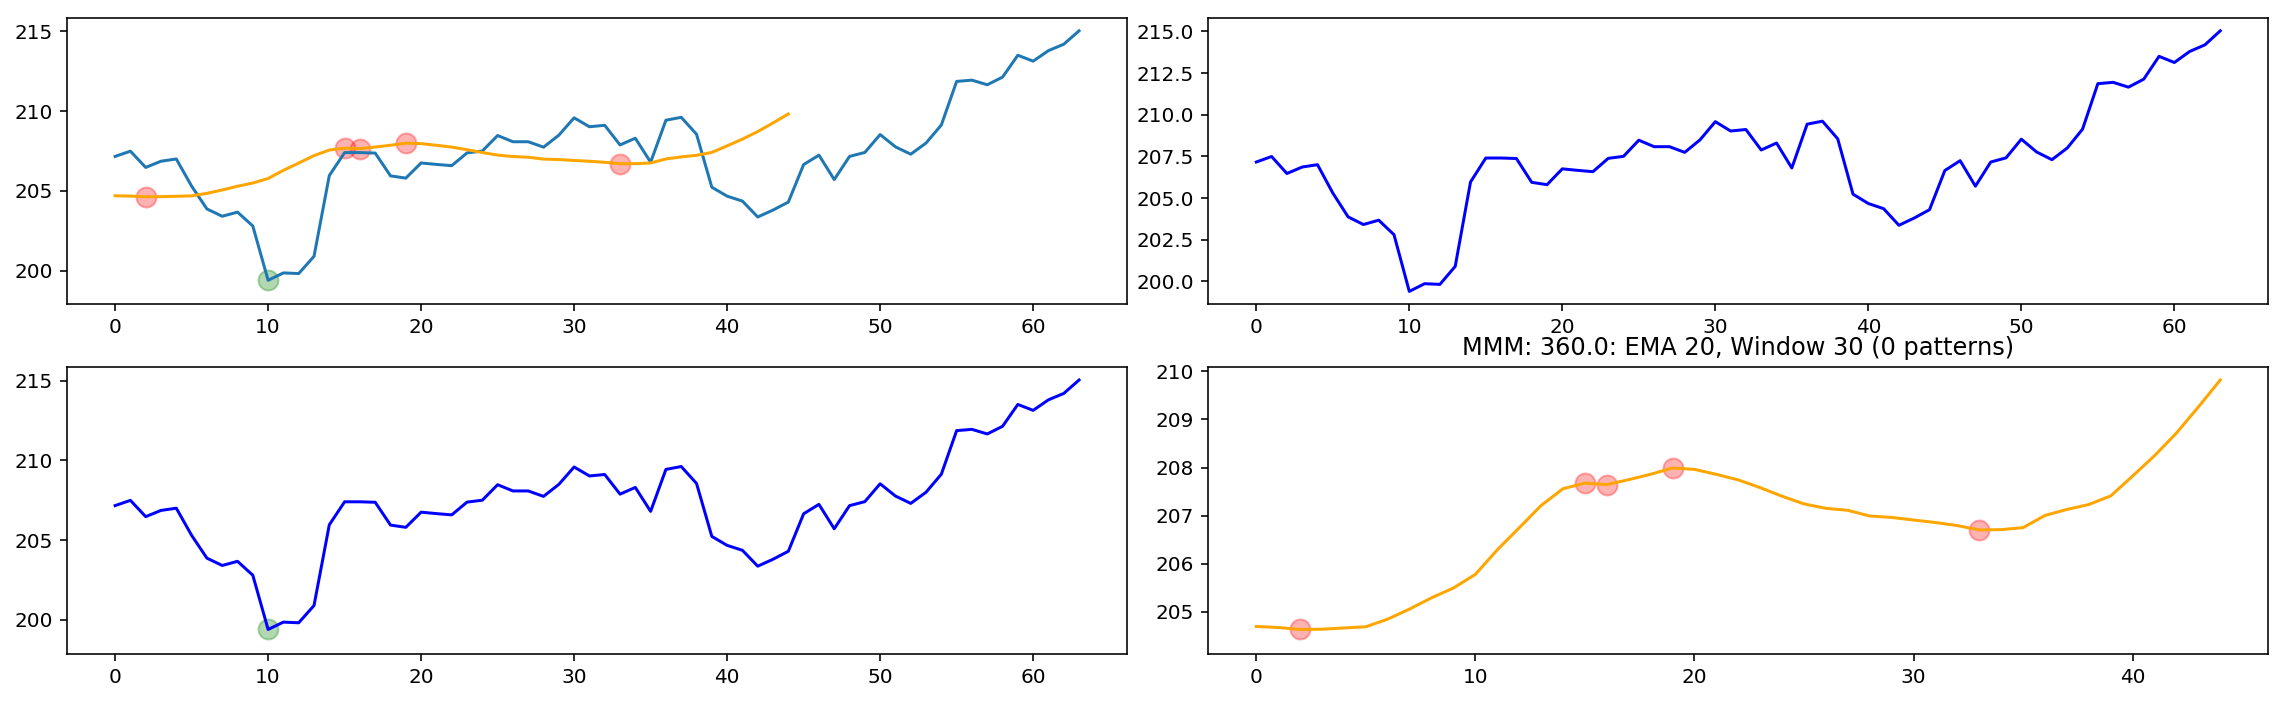

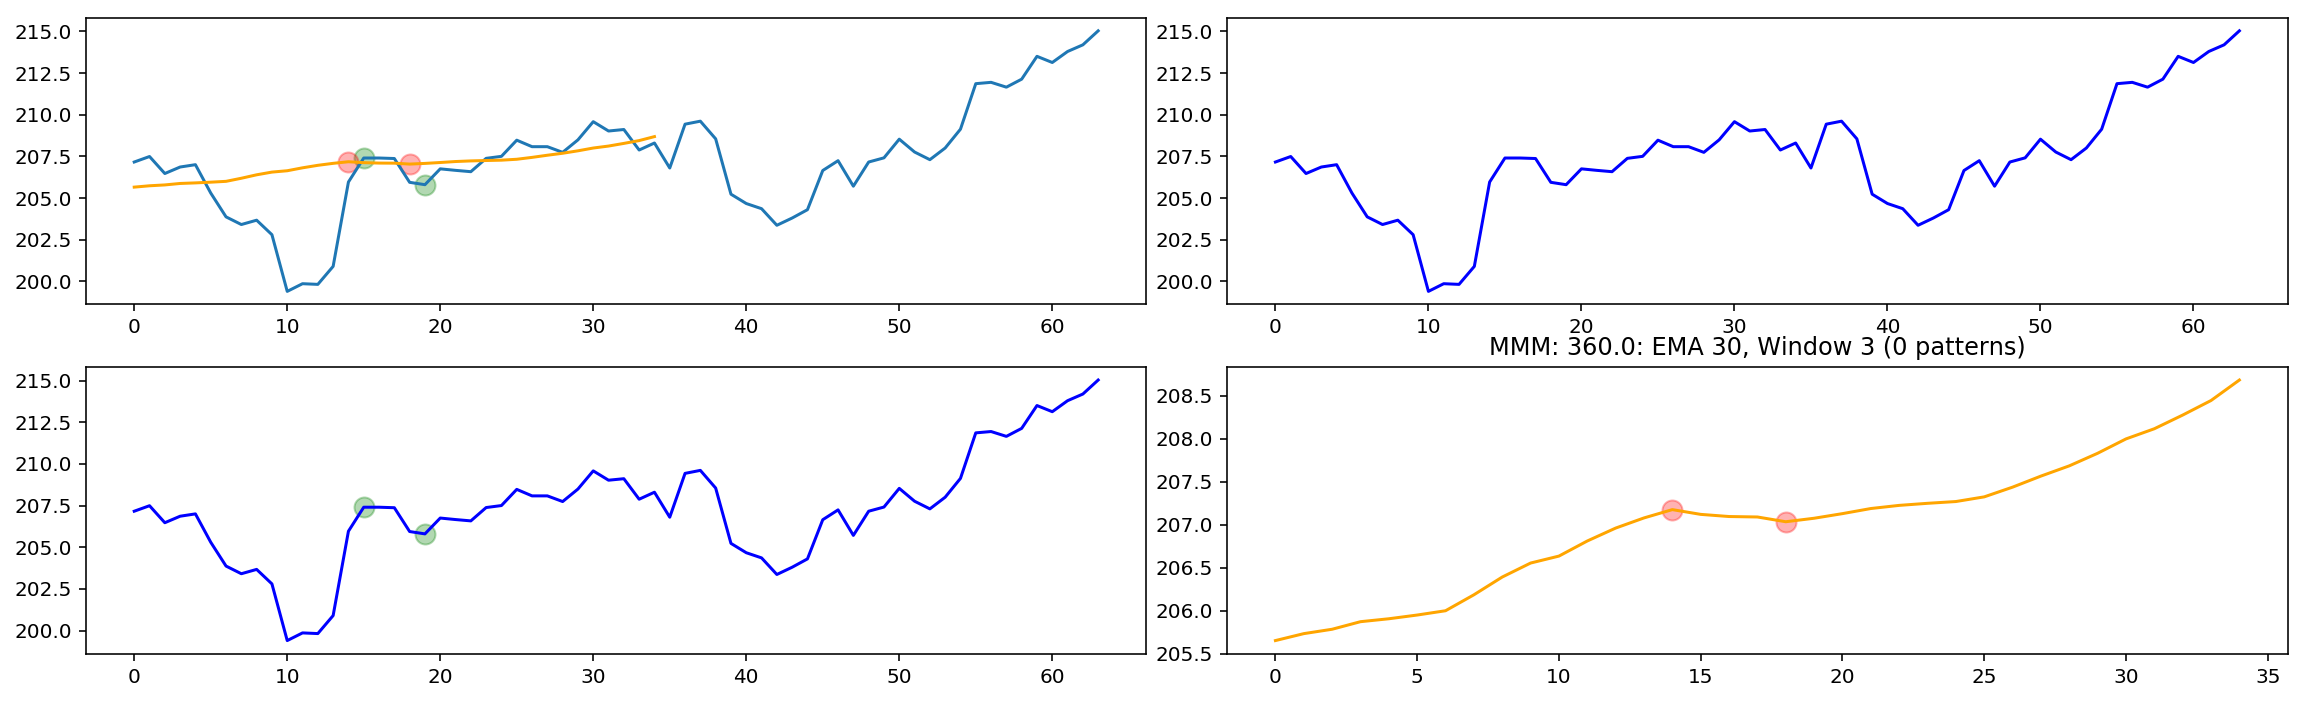

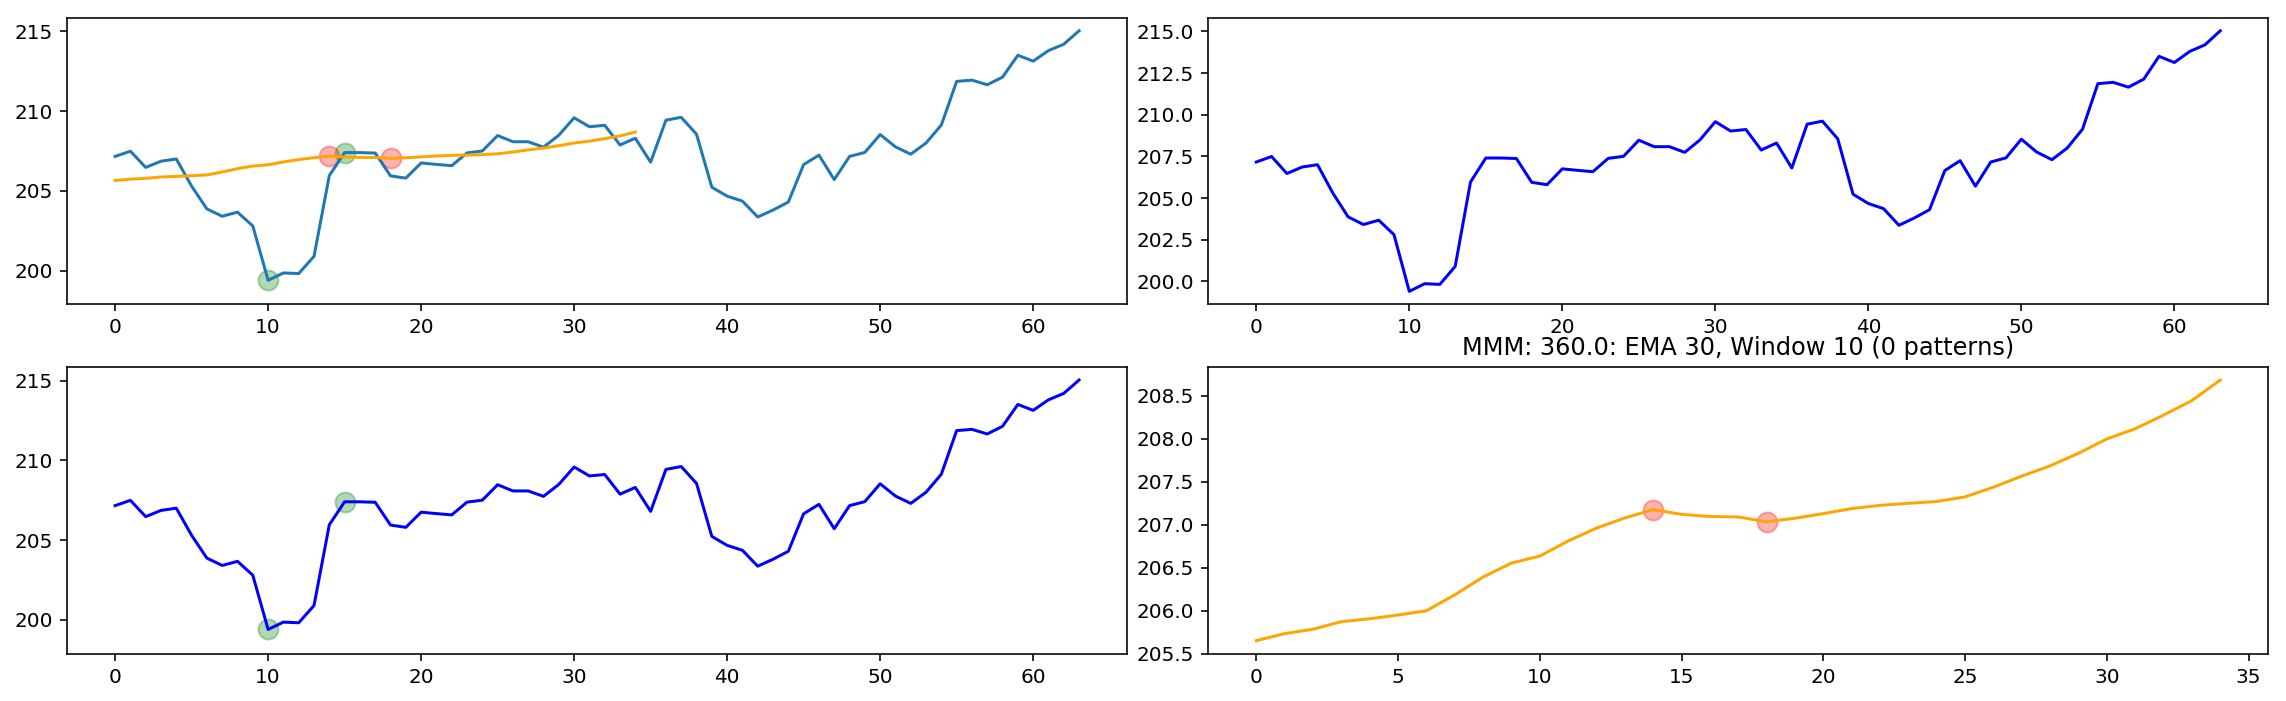

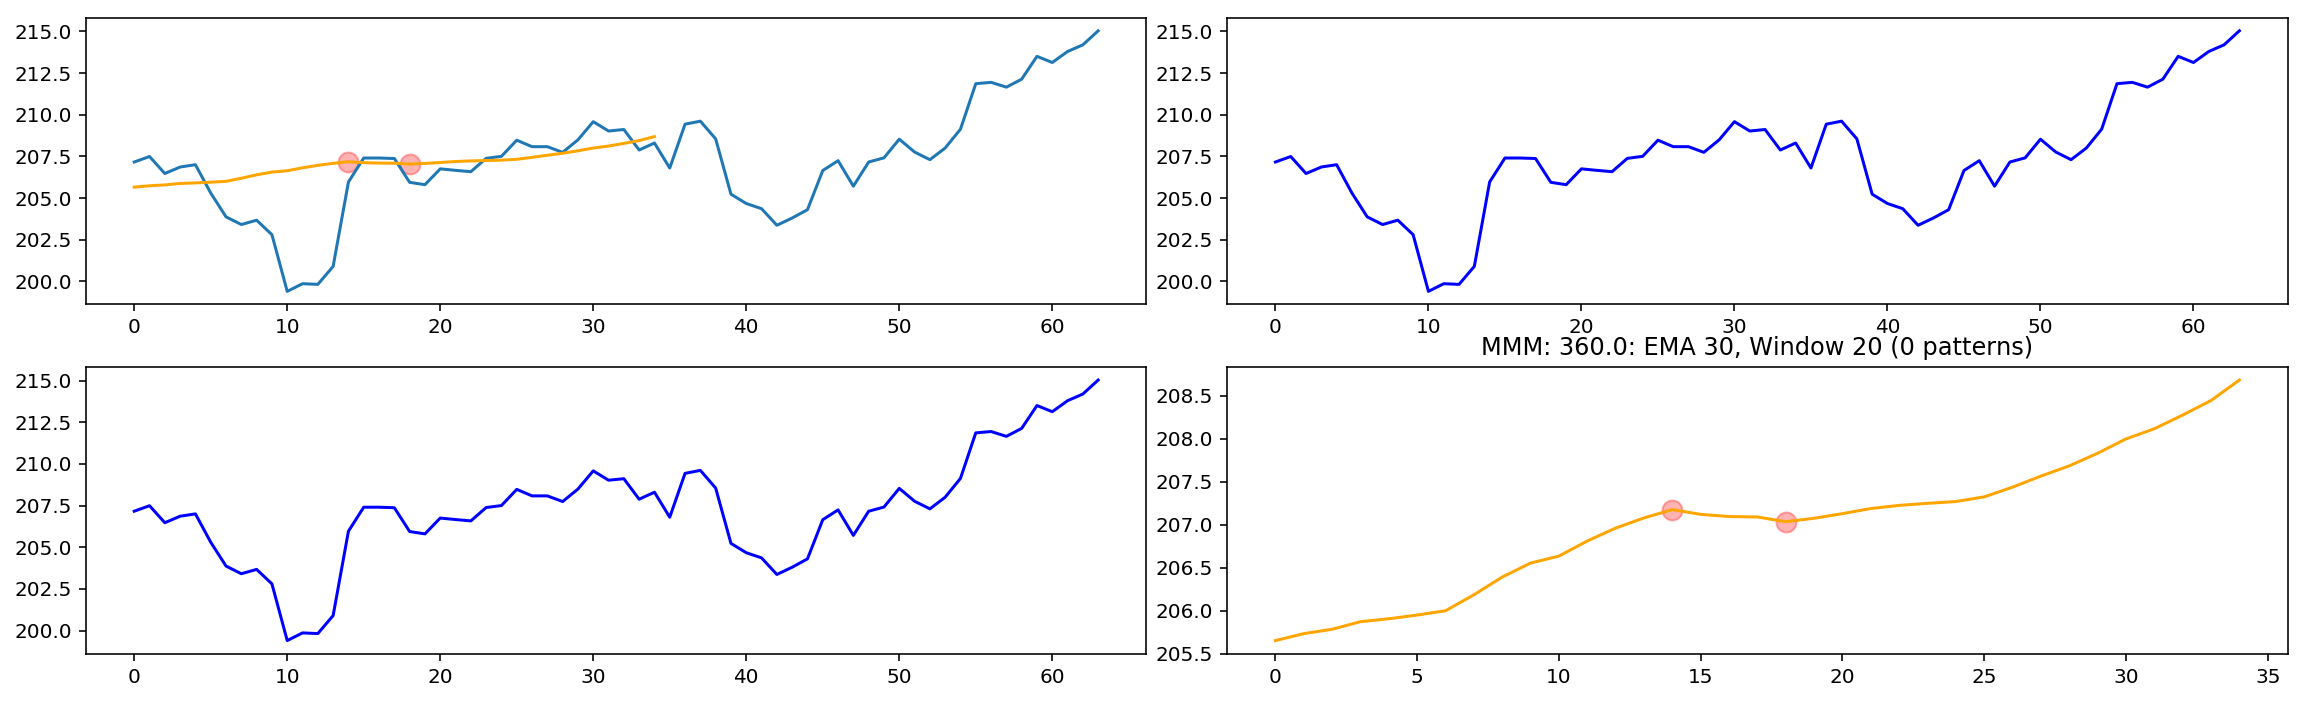

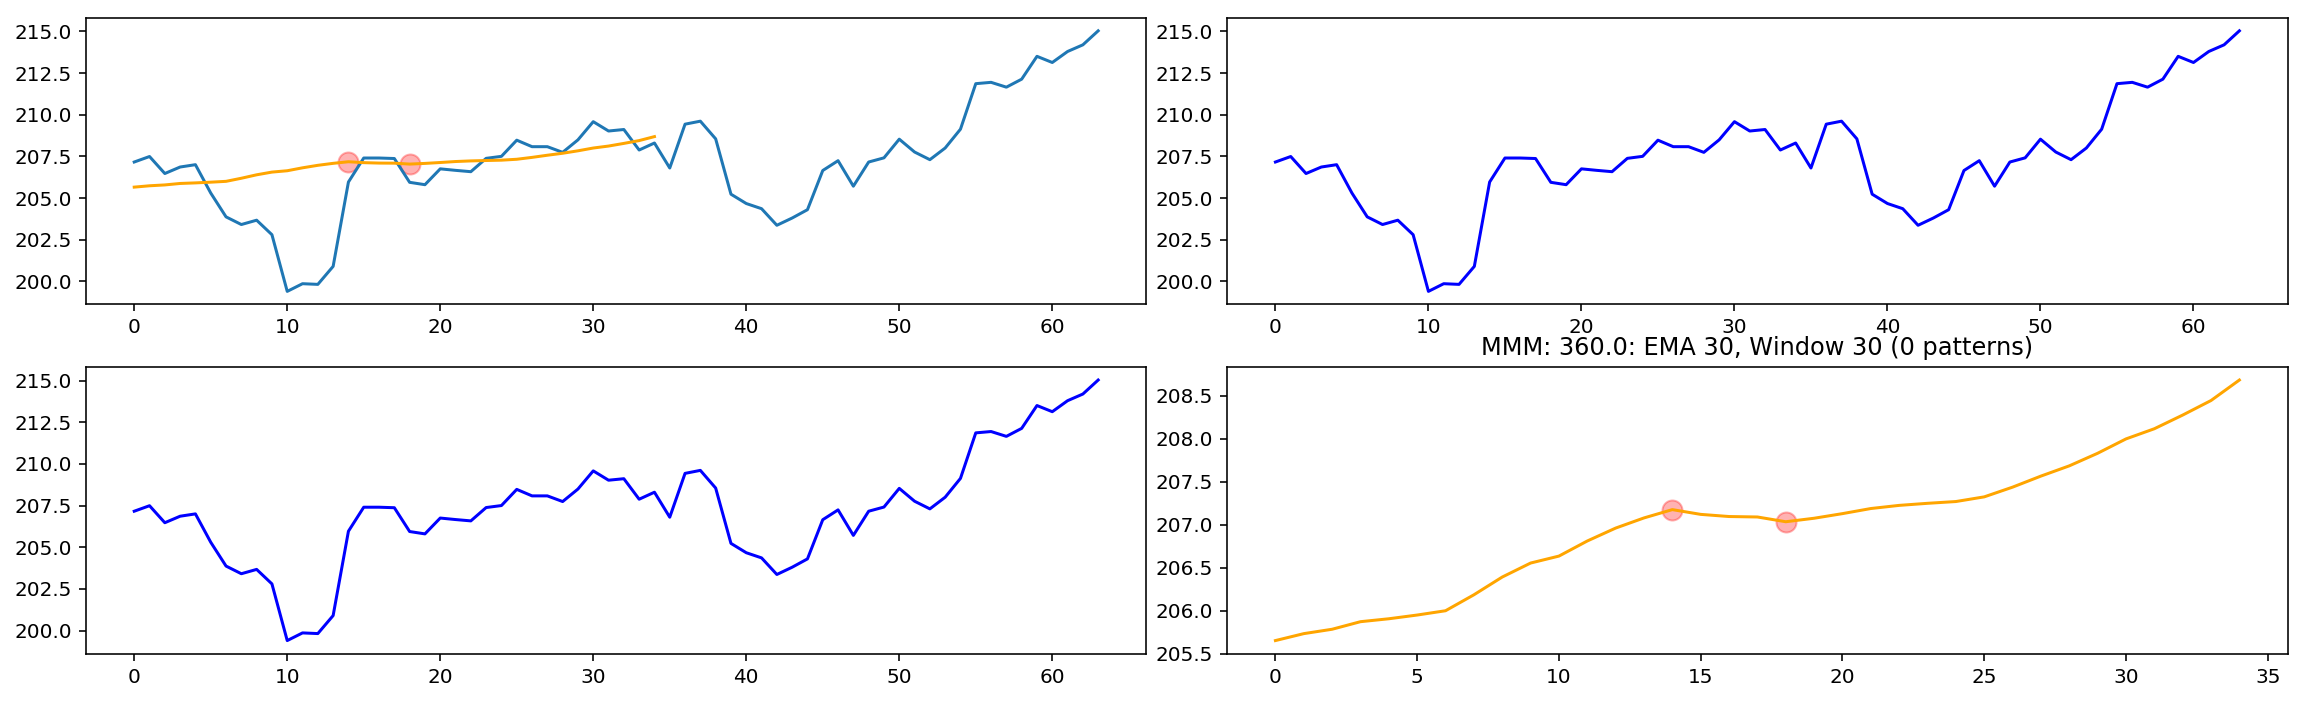

In [225]:
# Run the screener on ema_list and window_list, plotting results.

ema_list = [3, 10, 20, 30]
window_list = [3, 10, 20, 30]

results = screener(resampled_stock_data, ema_list, window_list, plot=True, results=True)

In [7]:
# Examples of reading the results.

for x in [x for x in results.columns if x not in ['stock', 'date']]:
    results[x] = pd.to_numeric(results[x], errors='coerce')
    
print('Average results by window param')
display(round(results.groupby('window').mean(), 3).sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False))
print('\n', 'Average results by ema param')
display(round(results.groupby('ema').mean(), 3).sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False))
print('\n', 'Average results by stock')
display(round(results.groupby('stock').mean(), 3).sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False))
# print('\n', 'Results sorted by return')
# display(round(results.sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False), 3))

Average results by window param


ema  fw_ret_1  fw_ret_2  fw_ret_3  increment
window                                                 
3       15.526     0.005     0.005     0.007      360.0
10      15.750       NaN       NaN       NaN      360.0
20      15.750       NaN       NaN       NaN      360.0
30      15.750       NaN       NaN       NaN      360.0


 Average results by ema param


fw_ret_1  fw_ret_2  fw_ret_3  increment  window
ema                                                 
3       0.005     0.005     0.007      360.0  15.526
10        NaN       NaN       NaN      360.0  15.750
20        NaN       NaN       NaN      360.0  15.750
30        NaN       NaN       NaN      360.0  15.750


 Average results by stock


ema  fw_ret_1  fw_ret_2  fw_ret_3  increment  window
stock                                                        
S      15.75     0.018     0.005     0.005      360.0   15.75
V      15.75     0.008     0.008     0.010      360.0   15.75
TWTR   15.00     0.003     0.008     0.009      360.0   15.00
MSFT   15.75     0.003     0.003     0.005      360.0   15.75
FB     15.75     0.002     0.003     0.003      360.0   15.75
AMZN   15.75     0.001     0.001     0.009      360.0   15.75
AAPL   15.75       NaN       NaN       NaN      360.0   15.75
GOOG   15.75       NaN       NaN       NaN      360.0   15.75
GS     15.75       NaN       NaN       NaN      360.0   15.75
LNKD   15.75       NaN       NaN       NaN      360.0   15.75
MMM    15.75       NaN       NaN       NaN      360.0   15.75
NFLX   15.75       NaN       NaN       NaN      360.0   15.75
TLRY   15.75       NaN       NaN       NaN      360.0   15.75
VZ     15.75       NaN       NaN       NaN      360.0   15.75

In [ ]:
# Saves to .csv for later
# results.to_csv('./tech_patterns_results_7.csv')